### **Initial Configuration**

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as mdates
import talib
import torch
import os
from datetime import datetime
from collections import OrderedDict

#from environment import Env
from networks import AdvantageActorCritic
from agent import Agent

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {torch.cuda.is_available() or torch.backends.mps.is_available()}")

✓ All imports successful!
PyTorch version: 2.8.0
Device available: True


In [2]:
# Data configuration
START_DATE = '2010-01-01'
END_DATE = '2024-12-31'
TICKERS = ['VNQ', 'SPY', 'GLD', 'BTC-USD']

# Model configuration
LAG = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")

# Evaluation configuration
BENCHMARK_WEIGHTS = np.array([0.1, 0.8, 0.05, 0.05, 0])  # VNQ, SPY, GLD, BTC, Cash

print(f"📊 Configuration loaded")
print(f"   Tickers: {TICKERS}")
print(f"   Date range: {START_DATE} to {END_DATE}")
print(f"   Device: {DEVICE}")

📊 Configuration loaded
   Tickers: ['VNQ', 'SPY', 'GLD', 'BTC-USD']
   Date range: 2010-01-01 to 2024-12-31
   Device: mps


In [3]:
# Environment class for different feature configurations
class Env:
    def __init__(self, df, tickers, lag=5, use_credit_spread=True, use_macd=False):
        """
        Environment that can handle different feature configurations
        
        Args:
            df: DataFrame with price and feature data
            tickers: List of ticker symbols
            lag: Number of historical timesteps to include
            use_credit_spread: Whether to include Credit Spread features
            use_macd: Whether to include MACD features
        """
        self.columns = []
        
        # Asset-specific features (per ticker)
        for ticker in tickers:
            self.columns += [ticker + '_RSI']
            if use_macd:
                self.columns += [
                    ticker + '_MACD',
                    ticker + '_MACD_Signal',
                ]
            self.columns += [ticker + '_volatility']
        
        # VIX-based features
        self.columns += [
            'VIX_normalized',
            'VIX_regime',
            'VIX_term_structure',
        ]
        
        # Credit Spread-based features
        if use_credit_spread:
            self.columns += [
                'Credit_Spread_normalized',     
                'Credit_Spread_regime',         
                'Credit_Spread_momentum',       
                'Credit_Spread_zscore',         
                'Credit_Spread_velocity',       
                'Credit_VIX_divergence',        
            ]
        
        cleaned_data = df.dropna()
        self.states = cleaned_data[self.columns].to_numpy()
        self.prices = cleaned_data[tickers].to_numpy()
        self.lag = lag
        
        # Calculate feature dimensions
        asset_features = 2 + (2 if use_macd else 0)  # RSI + volatility + (optional MACD + MACD_Signal)
        vix_features = 3
        cs_features = 6 if use_credit_spread else 0
        total_features = (asset_features * len(tickers)) + vix_features + cs_features
        
        print(f"Environment initialized:")
        print(f"  - Features per ticker: {asset_features} (RSI, {'MACD, MACD_Signal, ' if use_macd else ''}volatility)")
        print(f"  - VIX features: {vix_features}")
        print(f"  - Credit Spread features: {cs_features}")
        print(f"  - Total features per timestep: {total_features}")
        print(f"  - Input dimension (with lag={lag}): {total_features * lag}")
        print(f"  - Data points: {len(self.states)}")
    
    def reset(self):
        self.pos = self.lag
        return self.states[:self.pos]
    
    def step(self, action):
        if action.shape[-1] != self.prices.shape[-1] + 1:
            raise Exception(
                f"action has the wrong shape, expected: {self.prices.shape[-1] + 1}, got: {action.shape[-1]}")
        
        next_pos = self.pos + self.lag
        
        if next_pos >= len(self.prices):
            return np.array([]), 0.0, True
        
        asset_returns = (self.prices[next_pos] - self.prices[self.pos]) / self.prices[self.pos]
        asset_returns = np.concatenate((asset_returns, [0]))  # zero for cash
        
        pct_change = action @ asset_returns
        self.pos = next_pos
        done = self.pos + self.lag >= len(self.states)
        next_state = self.states[self.pos - self.lag:self.pos]
        
        return next_state, pct_change, done

print("✓ Environment class defined")

✓ Environment class defined


### **Data & Features**

In [4]:
print("Downloading price data...")
df = yf.download(TICKERS, start=START_DATE, end=END_DATE)
df = df['Close']
df = df.dropna().copy()

print(f"✓ Downloaded {len(df)} days of data")
print(f"  Date range: {df.index[0]} to {df.index[-1]}")

####################
### VIX Features ###
####################
print("\nLoading VIX features...")
vix_df = pd.read_csv('../../data/VIX_CLS_2010_2024.csv')
vix_df['observation_date'] = pd.to_datetime(vix_df['observation_date'])
vix_df = vix_df.set_index('observation_date')
vix_df = vix_df.rename(columns={'VIXCLS': 'VIX'})

vix3m_df = pd.read_csv('../../data/VIX3M_CLS_2010_2024.csv')
vix3m_df['observation_date'] = pd.to_datetime(vix3m_df['observation_date'])
vix3m_df = vix3m_df.set_index('observation_date')
vix3m_df = vix3m_df.rename(columns={'VXVCLS': 'VIX3M'})

vix_combined = vix_df.join(vix3m_df, how='outer')
df = df.join(vix_combined, how='left')
df['VIX'] = df['VIX'].ffill()
df['VIX3M'] = df['VIX3M'].ffill()

df['VIX_normalized'] = (df['VIX'] - 20) / 20

def get_vix_regime(vix):
    if vix < 15:
        return -1.0
    elif vix < 25:
        return 0.0
    else:
        return 1.0

df['VIX_regime'] = df['VIX'].apply(get_vix_regime)
df['VIX_term_structure'] = (df['VIX3M'] - df['VIX']) / df['VIX']
df['VIX_term_structure'] = np.clip(df['VIX_term_structure'], -1, 1)

print("✓ VIX features added")

##############################
### Credit Spread Features ###
##############################
print("\nLoading Credit Spread features...")
credit_df = pd.read_csv('../../data/CREDIT_SPREAD_2010_2024.csv')
credit_df['observation_date'] = pd.to_datetime(credit_df['observation_date'])
credit_df = credit_df.set_index('observation_date')

df = df.join(credit_df, how='left')
df['BAMLC0A4CBBB'] = df['BAMLC0A4CBBB'].ffill()
df['Credit_Spread'] = df['BAMLC0A4CBBB'] / 100

# Credit Spread features
df['Credit_Spread_normalized'] = (df['Credit_Spread'] - 0.02) / 0.02

def get_credit_regime(spread):
    if spread < 0.02:
        return -1.0
    elif spread < 0.04:
        return 0.0
    else:
        return 1.0

df['Credit_Spread_regime'] = df['Credit_Spread'].apply(get_credit_regime)
df['Credit_Spread_momentum'] = df['Credit_Spread'].pct_change(30)
df['Credit_Spread_momentum'] = np.clip(df['Credit_Spread_momentum'], -1, 1)

df['Credit_Spread_zscore'] = (
    (df['Credit_Spread'] - df['Credit_Spread'].rolling(252).mean()) / 
    (df['Credit_Spread'].rolling(252).std() + 1e-8)
)
df['Credit_Spread_zscore'] = np.clip(df['Credit_Spread_zscore'], -3, 3)

df['Credit_Spread_velocity'] = df['Credit_Spread_momentum'].diff(5)
df['Credit_Spread_velocity'] = np.clip(df['Credit_Spread_velocity'], -1, 1)

vix_normalized_cs = (df['VIX'] - df['VIX'].rolling(60).mean()) / (df['VIX'].rolling(60).std() + 1e-8)
credit_normalized = (df['Credit_Spread'] - df['Credit_Spread'].rolling(60).mean()) / (df['Credit_Spread'].rolling(60).std() + 1e-8)
df['Credit_VIX_divergence'] = vix_normalized_cs - credit_normalized
df['Credit_VIX_divergence'] = np.clip(df['Credit_VIX_divergence'], -3, 3)

print("✓ Credit Spread features added")

####################
### RSI Features ###
####################
print("\nCalculating RSI...")
for ticker in TICKERS:
    df[ticker + '_RSI'] = talib.RSI(df[ticker], timeperiod=14) / 50 - 1

#####################
### MACD Features ###
#####################
print("Calculating MACD...")
for ticker in TICKERS:
    macd, signal, hist = talib.MACD(df[ticker], fastperiod=12, slowperiod=26, signalperiod=9)
    df[ticker + '_MACD'] = macd / df[ticker] * 10
    df[ticker + '_MACD_Signal'] = signal / df[ticker] * 10

###########################
### Realized Volatility ###
###########################
print("Calculating volatility...")
for ticker in TICKERS:
    returns = df[ticker].pct_change()
    df[ticker + '_volatility'] = returns.rolling(20).std() * np.sqrt(252)
    df[ticker + '_volatility'] = (df[ticker + '_volatility'] - 0.25) / 0.25

df = df.dropna()

print(f"\n✓ All features created")
print(f"  Data shape: {df.shape}")
print(f"  Date range: {df.index[0]} to {df.index[-1]}")

/var/folders/3v/2yw6c8qx0n55dsz1fdnrlrm80000gn/T/ipykernel_5587/1258488625.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKERS, start=START_DATE, end=END_DATE)
[*********************100%***********************]  4 of 4 completed

✓ Downloaded 2589 days of data
  Date range: 2014-09-17 00:00:00 to 2024-12-30 00:00:00

Loading VIX features...
✓ VIX features added

Loading Credit Spread features...
✓ Credit Spread features added

Calculating RSI...
Calculating MACD...
Calculating volatility...

✓ All features created
  Data shape: (2338, 33)
  Date range: 2015-09-16 00:00:00 to 2024-12-30 00:00:00


In [5]:
# Split data (80/20)
n_train = int(0.8 * len(df))
df_train = df.iloc[:n_train]
df_test = df.iloc[n_train:]

print("📊 Data Split:")
print(f"   Train: {len(df_train)} days ({df_train.index[0]} to {df_train.index[-1]})")
print(f"   Test:  {len(df_test)} days ({df_test.index[0]} to {df_test.index[-1]})")

📊 Data Split:
   Train: 1870 days (2015-09-16 00:00:00 to 2023-02-17 00:00:00)
   Test:  468 days (2023-02-21 00:00:00 to 2024-12-30 00:00:00)


### **Model Configuration**

In [18]:
# Define model configurations
MODEL_CONFIGS = OrderedDict([
    ('a2c_vix_2100k.pth', {
        'name': 'VIX + RSI + MACD',
        'use_credit_spread': False,
        'use_macd': True,
        'description': 'Baseline with VIX, RSI, and MACD features',
        'color': '#FF6B6B'
    }),
    ('a2c_vix_cs_no_macd_1800k.pth', {
        'name': 'VIX + RSI + CS',
        'use_credit_spread': True,
        'use_macd': False,
        'description': 'VIX, RSI, and Credit Spread (no MACD)',
        'color': '#4ECDC4'
    }),
    ('a2c_vix_cs_1800k.pth', {
        'name': 'VIX + RSI + MACD + CS',
        'use_credit_spread': True,
        'use_macd': True,
        'description': 'Full feature set: VIX, RSI, MACD, and Credit Spread',
        'color': '#45B7D1'
    }),
])

print("📋 Model Configurations:")
print("="*70)
for model_file, config in MODEL_CONFIGS.items():
    print(f"\n{config['name']}")
    print(f"  File: {model_file}")
    print(f"  Credit Spread: {'✓' if config['use_credit_spread'] else '✗'}")
    print(f"  MACD: {'✓' if config['use_macd'] else '✗'}")
    print(f"  Description: {config['description']}")

📋 Model Configurations:

VIX + RSI + MACD
  File: a2c_vix_2100k.pth
  Credit Spread: ✗
  MACD: ✓
  Description: Baseline with VIX, RSI, and MACD features

VIX + RSI + CS
  File: a2c_vix_cs_no_macd_1800k.pth
  Credit Spread: ✓
  MACD: ✗
  Description: VIX, RSI, and Credit Spread (no MACD)

VIX + RSI + MACD + CS
  File: a2c_vix_cs_1800k.pth
  Credit Spread: ✓
  MACD: ✓
  Description: Full feature set: VIX, RSI, MACD, and Credit Spread


### **Evaluation Function**

In [19]:
def evaluate_model(model_path, config, df_test, tickers, device, lag=5):
    """
    Evaluate a single model on the test dataset
    
    Returns:
        dict: Dictionary containing rewards, actions, and metrics
    """
    print(f"\n{'='*70}")
    print(f"Evaluating: {config['name']}")
    print(f"{'='*70}")
    
    # Create environment with appropriate feature configuration
    env_test = Env(
        df_test, 
        tickers, 
        lag=lag,
        use_credit_spread=config['use_credit_spread'],
        use_macd=config['use_macd']
    )
    
    # Initialize agent
    agent = Agent(
        n_input=env_test.states.shape[1] * lag,
        n_action=len(tickers) + 1,
        learning_rate=0.001,
        gamma=0.99,
        entropy_weight=0.001,
        value_weight=0.25,
        max_norm=0.5,
        device=device
    )
    
    # Load model - handle both formats
    print(f"\nLoading model: {model_path}")
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Check if it's a "best model" format (dict with metadata) or plain state_dict
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        # Best model format with metadata
        agent.ac_network.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Loaded model with metadata:")
        if 'episode' in checkpoint:
            print(f"   Episode: {checkpoint['episode']}")
        if 'global_step' in checkpoint:
            print(f"   Global step: {checkpoint['global_step']}")
        if 'avg_return' in checkpoint:
            print(f"   Training avg return: {checkpoint['avg_return']:.4f}")
    else:
        # Plain state_dict format
        agent.ac_network.load_state_dict(checkpoint)
        print(f"✓ Loaded plain model")
    
    agent.ac_network.eval()
    
    # Run evaluation
    print("Running evaluation...")
    obs = env_test.reset()
    rewards = []
    actions = []
    done = False
    
    while not done:
        with torch.no_grad():
            alpha, _ = agent.ac_network(agent.np2torch(obs))
            action = agent.sample_action(alpha)
            action_np = action.detach().cpu().numpy().flatten()
        
        actions.append(action_np.copy())
        obs, reward, done = env_test.step(action_np)
        rewards.append(reward)
    
    rewards = np.array(rewards)
    actions = np.array(actions)
    
    # Calculate metrics
    cumulative = np.cumprod(1 + rewards)
    total_return = cumulative[-1] - 1
    sharpe = np.mean(rewards) / (np.std(rewards) + 1e-8) * np.sqrt(252)
    ann_volatility = np.std(rewards) * np.sqrt(252)
    
    # Maximum drawdown
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = np.min(drawdown)
    
    # Additional metrics
    sortino = np.mean(rewards) / (np.std(rewards[rewards < 0]) + 1e-8) * np.sqrt(252)
    calmar = total_return / abs(max_drawdown) if max_drawdown != 0 else np.inf
    
    # Average weights
    avg_weights = np.mean(actions, axis=0)
    
    print(f"\n✓ Evaluation complete!")
    print(f"   Total Return: {total_return*100:.2f}%")
    print(f"   Sharpe Ratio: {sharpe:.4f}")
    print(f"   Max Drawdown: {max_drawdown*100:.2f}%")
    
    return {
        'rewards': rewards,
        'actions': actions,
        'cumulative': cumulative,
        'total_return': total_return,
        'sharpe': sharpe,
        'ann_volatility': ann_volatility,
        'max_drawdown': max_drawdown,
        'drawdown': drawdown,
        'sortino': sortino,
        'calmar': calmar,
        'avg_weights': avg_weights
    }

print("✓ Evaluation function defined")

✓ Evaluation function defined


### **List Trained Model**

In [20]:
print("Available models in models/ folder:")
print("="*50)
model_files = [f for f in os.listdir('models') if f.endswith('.pth')]
for i, f in enumerate(model_files, 1):
    file_size = os.path.getsize(os.path.join('models', f)) / 1024
    mod_time = datetime.fromtimestamp(os.path.getmtime(os.path.join('models', f)))
    print(f"{i}. {f}")
    print(f"   Size: {file_size:.1f} KB | Modified: {mod_time.strftime('%Y-%m-%d %H:%M')}")
    print()

Available models in models/ folder:
1. a2c_portfolio_init.pth
   Size: 36.6 KB | Modified: 2025-10-14 12:22

2. a2c_vix_cs_no_macd_1800k.pth
   Size: 349.2 KB | Modified: 2025-10-23 16:07

3. a2c_vix_cs_1800k.pth
   Size: 439.6 KB | Modified: 2025-10-23 16:07

4. a2c_vix_2100k.pth
   Size: 329.8 KB | Modified: 2025-10-17 16:13



### **Evaluate All Models**

In [21]:
# Store results for all models
results = OrderedDict()

# Evaluate each model
for model_file, config in MODEL_CONFIGS.items():
    model_path = os.path.join('models', model_file)
    
    if os.path.exists(model_path):
        results[model_file] = evaluate_model(
            model_path, 
            config, 
            df_test, 
            TICKERS, 
            DEVICE, 
            lag=LAG
        )
        results[model_file]['config'] = config
    else:
        print(f"\n⚠️  Model not found: {model_file}")

print(f"\n{'='*70}")
print(f"✓ All models evaluated! Total models: {len(results)}")
print(f"{'='*70}")


Evaluating: VIX + RSI + MACD
Environment initialized:
  - Features per ticker: 4 (RSI, MACD, MACD_Signal, volatility)
  - VIX features: 3
  - Credit Spread features: 0
  - Total features per timestep: 19
  - Input dimension (with lag=5): 95
  - Data points: 468

Loading model: models/a2c_vix_2100k.pth
✓ Loaded model with metadata:
   Episode: 3260
   Global step: 1326819
   Training avg return: 8.9241
Running evaluation...

✓ Evaluation complete!
   Total Return: 176.09%
   Sharpe Ratio: 3.9857
   Max Drawdown: -16.50%

Evaluating: VIX + RSI + CS
Environment initialized:
  - Features per ticker: 2 (RSI, volatility)
  - VIX features: 3
  - Credit Spread features: 6
  - Total features per timestep: 17
  - Input dimension (with lag=5): 85
  - Data points: 468

Loading model: models/a2c_vix_cs_no_macd_1800k.pth
✓ Loaded model with metadata:
   Episode: 3925
   Global step: 1460099
   Training avg return: 10.0031
Running evaluation...

✓ Evaluation complete!
   Total Return: 151.15%
   Sha

### **Evaluate Benchmark**

In [22]:
print("\n" + "="*70)
print("Evaluating Benchmark Portfolio")
print("="*70)

# Create environment for benchmark (use any config, doesn't matter)
env_benchmark = Env(df_test, TICKERS, lag=LAG, use_credit_spread=True, use_macd=False)

obs = env_benchmark.reset()
benchmark_rewards = []
done = False

while not done:
    obs, reward, done = env_benchmark.step(BENCHMARK_WEIGHTS)
    benchmark_rewards.append(reward)

benchmark_rewards = np.array(benchmark_rewards)
benchmark_cumulative = np.cumprod(1 + benchmark_rewards)
benchmark_total_return = benchmark_cumulative[-1] - 1
benchmark_sharpe = np.mean(benchmark_rewards) / (np.std(benchmark_rewards) + 1e-8) * np.sqrt(252)
benchmark_ann_volatility = np.std(benchmark_rewards) * np.sqrt(252)

benchmark_running_max = np.maximum.accumulate(benchmark_cumulative)
benchmark_drawdown = (benchmark_cumulative - benchmark_running_max) / benchmark_running_max
benchmark_max_drawdown = np.min(benchmark_drawdown)

benchmark_sortino = np.mean(benchmark_rewards) / (np.std(benchmark_rewards[benchmark_rewards < 0]) + 1e-8) * np.sqrt(252)
benchmark_calmar = benchmark_total_return / abs(benchmark_max_drawdown) if benchmark_max_drawdown != 0 else np.inf

print(f"\n✓ Benchmark evaluation complete!")
print(f"   Allocation: VNQ={BENCHMARK_WEIGHTS[0]:.0%}, SPY={BENCHMARK_WEIGHTS[1]:.0%}, "
      f"GLD={BENCHMARK_WEIGHTS[2]:.0%}, BTC={BENCHMARK_WEIGHTS[3]:.0%}, Cash={BENCHMARK_WEIGHTS[4]:.0%}")
print(f"   Total Return: {benchmark_total_return*100:.2f}%")
print(f"   Sharpe Ratio: {benchmark_sharpe:.4f}")
print(f"   Max Drawdown: {benchmark_max_drawdown*100:.2f}%")


Evaluating Benchmark Portfolio
Environment initialized:
  - Features per ticker: 2 (RSI, volatility)
  - VIX features: 3
  - Credit Spread features: 6
  - Total features per timestep: 17
  - Input dimension (with lag=5): 85
  - Data points: 468

✓ Benchmark evaluation complete!
   Allocation: VNQ=10%, SPY=80%, GLD=5%, BTC=5%, Cash=0%
   Total Return: 60.29%
   Sharpe Ratio: 4.6919
   Max Drawdown: -8.08%


In [23]:
# Calculate all metrics
benchmark_cumulative = np.cumprod(1 + benchmark_rewards)
benchmark_total_return = benchmark_cumulative[-1] - 1
benchmark_sharpe = np.mean(benchmark_rewards) / (np.std(benchmark_rewards) + 1e-8) * np.sqrt(252)
benchmark_ann_volatility = np.std(benchmark_rewards) * np.sqrt(252)

# Maximum drawdown
benchmark_running_max = np.maximum.accumulate(benchmark_cumulative)
benchmark_drawdown = (benchmark_cumulative - benchmark_running_max) / benchmark_running_max
benchmark_max_drawdown = np.min(benchmark_drawdown)

# Additional metrics
benchmark_sortino = np.mean(benchmark_rewards) / (np.std(benchmark_rewards[benchmark_rewards < 0]) + 1e-8) * np.sqrt(252)
benchmark_calmar = benchmark_total_return / abs(benchmark_max_drawdown) if benchmark_max_drawdown != 0 else np.inf

print("BENCHMARK PERFORMANCE METRICS")
print("="*50)
print(f"Total Return:        {benchmark_total_return*100:>8.2f}%")
print(f"Annualized Return:   {(np.power(1 + benchmark_total_return, 252/len(benchmark_rewards)) - 1)*100:>8.2f}%")
print(f"Sharpe Ratio:        {benchmark_sharpe:>8.4f}")
print(f"Sortino Ratio:       {benchmark_sortino:>8.4f}")
print(f"Calmar Ratio:        {benchmark_calmar:>8.4f}")
print(f"Max Drawdown:        {benchmark_max_drawdown*100:>8.2f}%")
print(f"Annualized Vol:      {benchmark_ann_volatility*100:>8.2f}%")

BENCHMARK PERFORMANCE METRICS
Total Return:           60.29%
Annualized Return:     264.15%
Sharpe Ratio:          4.6919
Sortino Ratio:         7.3792
Calmar Ratio:          7.4600
Max Drawdown:           -8.08%
Annualized Vol:         28.48%


### **Comparison**

In [24]:
# Create comprehensive comparison table
comparison_data = []

for model_file, result in results.items():
    config = result['config']
    comparison_data.append({
        'Model': config['name'],
        'Total Return (%)': f"{result['total_return']*100:.2f}",
        'Sharpe Ratio': f"{result['sharpe']:.4f}",
        'Sortino Ratio': f"{result['sortino']:.4f}",
        'Calmar Ratio': f"{result['calmar']:.4f}",
        'Max DD (%)': f"{result['max_drawdown']*100:.2f}",
        'Ann. Vol (%)': f"{result['ann_volatility']*100:.2f}",
        'vs Benchmark (%)': f"{(result['total_return'] - benchmark_total_return)*100:+.2f}",
        'Sharpe Diff': f"{(result['sharpe'] - benchmark_sharpe):+.4f}"
    })

# Add benchmark row
comparison_data.append({
    'Model': 'Benchmark',
    'Total Return (%)': f"{benchmark_total_return*100:.2f}",
    'Sharpe Ratio': f"{benchmark_sharpe:.4f}",
    'Sortino Ratio': f"{benchmark_sortino:.4f}",
    'Calmar Ratio': f"{benchmark_calmar:.4f}",
    'Max DD (%)': f"{benchmark_max_drawdown*100:.2f}",
    'Ann. Vol (%)': f"{benchmark_ann_volatility*100:.2f}",
    'vs Benchmark (%)': '0.00',
    'Sharpe Diff': '0.0000'
})

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*120)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("="*120)
print(comparison_df.to_string(index=False))
print("="*120)

# Highlight best performers
best_return_idx = comparison_df['Total Return (%)'].astype(float).idxmax()
best_sharpe_idx = comparison_df['Sharpe Ratio'].astype(float).idxmax()

print(f"\n🏆 Best Total Return: {comparison_df.loc[best_return_idx, 'Model']} "
      f"({comparison_df.loc[best_return_idx, 'Total Return (%)']}%)")
print(f"🏆 Best Sharpe Ratio: {comparison_df.loc[best_sharpe_idx, 'Model']} "
      f"({comparison_df.loc[best_sharpe_idx, 'Sharpe Ratio']})")


COMPREHENSIVE PERFORMANCE COMPARISON
                Model Total Return (%) Sharpe Ratio Sortino Ratio Calmar Ratio Max DD (%) Ann. Vol (%) vs Benchmark (%) Sharpe Diff
     VIX + RSI + MACD           176.09       3.9857        7.1254      10.6739     -16.50        77.46          +115.80     -0.7062
       VIX + RSI + CS           151.15       3.5505        5.6845       7.6886     -19.66        80.30           +90.86     -1.1415
VIX + RSI + MACD + CS           273.55       5.4081       12.2309      18.7739     -14.57        71.78          +213.25     +0.7162
            Benchmark            60.29       4.6919        7.3792       7.4600      -8.08        28.48             0.00      0.0000

🏆 Best Total Return: VIX + RSI + MACD + CS (273.55%)
🏆 Best Sharpe Ratio: VIX + RSI + MACD + CS (5.4081)


### **Visualization**

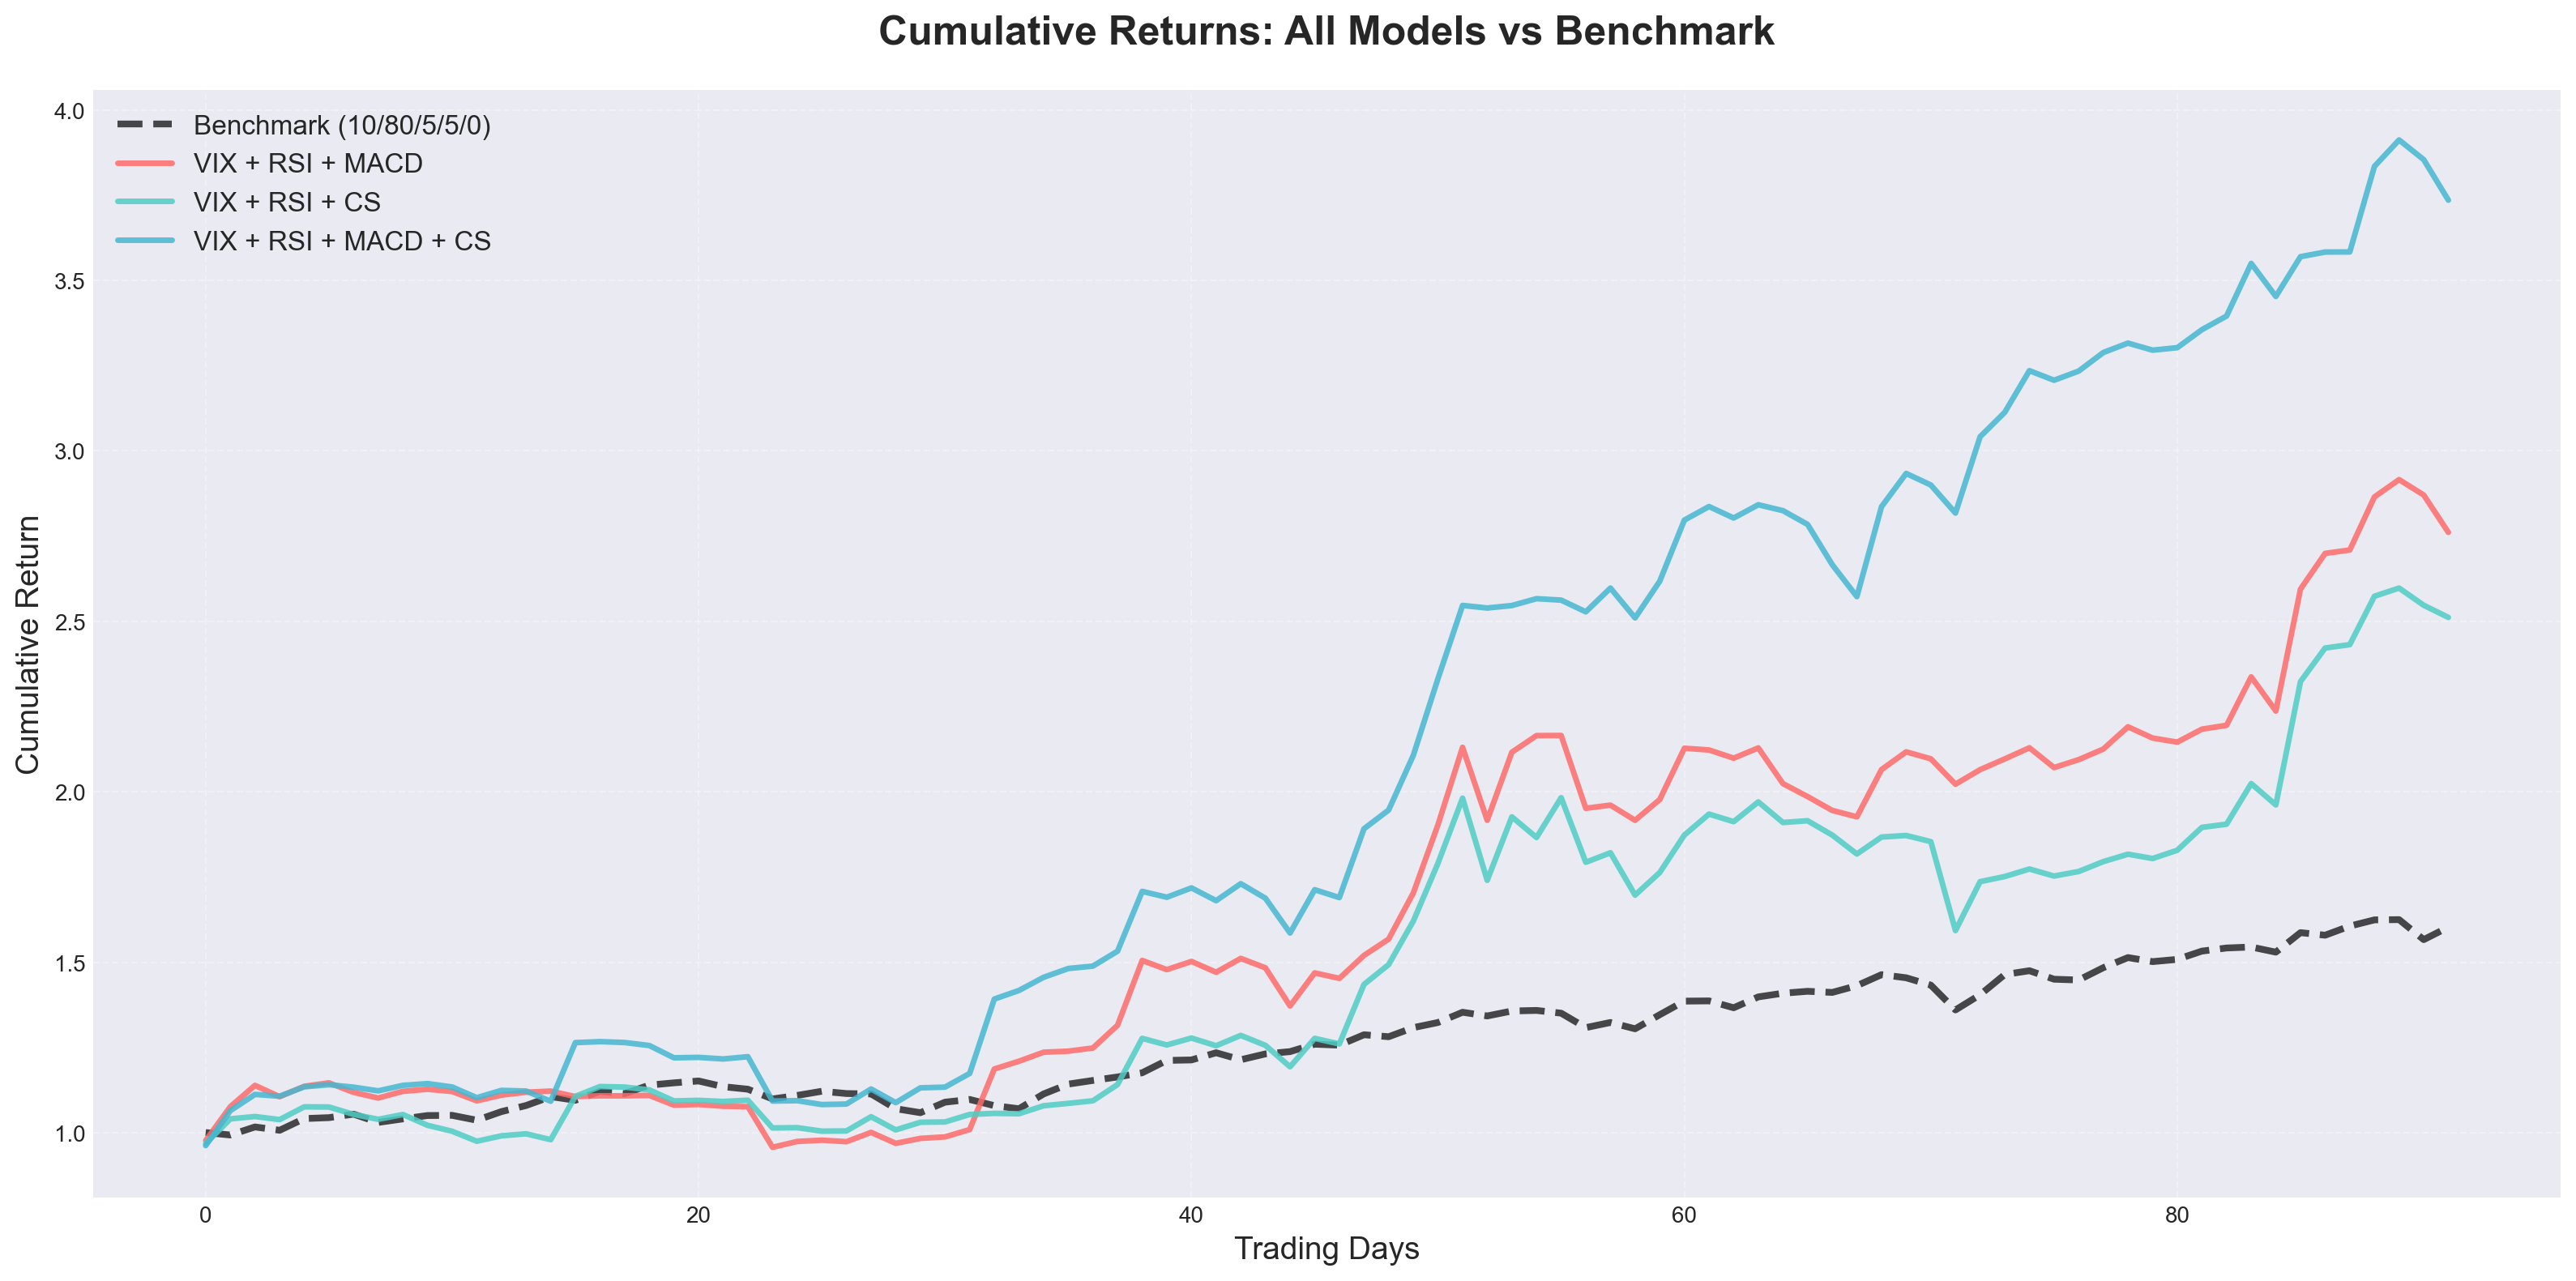

In [25]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plot benchmark first
ax.plot(benchmark_cumulative, label='Benchmark (10/80/5/5/0)', 
        linewidth=3, linestyle='--', color='black', alpha=0.7, zorder=1)

# Plot all models
for model_file, result in results.items():
    config = result['config']
    ax.plot(result['cumulative'], 
            label=config['name'], 
            linewidth=2.5, 
            color=config['color'], 
            alpha=0.85,
            zorder=2)

ax.set_title('Cumulative Returns: All Models vs Benchmark', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days', fontsize=14)
ax.set_ylabel('Cumulative Return', fontsize=14)
ax.legend(fontsize=12, loc='upper left', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

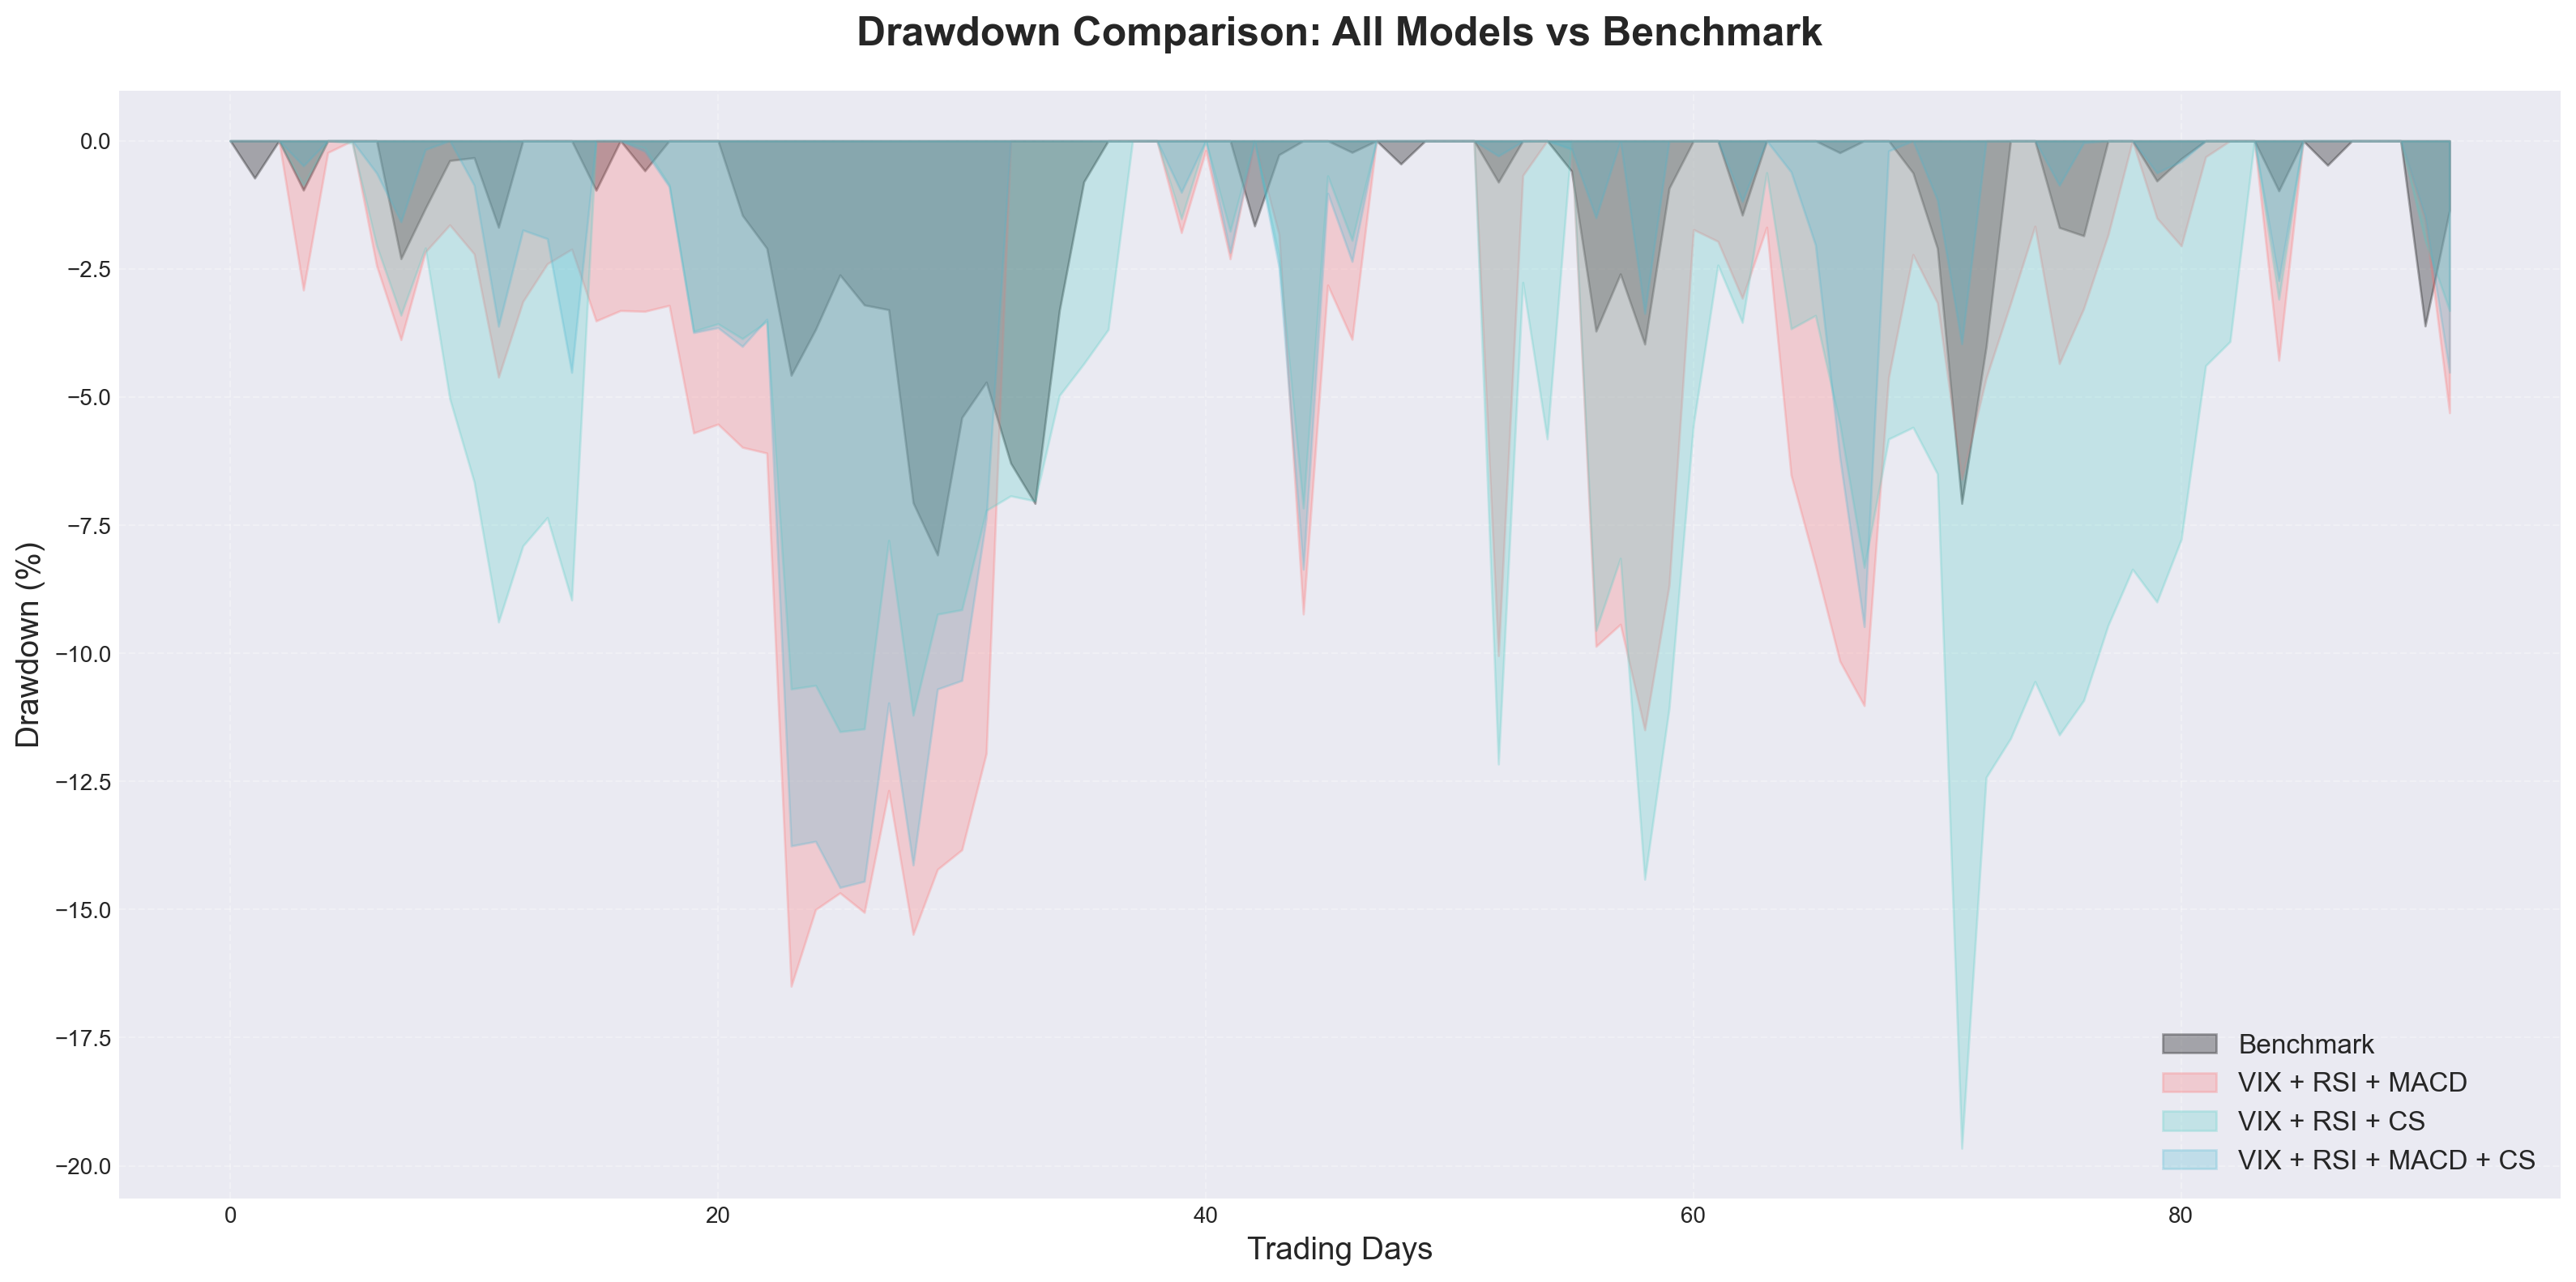

In [26]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plot benchmark
ax.fill_between(range(len(benchmark_drawdown)), benchmark_drawdown*100, 0,
                 alpha=0.3, label='Benchmark', color='black')

# Plot all models
for model_file, result in results.items():
    config = result['config']
    ax.fill_between(range(len(result['drawdown'])), result['drawdown']*100, 0,
                     alpha=0.25, label=config['name'], color=config['color'])

ax.set_title('Drawdown Comparison: All Models vs Benchmark', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days', fontsize=14)
ax.set_ylabel('Drawdown (%)', fontsize=14)
ax.legend(fontsize=12, loc='lower right', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

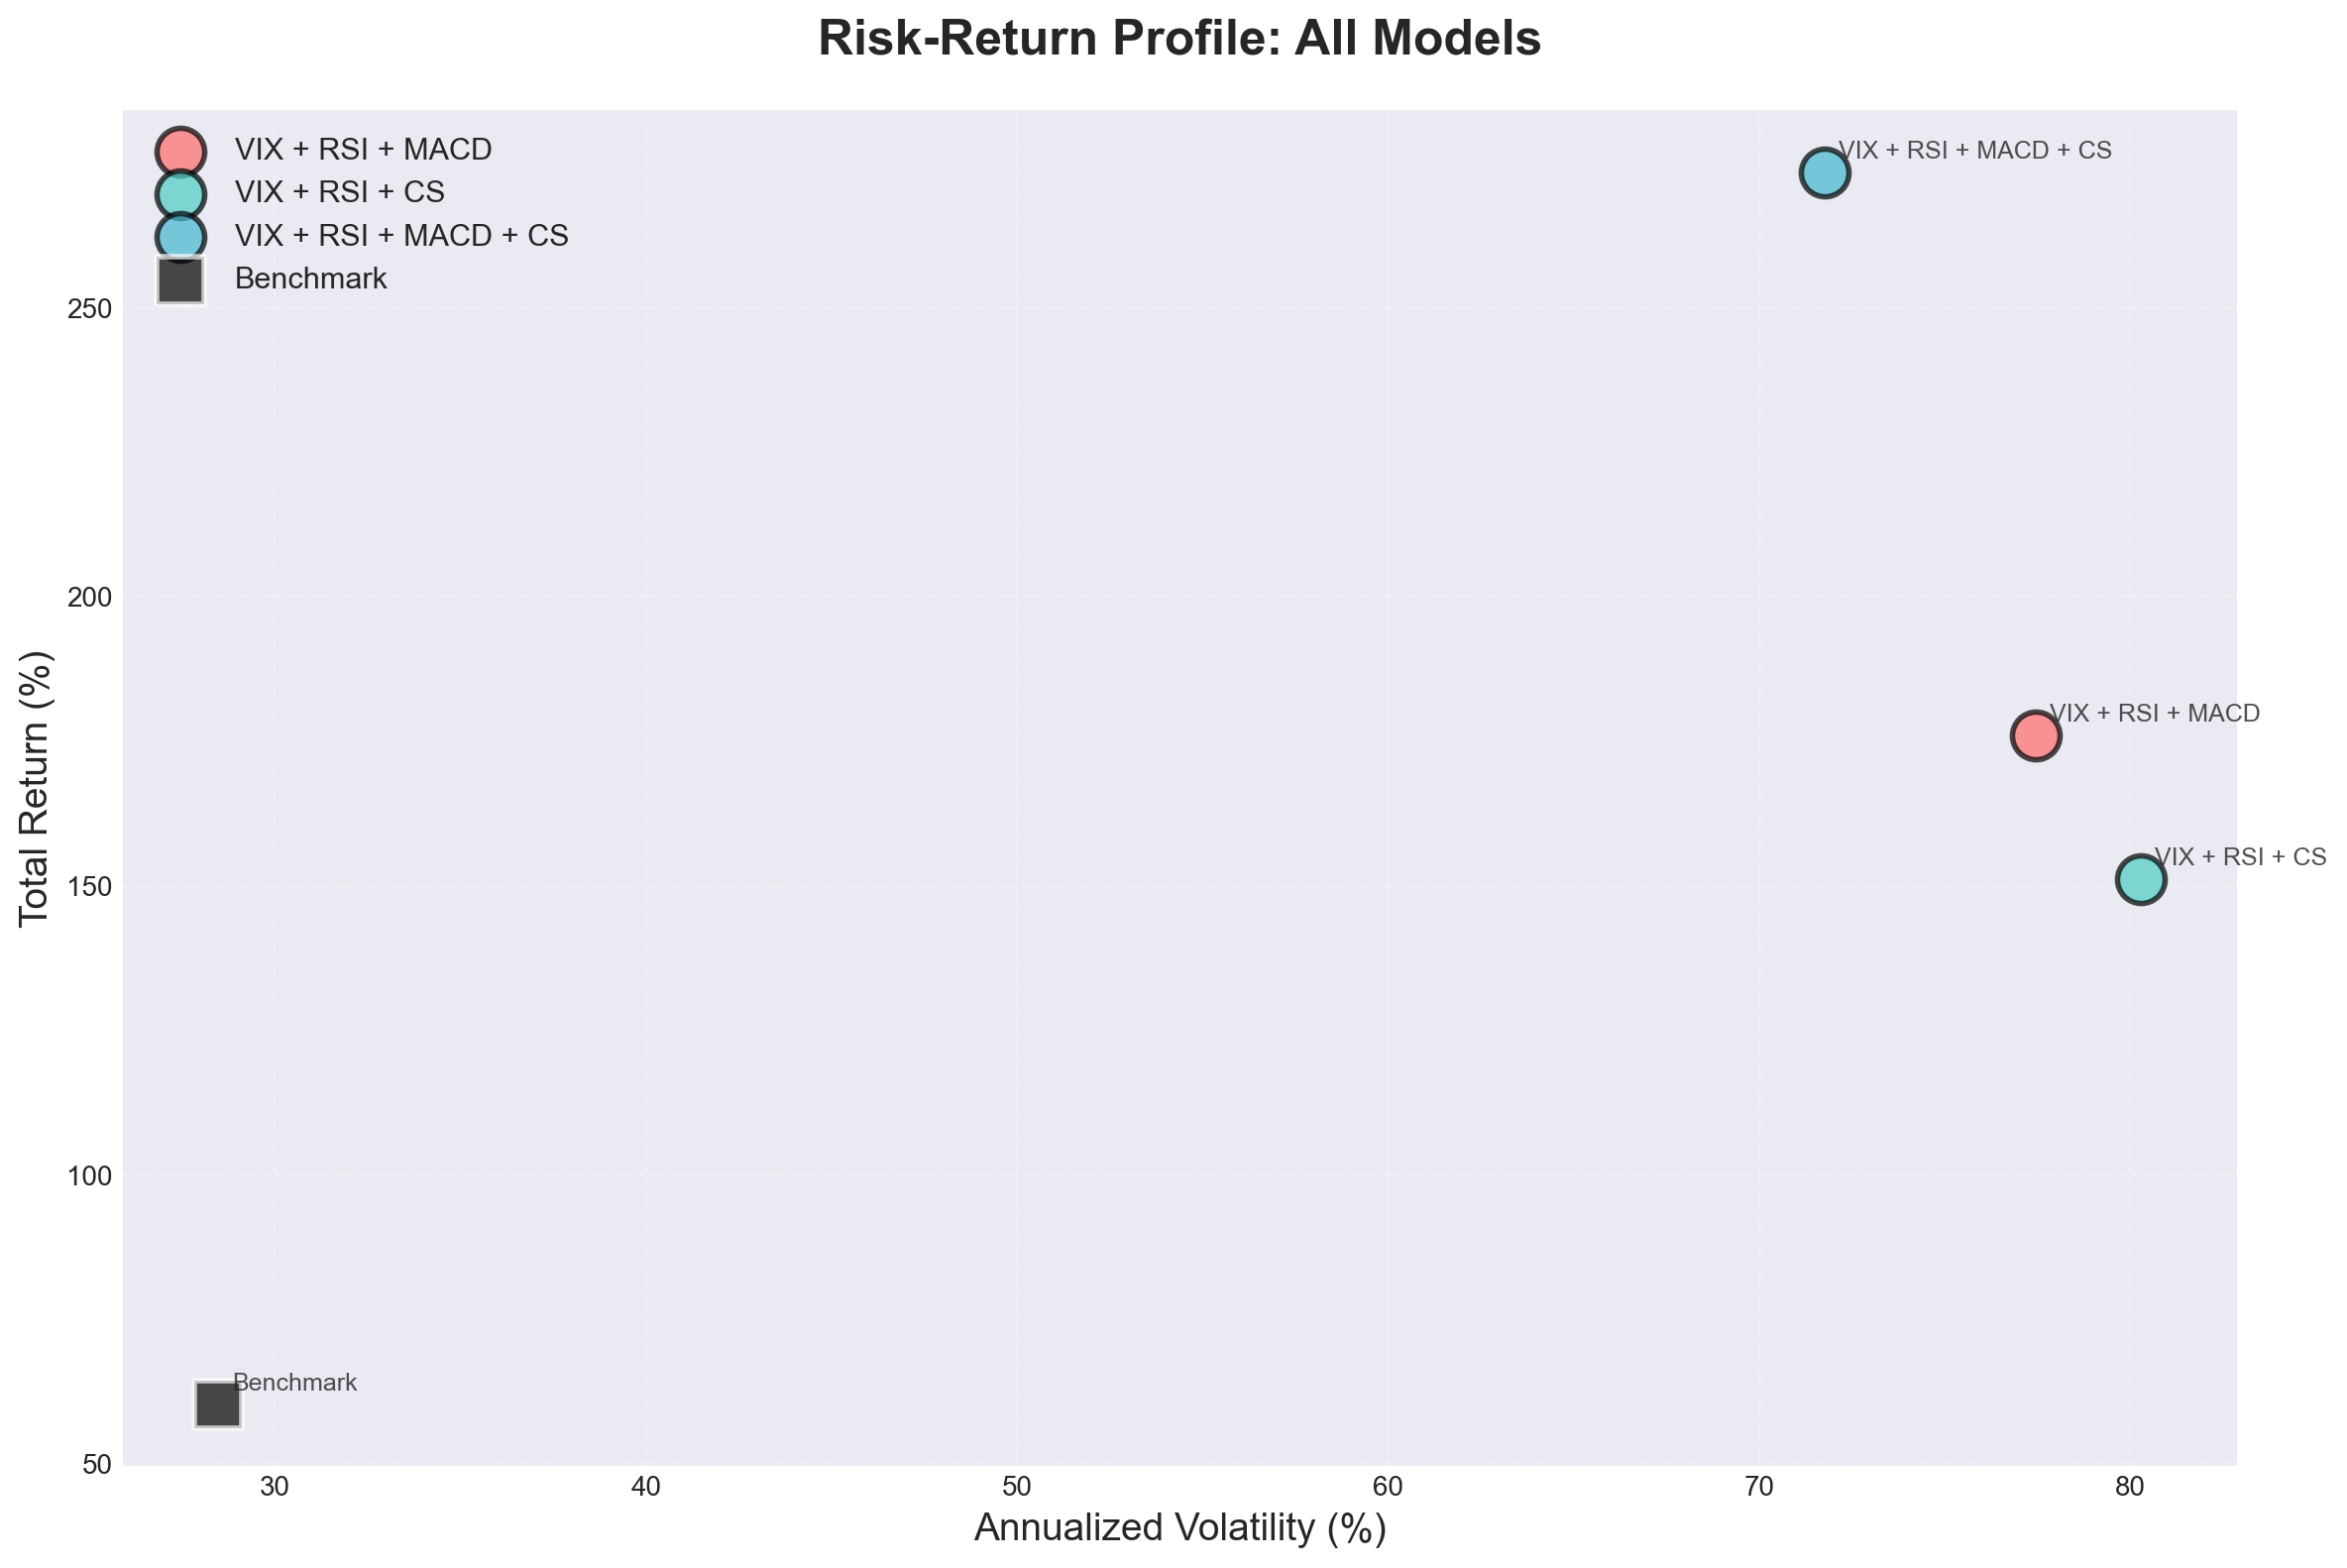

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot models
for model_file, result in results.items():
    config = result['config']
    ax.scatter(result['ann_volatility']*100, result['total_return']*100,
               s=300, c=config['color'], alpha=0.7, 
               edgecolors='black', linewidth=2,
               label=config['name'], zorder=3)

# Plot benchmark
ax.scatter(benchmark_ann_volatility*100, benchmark_total_return*100,
           s=300, c='black', alpha=0.7, marker='s',
           edgecolors='white', linewidth=2,
           label='Benchmark', zorder=3)

# Add labels for each point
for model_file, result in results.items():
    config = result['config']
    ax.annotate(config['name'], 
                (result['ann_volatility']*100, result['total_return']*100),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)

ax.annotate('Benchmark', 
            (benchmark_ann_volatility*100, benchmark_total_return*100),
            xytext=(5, 5), textcoords='offset points',
            fontsize=9, alpha=0.8)

ax.set_title('Risk-Return Profile: All Models', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Annualized Volatility (%)', fontsize=14)
ax.set_ylabel('Total Return (%)', fontsize=14)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

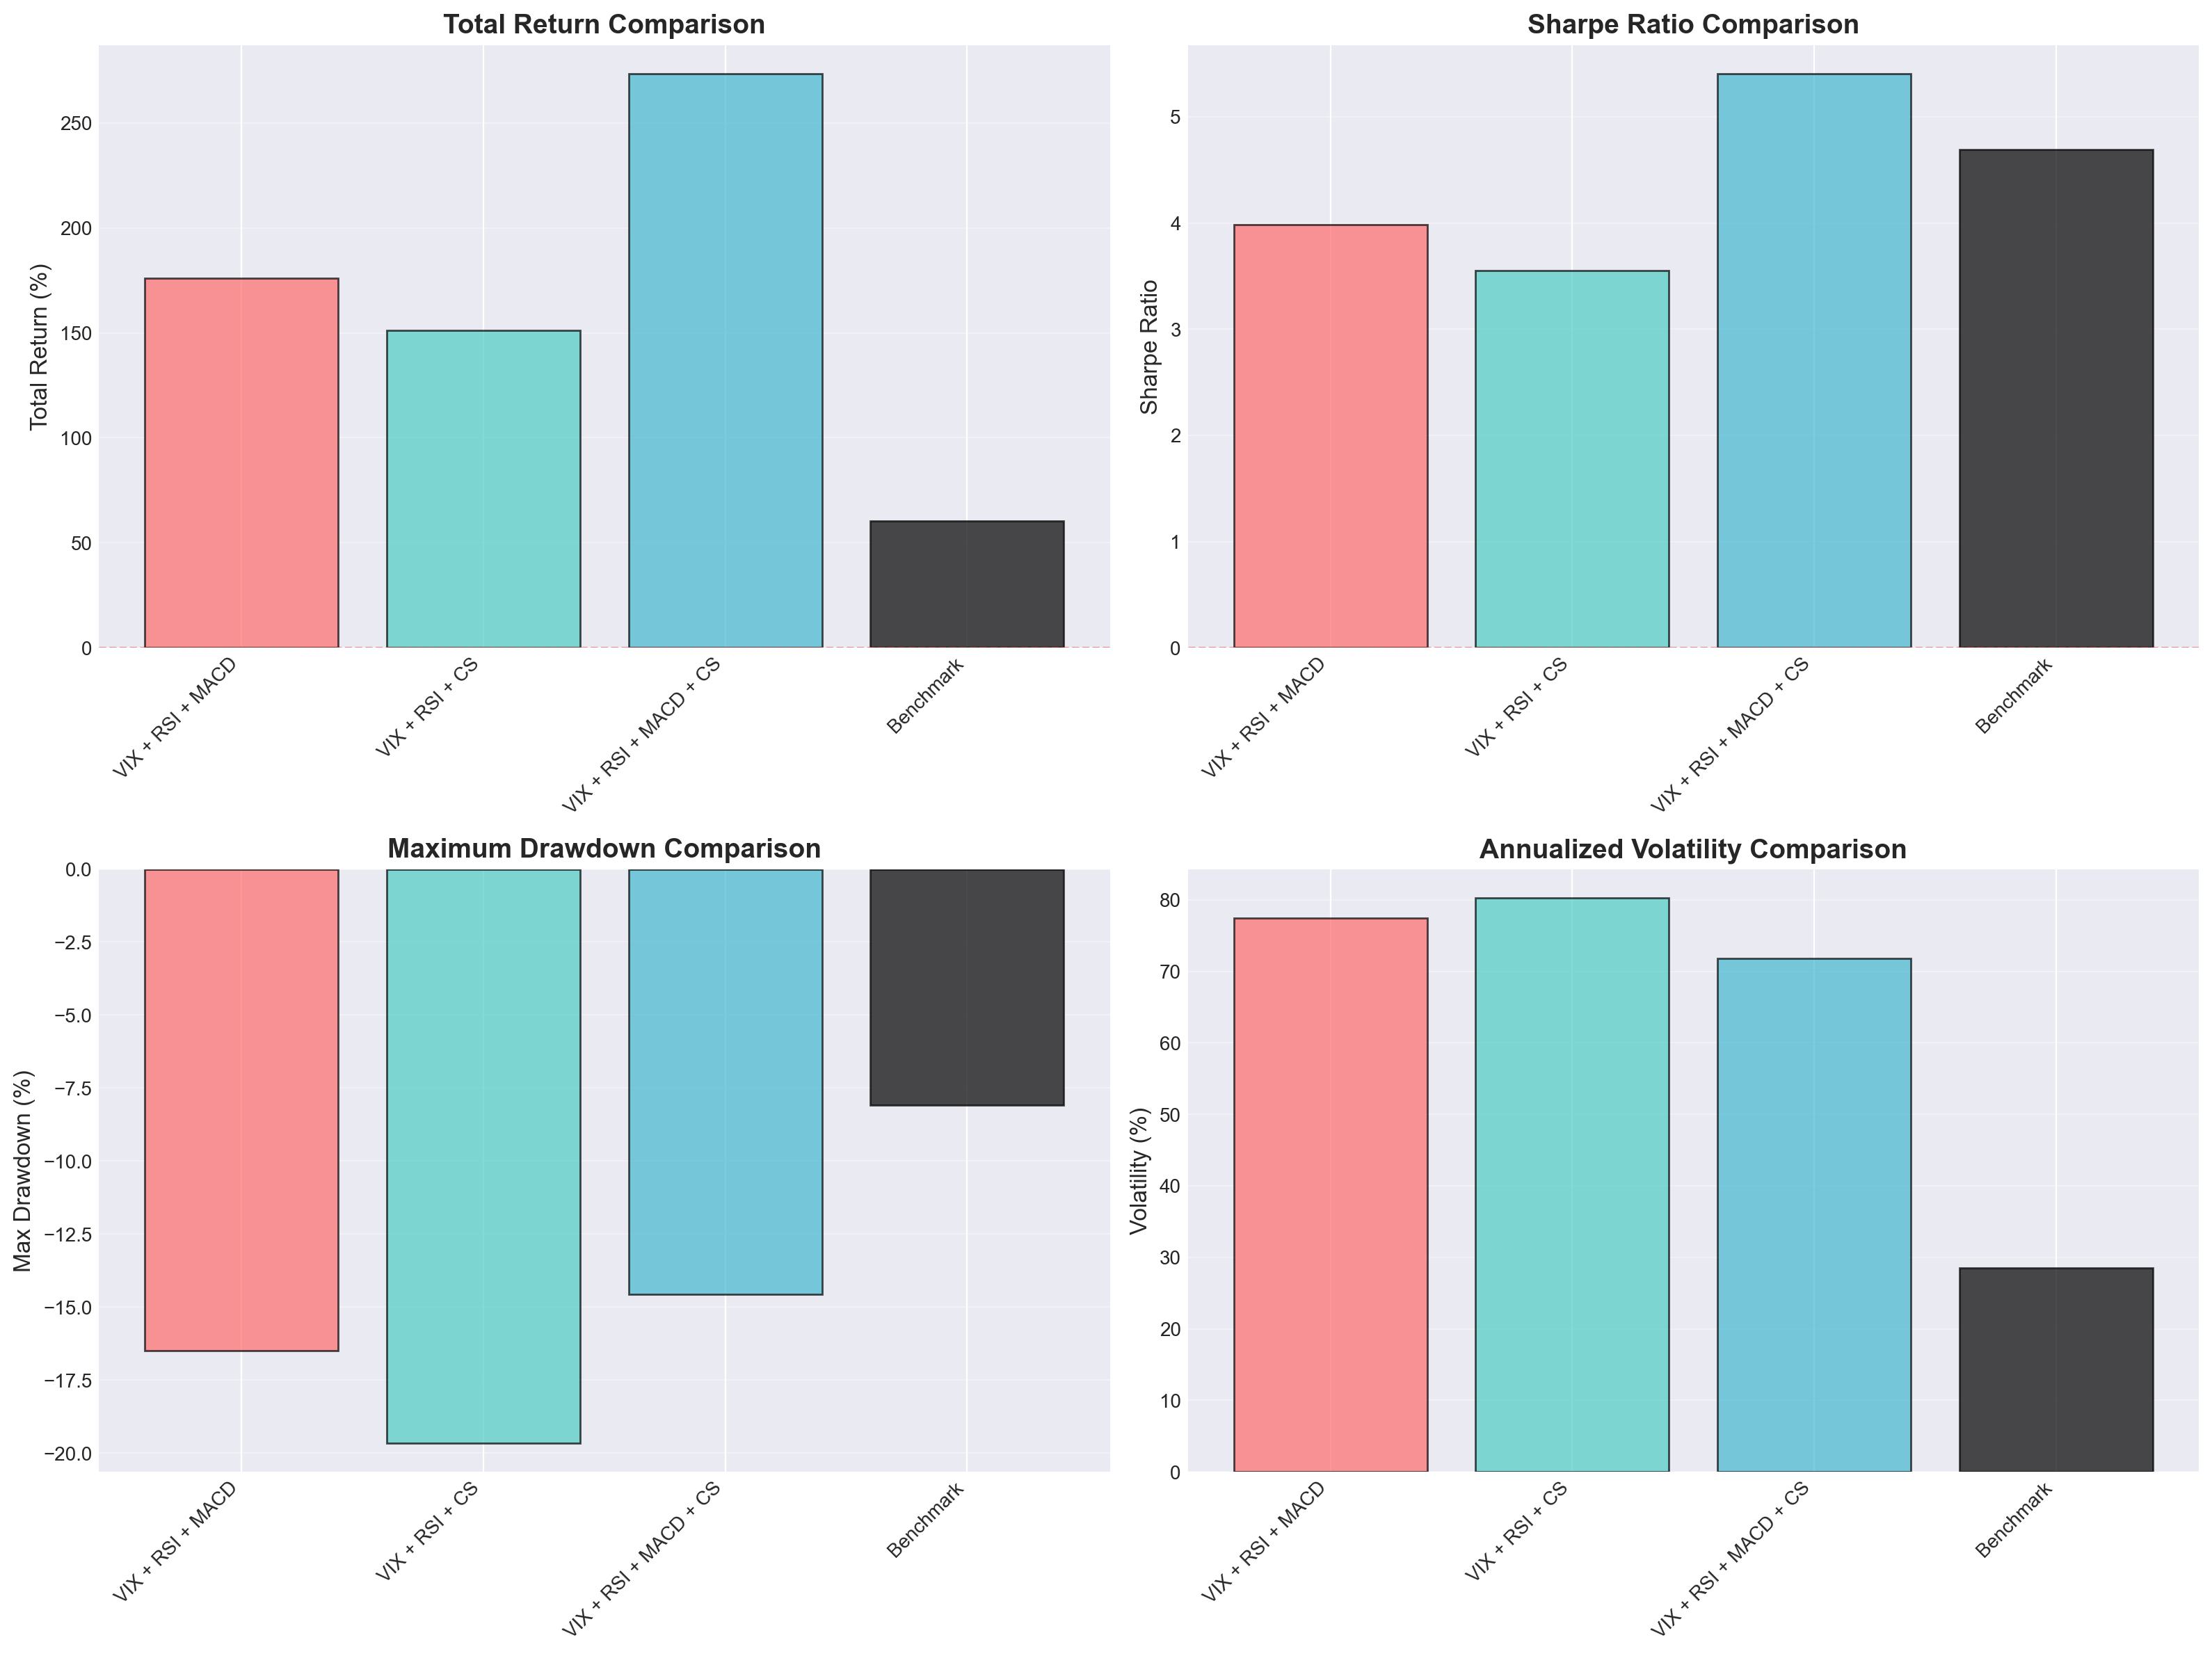

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data
model_names = [results[mf]['config']['name'] for mf in results.keys()] + ['Benchmark']
colors_list = [results[mf]['config']['color'] for mf in results.keys()] + ['black']

# Total Returns
ax1 = axes[0, 0]
returns = [results[mf]['total_return']*100 for mf in results.keys()] + [benchmark_total_return*100]
bars1 = ax1.bar(range(len(model_names)), returns, color=colors_list, alpha=0.7, edgecolor='black')
ax1.set_title('Total Return Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Total Return (%)', fontsize=12)
ax1.set_xticks(range(len(model_names)))
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Sharpe Ratios
ax2 = axes[0, 1]
sharpes = [results[mf]['sharpe'] for mf in results.keys()] + [benchmark_sharpe]
bars2 = ax2.bar(range(len(model_names)), sharpes, color=colors_list, alpha=0.7, edgecolor='black')
ax2.set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Sharpe Ratio', fontsize=12)
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Max Drawdowns
ax3 = axes[1, 0]
drawdowns = [results[mf]['max_drawdown']*100 for mf in results.keys()] + [benchmark_max_drawdown*100]
bars3 = ax3.bar(range(len(model_names)), drawdowns, color=colors_list, alpha=0.7, edgecolor='black')
ax3.set_title('Maximum Drawdown Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('Max Drawdown (%)', fontsize=12)
ax3.set_xticks(range(len(model_names)))
ax3.set_xticklabels(model_names, rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

# Volatility
ax4 = axes[1, 1]
vols = [results[mf]['ann_volatility']*100 for mf in results.keys()] + [benchmark_ann_volatility*100]
bars4 = ax4.bar(range(len(model_names)), vols, color=colors_list, alpha=0.7, edgecolor='black')
ax4.set_title('Annualized Volatility Comparison', fontsize=14, fontweight='bold')
ax4.set_ylabel('Volatility (%)', fontsize=12)
ax4.set_xticks(range(len(model_names)))
ax4.set_xticklabels(model_names, rotation=45, ha='right')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### **Credit Spread Impact**

In [29]:
print("\n" + "="*70)
print("CREDIT SPREAD FEATURE IMPACT ANALYSIS")
print("="*70)

# Group models by Credit Spread usage
with_cs = []
without_cs = []

for model_file, result in results.items():
    config = result['config']
    if config['use_credit_spread']:
        with_cs.append({
            'name': config['name'],
            'return': result['total_return'],
            'sharpe': result['sharpe']
        })
    else:
        without_cs.append({
            'name': config['name'],
            'return': result['total_return'],
            'sharpe': result['sharpe']
        })

# Calculate averages
if with_cs and without_cs:
    avg_return_with_cs = np.mean([m['return'] for m in with_cs]) * 100
    avg_return_without_cs = np.mean([m['return'] for m in without_cs]) * 100
    avg_sharpe_with_cs = np.mean([m['sharpe'] for m in with_cs])
    avg_sharpe_without_cs = np.mean([m['sharpe'] for m in without_cs])
    
    print("\n📊 Models WITH Credit Spread Features:")
    for model in with_cs:
        print(f"   {model['name']:30s} | Return: {model['return']*100:>6.2f}% | Sharpe: {model['sharpe']:>6.4f}")
    print(f"   {'Average:':30s} | Return: {avg_return_with_cs:>6.2f}% | Sharpe: {avg_sharpe_with_cs:>6.4f}")
    
    print("\n📊 Models WITHOUT Credit Spread Features:")
    for model in without_cs:
        print(f"   {model['name']:30s} | Return: {model['return']*100:>6.2f}% | Sharpe: {model['sharpe']:>6.4f}")
    print(f"   {'Average:':30s} | Return: {avg_return_without_cs:>6.2f}% | Sharpe: {avg_sharpe_without_cs:>6.4f}")
    
    print("\n" + "="*70)
    print("IMPACT SUMMARY:")
    print("="*70)
    
    return_improvement = avg_return_with_cs - avg_return_without_cs
    sharpe_improvement = avg_sharpe_with_cs - avg_sharpe_without_cs
    
    print(f"\n{'Credit Spread Feature Impact:':40s}")
    print(f"   Average Return Difference: {return_improvement:+.2f}%")
    print(f"   Average Sharpe Difference: {sharpe_improvement:+.4f}")
    
    if return_improvement > 0:
        print(f"\n   ✅ Models WITH Credit Spread features achieved {abs(return_improvement):.2f}% HIGHER returns on average")
    else:
        print(f"\n   ⚠️  Models WITHOUT Credit Spread features achieved {abs(return_improvement):.2f}% HIGHER returns on average")
    
    if sharpe_improvement > 0:
        print(f"   ✅ Models WITH Credit Spread features achieved {abs(sharpe_improvement):.4f} BETTER risk-adjusted returns")
    else:
        print(f"   ⚠️  Models WITHOUT Credit Spread features achieved {abs(sharpe_improvement):.4f} BETTER risk-adjusted returns")
else:
    print("\n⚠️  Need models both with and without Credit Spread features for comparison")


CREDIT SPREAD FEATURE IMPACT ANALYSIS

📊 Models WITH Credit Spread Features:
   VIX + RSI + CS                 | Return: 151.15% | Sharpe: 3.5505
   VIX + RSI + MACD + CS          | Return: 273.55% | Sharpe: 5.4081
   Average:                       | Return: 212.35% | Sharpe: 4.4793

📊 Models WITHOUT Credit Spread Features:
   VIX + RSI + MACD               | Return: 176.09% | Sharpe: 3.9857
   Average:                       | Return: 176.09% | Sharpe: 3.9857

IMPACT SUMMARY:

Credit Spread Feature Impact:           
   Average Return Difference: +36.26%
   Average Sharpe Difference: +0.4936

   ✅ Models WITH Credit Spread features achieved 36.26% HIGHER returns on average
   ✅ Models WITH Credit Spread features achieved 0.4936 BETTER risk-adjusted returns


### **Portfolio Weights Changes**

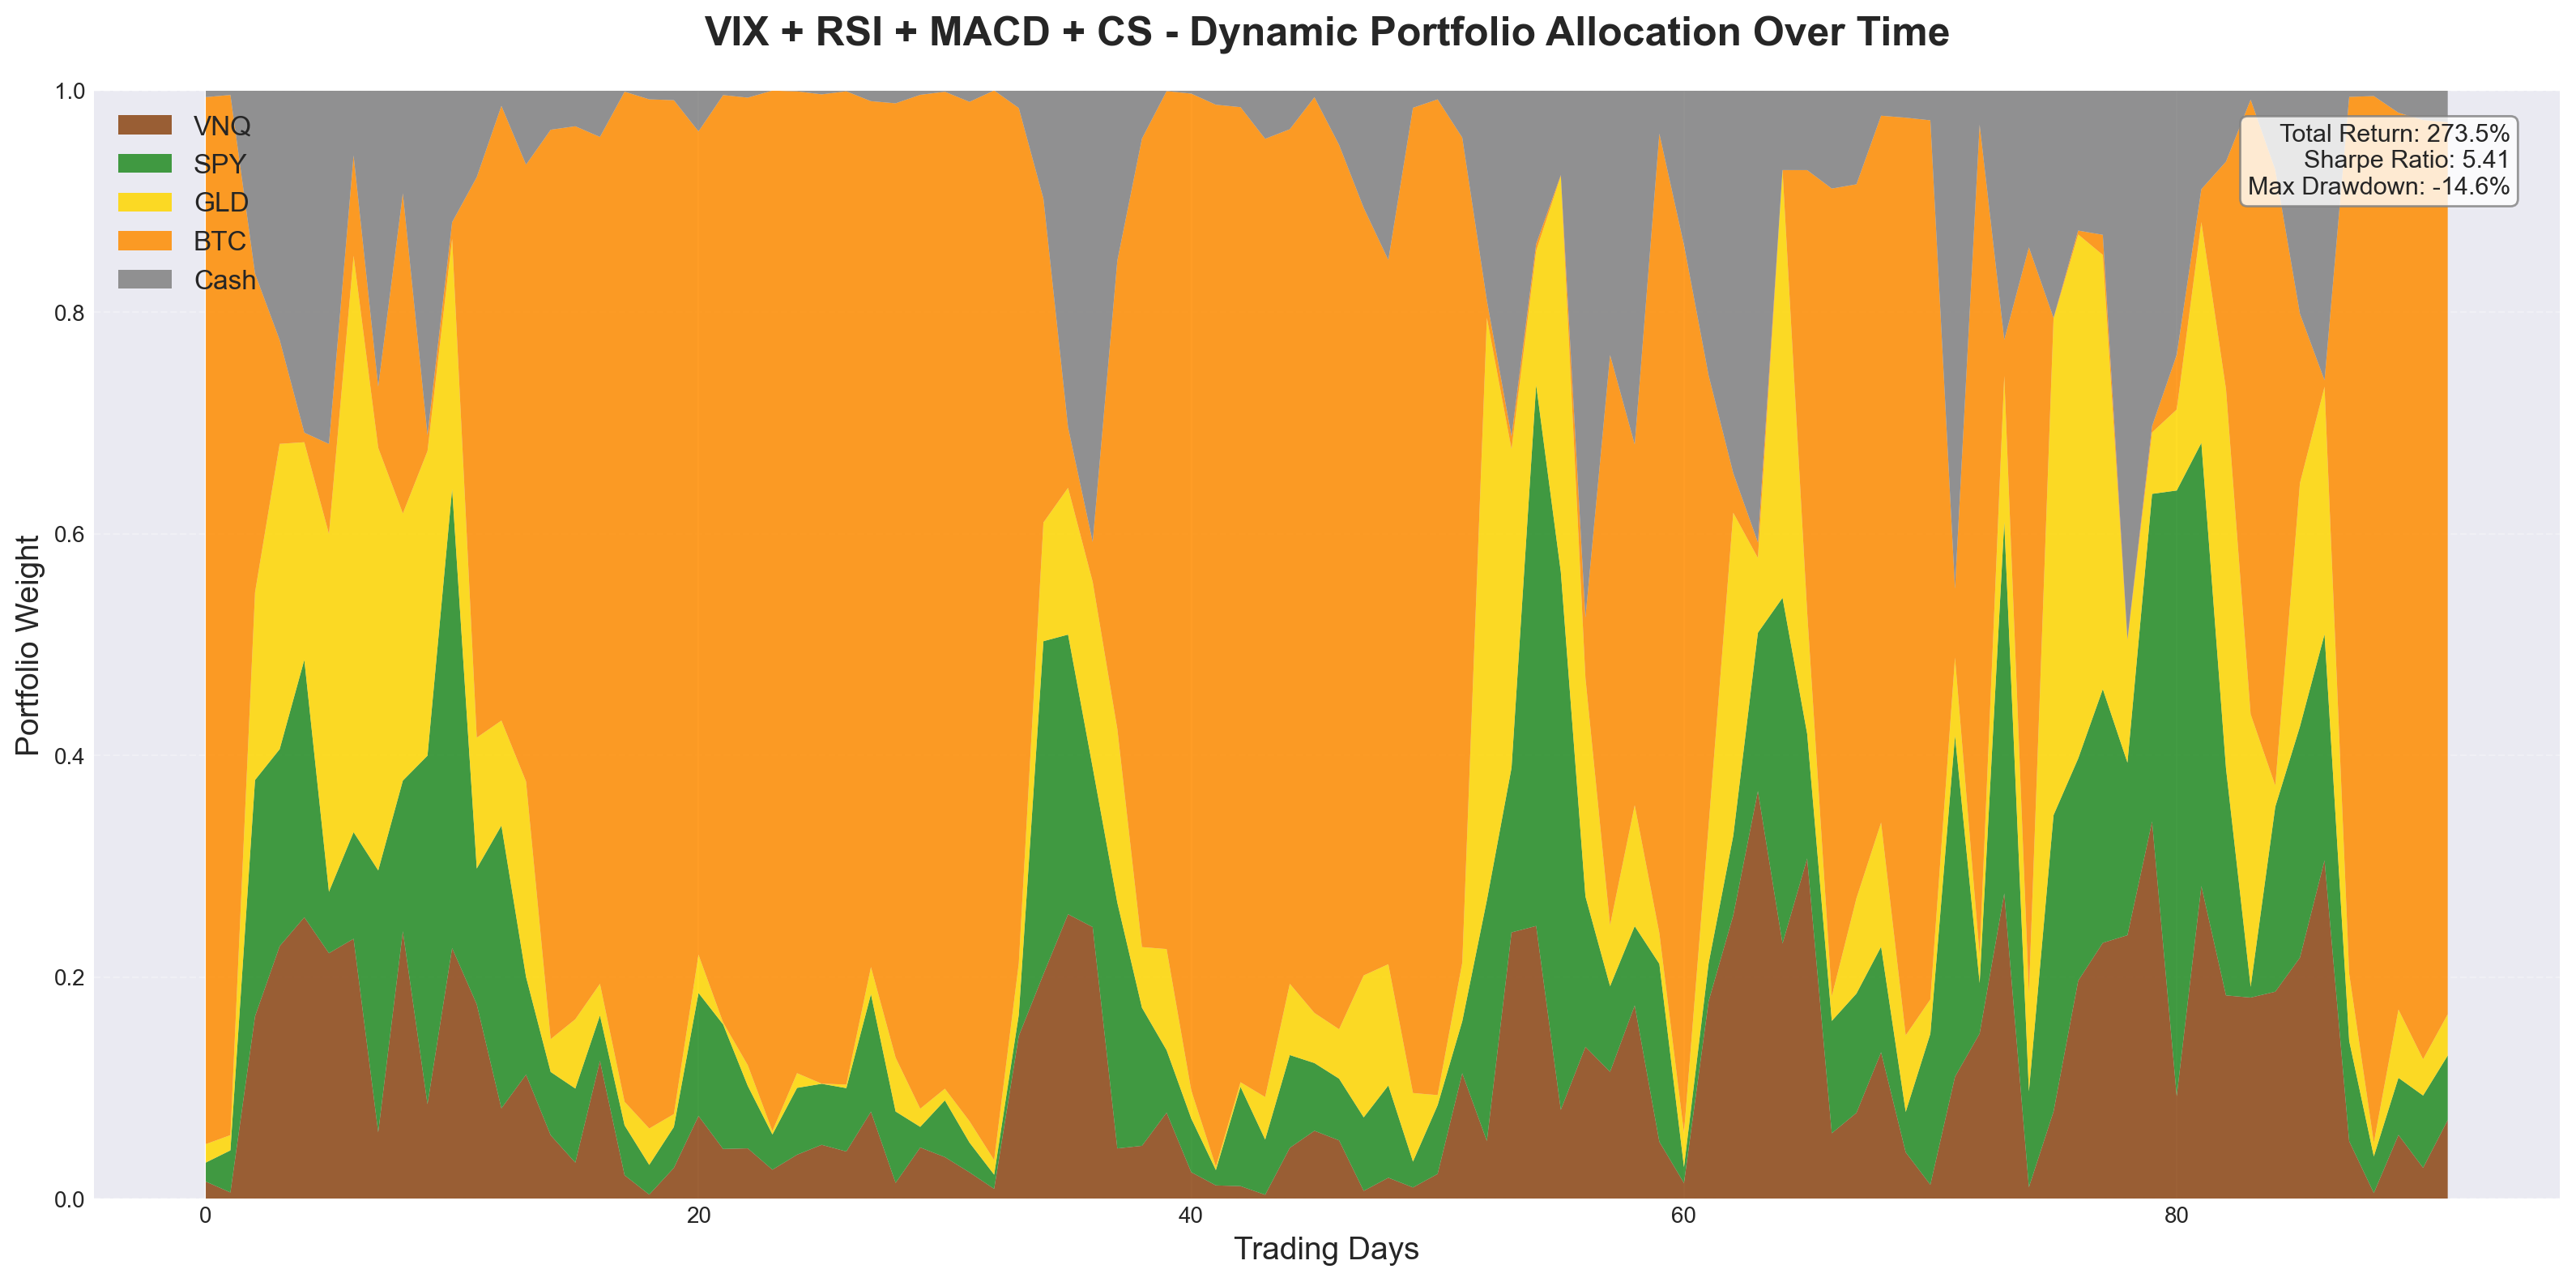


PORTFOLIO ALLOCATION STATISTICS - VIX + RSI + MACD + CS

Average Allocation:
    VNQ:  11.27%
    SPY:  13.20%
    GLD:  12.06%
    BTC:  52.35%
   Cash:  11.12%

Allocation Ranges (Min - Max):
    VNQ:   0.35% - 36.77%
    SPY:   0.96% - 54.65%
    GLD:   0.01% - 52.54%
    BTC:   0.01% - 96.51%
   Cash:   0.00% - 49.51%

Benchmark (Static Allocation):
    VNQ:  10.00%
    SPY:  80.00%
    GLD:   5.00%
    BTC:   5.00%
   Cash:   0.00%


In [32]:
# Cell 16: Portfolio Allocation Analysis - Best Model Only

# Get the best model (VIX + RSI + MACD + CS)
best_model_file = 'a2c_vix_cs_1800k.pth'
best_result = results[best_model_file]
best_config = best_result['config']

asset_names = ['VNQ', 'SPY', 'GLD', 'BTC', 'Cash']
colors_assets = ['#8B4513', '#228B22', '#FFD700', '#FF8C00', '#808080']

# Create single large chart
fig, ax = plt.subplots(figsize=(16, 8))

# Create stackplot
ax.stackplot(range(len(best_result['actions'])),
             best_result['actions'][:, 0],  # VNQ
             best_result['actions'][:, 1],  # SPY
             best_result['actions'][:, 2],  # GLD
             best_result['actions'][:, 3],  # BTC
             best_result['actions'][:, 4],  # Cash
             labels=asset_names,
             colors=colors_assets,
             alpha=0.85)

ax.set_title(f'{best_config["name"]} - Dynamic Portfolio Allocation Over Time', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days', fontsize=14)
ax.set_ylabel('Portfolio Weight', fontsize=14)
ax.legend(loc='upper left', fontsize=12, framealpha=0.95)
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add text box with key stats
stats_text = f"Total Return: {best_result['total_return']*100:.1f}%\nSharpe Ratio: {best_result['sharpe']:.2f}\nMax Drawdown: {best_result['max_drawdown']*100:.1f}%"
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

plt.tight_layout()
plt.show()

# Print average and min/max allocations
print("\n" + "="*70)
print(f"PORTFOLIO ALLOCATION STATISTICS - {best_config['name']}")
print("="*70)

print(f"\nAverage Allocation:")
for name, weight in zip(asset_names, best_result['avg_weights']):
    print(f"   {name:>4}: {weight*100:>6.2f}%")

print(f"\nAllocation Ranges (Min - Max):")
for i, name in enumerate(asset_names):
    min_weight = np.min(best_result['actions'][:, i]) * 100
    max_weight = np.max(best_result['actions'][:, i]) * 100
    print(f"   {name:>4}: {min_weight:>6.2f}% - {max_weight:>5.2f}%")

print(f"\nBenchmark (Static Allocation):")
for name, weight in zip(asset_names, BENCHMARK_WEIGHTS):
    print(f"   {name:>4}: {weight*100:>6.2f}%")

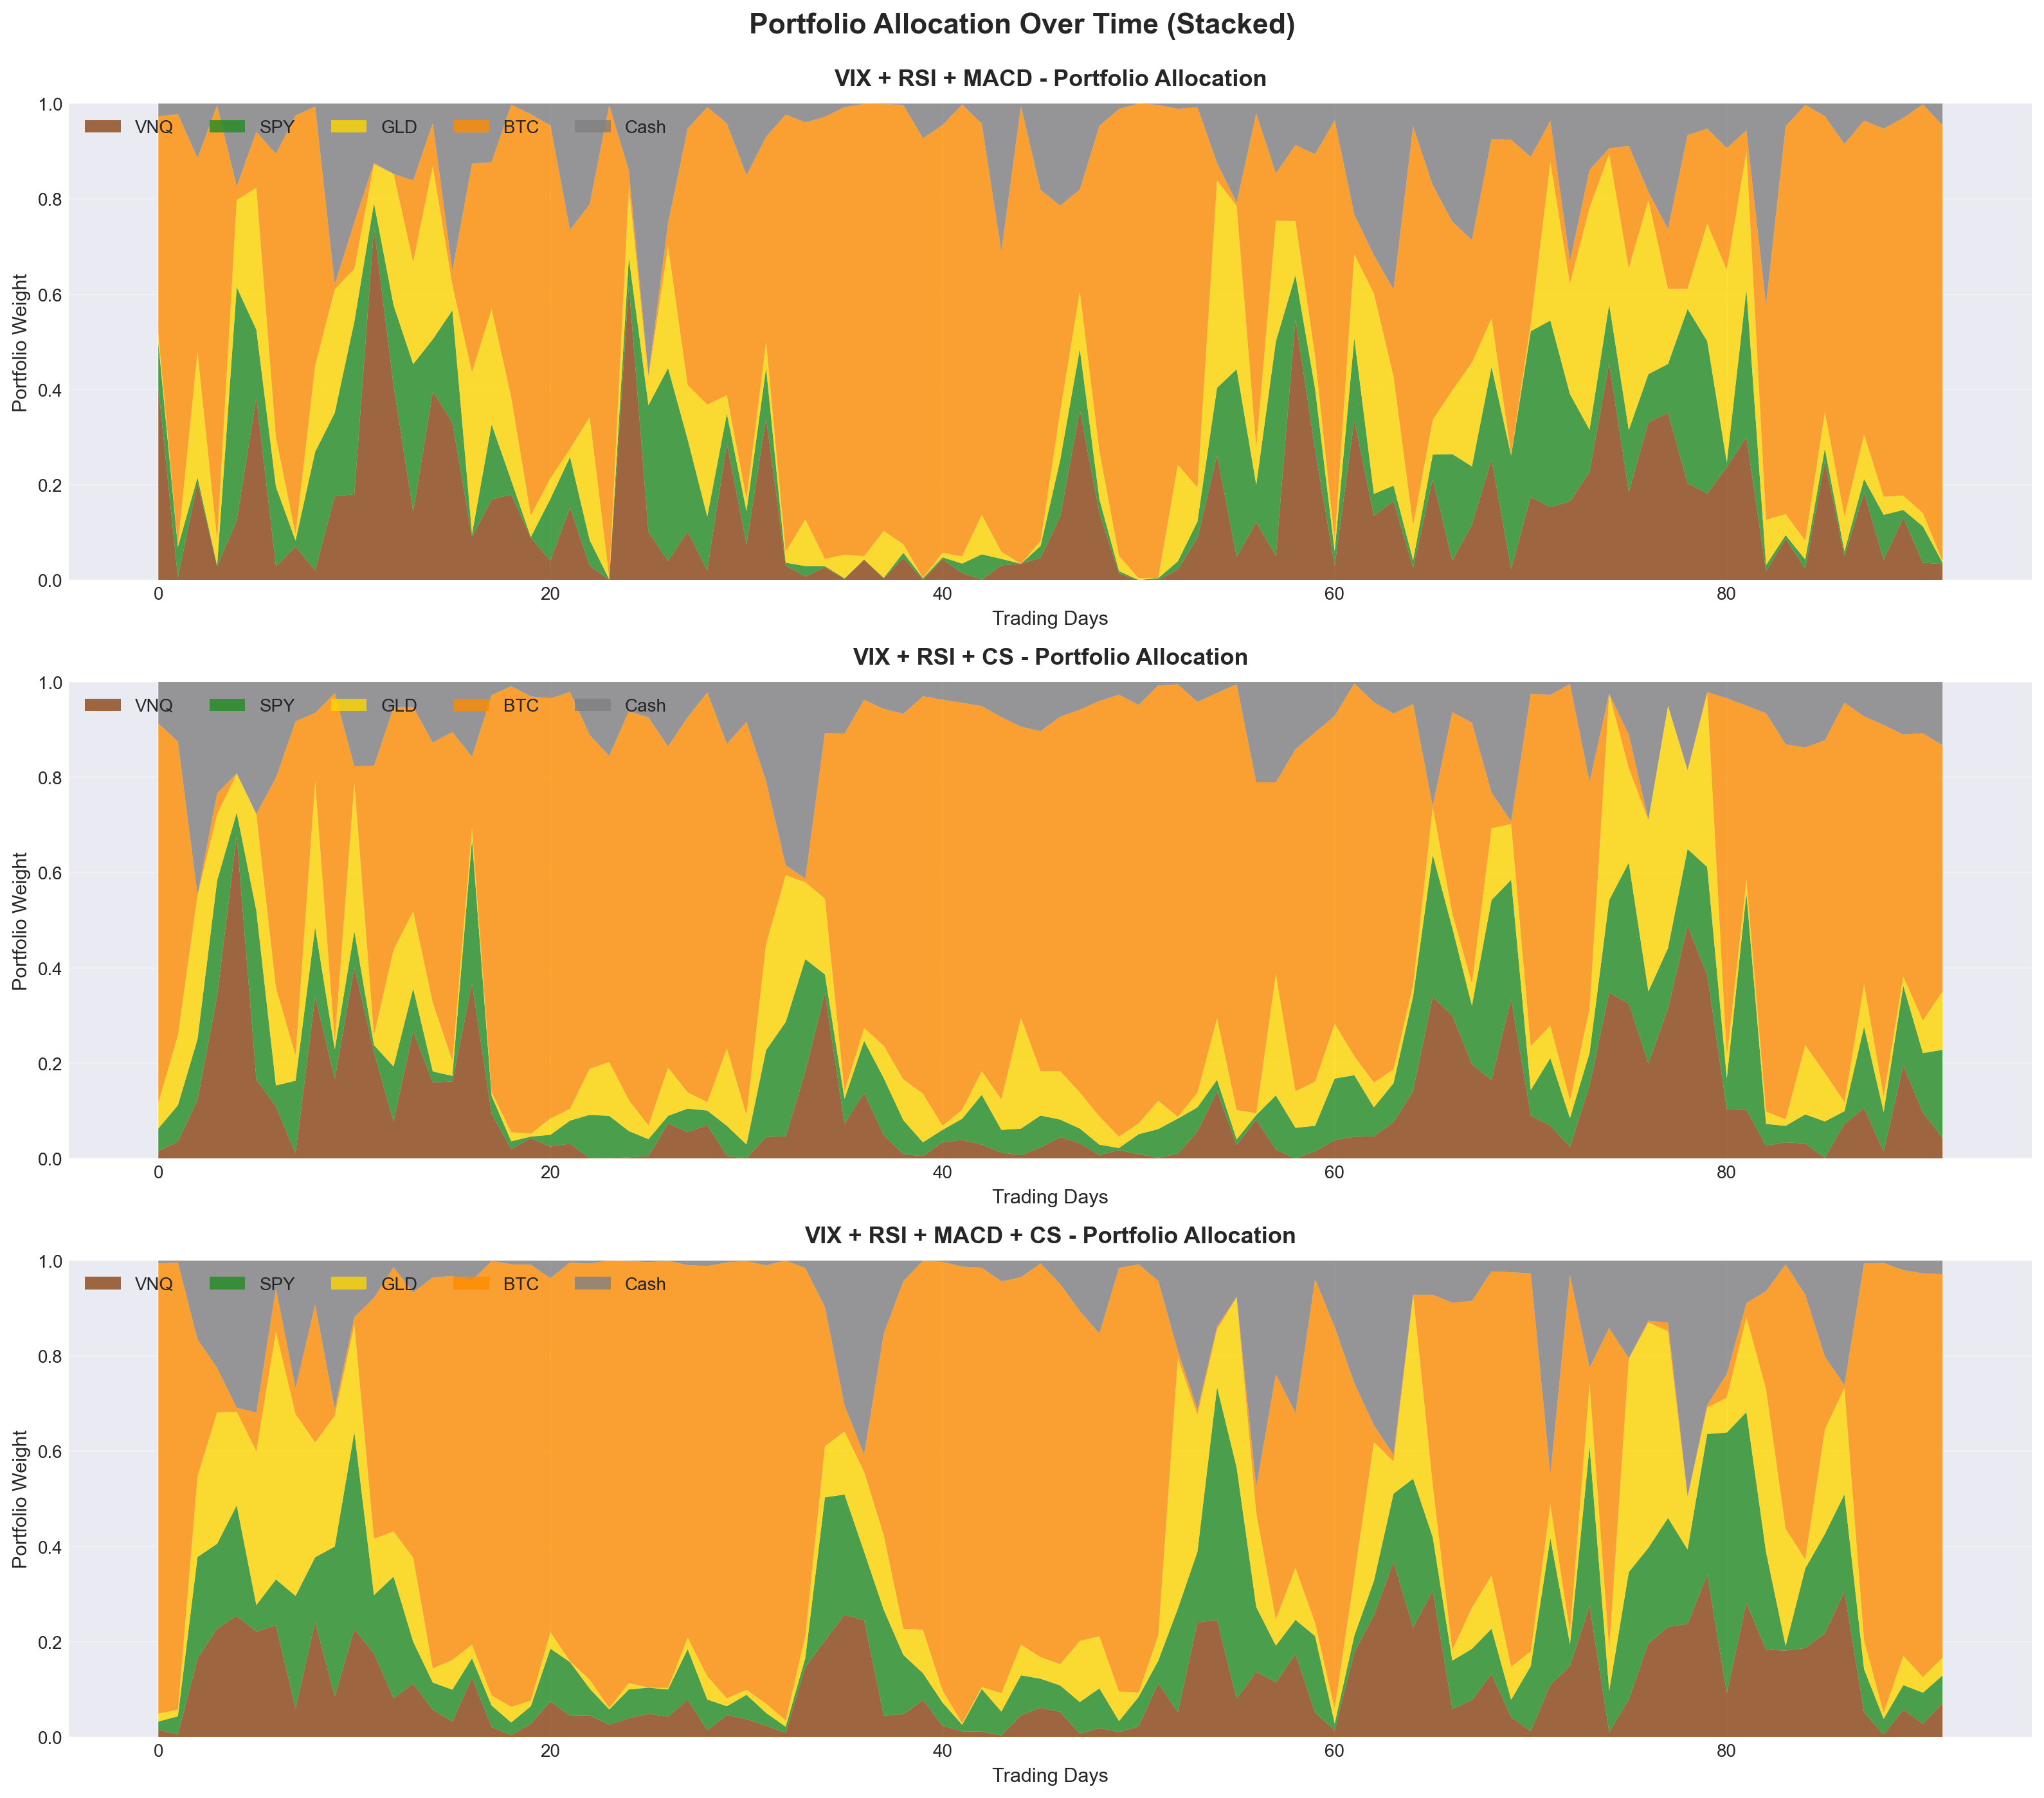


AVERAGE PORTFOLIO ALLOCATIONS

VIX + RSI + MACD:
    VNQ:  14.71%
    SPY:  11.00%
    GLD:  13.13%
    BTC:  50.13%
   Cash:  11.03%

VIX + RSI + CS:
    VNQ:  11.41%
    SPY:  10.16%
    GLD:  10.40%
    BTC:  57.65%
   Cash:  10.39%

VIX + RSI + MACD + CS:
    VNQ:  11.27%
    SPY:  13.20%
    GLD:  12.06%
    BTC:  52.35%
   Cash:  11.12%

Benchmark:
    VNQ:  10.00%
    SPY:  80.00%
    GLD:   5.00%
    BTC:   5.00%
   Cash:   0.00%


In [33]:
# Cell 16: Portfolio Allocation Analysis

fig, axes = plt.subplots(3, 1, figsize=(16, 14))
asset_names = ['VNQ', 'SPY', 'GLD', 'BTC', 'Cash']
colors_assets = ['#8B4513', '#228B22', '#FFD700', '#FF8C00', '#808080']

# Get list of models
model_list = list(results.items())

for idx, (model_file, result) in enumerate(model_list):
    ax = axes[idx]
    config = result['config']
    
    # Create stackplot
    ax.stackplot(range(len(result['actions'])),
                 result['actions'][:, 0],  # VNQ
                 result['actions'][:, 1],  # SPY
                 result['actions'][:, 2],  # GLD
                 result['actions'][:, 3],  # BTC
                 result['actions'][:, 4],  # Cash
                 labels=asset_names,
                 colors=colors_assets,
                 alpha=0.8)
    
    ax.set_title(f'{config["name"]} - Portfolio Allocation', 
                 fontsize=13, fontweight='bold', pad=10)
    ax.set_xlabel('Trading Days', fontsize=11)
    ax.set_ylabel('Portfolio Weight', fontsize=11)
    ax.legend(loc='upper left', fontsize=10, framealpha=0.95, ncol=5)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Portfolio Allocation Over Time (Stacked)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print average allocations
print("\n" + "="*70)
print("AVERAGE PORTFOLIO ALLOCATIONS")
print("="*70)

for model_file, result in results.items():
    config = result['config']
    print(f"\n{config['name']}:")
    for name, weight in zip(asset_names, result['avg_weights']):
        print(f"   {name:>4}: {weight*100:>6.2f}%")

# Also add benchmark allocation for comparison
print(f"\nBenchmark:")
for name, weight in zip(asset_names, BENCHMARK_WEIGHTS):
    print(f"   {name:>4}: {weight*100:>6.2f}%")

### **Transaction Costs Analysis**

In [35]:
# Cell 17: Portfolio Turnover and Transaction Costs Analysis

print("\n" + "="*70)
print("PORTFOLIO TURNOVER & TRANSACTION COSTS ANALYSIS")
print("="*70)

# Transaction cost assumptions
TRANSACTION_COST_BPS = 10  # 10 basis points (0.10%) per trade
# This includes: bid-ask spread (~3-5 bps) + commissions (~1-2 bps) + market impact (~3-5 bps)

def calculate_turnover_and_costs(actions, rewards):
    """
    Calculate portfolio turnover and transaction costs
    
    Turnover = sum of absolute weight changes / 2
    (divide by 2 because buying and selling is double-counted)
    """
    # Calculate weight changes between periods
    weight_changes = np.abs(np.diff(actions, axis=0))
    
    # Turnover per period (sum of absolute changes / 2)
    turnover_per_period = np.sum(weight_changes, axis=1) / 2
    
    # Average daily turnover
    avg_daily_turnover = np.mean(turnover_per_period)
    
    # Total turnover over entire period
    total_turnover = np.sum(turnover_per_period)
    
    # Annualized turnover (assuming 252 trading days)
    annualized_turnover = avg_daily_turnover * 252
    
    # Transaction costs per period (turnover * cost in bps)
    costs_per_period = turnover_per_period * (TRANSACTION_COST_BPS / 10000)
    
    # Net returns after costs
    net_rewards = rewards[1:] - costs_per_period  # Skip first period (no rebalancing yet)
    
    # Calculate net metrics
    net_cumulative = np.cumprod(1 + net_rewards)
    net_total_return = net_cumulative[-1] - 1
    net_sharpe = np.mean(net_rewards) / (np.std(net_rewards) + 1e-8) * np.sqrt(252)
    
    # Total costs
    total_costs = np.sum(costs_per_period)
    
    return {
        'avg_daily_turnover': avg_daily_turnover,
        'annualized_turnover': annualized_turnover,
        'total_turnover': total_turnover,
        'total_costs': total_costs,
        'costs_per_period': costs_per_period,
        'net_rewards': net_rewards,
        'net_cumulative': net_cumulative,
        'net_total_return': net_total_return,
        'net_sharpe': net_sharpe
    }

# Calculate for all models
turnover_results = {}

for model_file, result in results.items():
    config = result['config']
    turnover_results[model_file] = calculate_turnover_and_costs(
        result['actions'], 
        result['rewards']
    )

# Benchmark has zero turnover (static allocation)
benchmark_turnover = {
    'avg_daily_turnover': 0.0,
    'annualized_turnover': 0.0,
    'total_turnover': 0.0,
    'total_costs': 0.0,
    'net_total_return': benchmark_total_return,
    'net_sharpe': benchmark_sharpe
}

# Print comprehensive comparison
print(f"\nTransaction Cost Assumption: {TRANSACTION_COST_BPS} basis points (0.{TRANSACTION_COST_BPS}%) per trade")
print("\n" + "-"*110)
print(f"{'Model':<25} {'Avg Daily':<12} {'Annual':<12} {'Total':<10} {'Gross':<12} {'Net':<12} {'Cost':<10} {'Sharpe':<10} {'Net':<10}")
print(f"{'':25} {'Turnover':<12} {'Turnover':<12} {'Costs':<10} {'Return':<12} {'Return':<12} {'Impact':<10} {'(Gross)':<10} {'Sharpe':<10}")
print("-"*110)

# Print all models
for model_file, result in results.items():
    config = result['config']
    gross_return = result['total_return']
    net_return = turnover_results[model_file]['net_total_return']
    cost_impact = gross_return - net_return
    gross_sharpe = result['sharpe']
    net_sharpe = turnover_results[model_file]['net_sharpe']
    
    print(f"{config['name']:<25} "
          f"{turnover_results[model_file]['avg_daily_turnover']:>10.2%}  "
          f"{turnover_results[model_file]['annualized_turnover']:>10.1f}x  "
          f"{turnover_results[model_file]['total_costs']:>8.2%}  "
          f"{gross_return:>10.2%}  "
          f"{net_return:>10.2%}  "
          f"{cost_impact:>8.2%}  "
          f"{gross_sharpe:>10.4f}  "
          f"{net_sharpe:>10.4f}")

# Print benchmark
print(f"{'Benchmark':<25} "
      f"{0.0:>10.2%}  "
      f"{0.0:>10.1f}x  "
      f"{0.0:>8.2%}  "
      f"{benchmark_total_return:>10.2%}  "
      f"{benchmark_total_return:>10.2%}  "
      f"{0.0:>8.2%}  "
      f"{benchmark_sharpe:>10.4f}  "
      f"{benchmark_sharpe:>10.4f}")

print("-"*110)

# Key insights
print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

# Find most and least active strategies
most_active = max(turnover_results.items(), key=lambda x: x[1]['annualized_turnover'])
least_active = min(turnover_results.items(), key=lambda x: x[1]['annualized_turnover'])

print(f"\n📊 Trading Activity:")
print(f"   Most Active:  {results[most_active[0]]['config']['name']}")
print(f"                 {most_active[1]['annualized_turnover']:.1f}x annual turnover")
print(f"   Least Active: {results[least_active[0]]['config']['name']}")
print(f"                 {least_active[1]['annualized_turnover']:.1f}x annual turnover")

# Best net return
best_net = max(turnover_results.items(), key=lambda x: x[1]['net_total_return'])
print(f"\n💰 Best Net Return (after costs):")
print(f"   {results[best_net[0]]['config']['name']}")
print(f"   Net Return: {best_net[1]['net_total_return']*100:.2f}%")
print(f"   Net Sharpe: {best_net[1]['net_sharpe']:.4f}")

# Calculate if models still beat benchmark after costs
print(f"\n✅ Models Still Beating Benchmark (after transaction costs):")
for model_file, result in results.items():
    config = result['config']
    net_return = turnover_results[model_file]['net_total_return']
    if net_return > benchmark_total_return:
        outperformance = (net_return - benchmark_total_return) * 100
        print(f"   {config['name']:<30} +{outperformance:.2f}%")


PORTFOLIO TURNOVER & TRANSACTION COSTS ANALYSIS

Transaction Cost Assumption: 10 basis points (0.10%) per trade

--------------------------------------------------------------------------------------------------------------
Model                     Avg Daily    Annual       Total      Gross        Net          Cost       Sharpe     Net       
                          Turnover     Turnover     Costs      Return       Return       Impact     (Gross)    Sharpe    
--------------------------------------------------------------------------------------------------------------
VIX + RSI + MACD              33.94%        85.5x     3.09%     176.09%     174.13%     1.97%      3.9857      3.9895
VIX + RSI + CS                25.38%        64.0x     2.31%     151.15%     153.63%    -2.48%      3.5505      3.6141
VIX + RSI + MACD + CS         24.69%        62.2x     2.25%     273.55%     279.82%    -6.27%      5.4081      5.5390
Benchmark                      0.00%         0.0x     0.00%      6

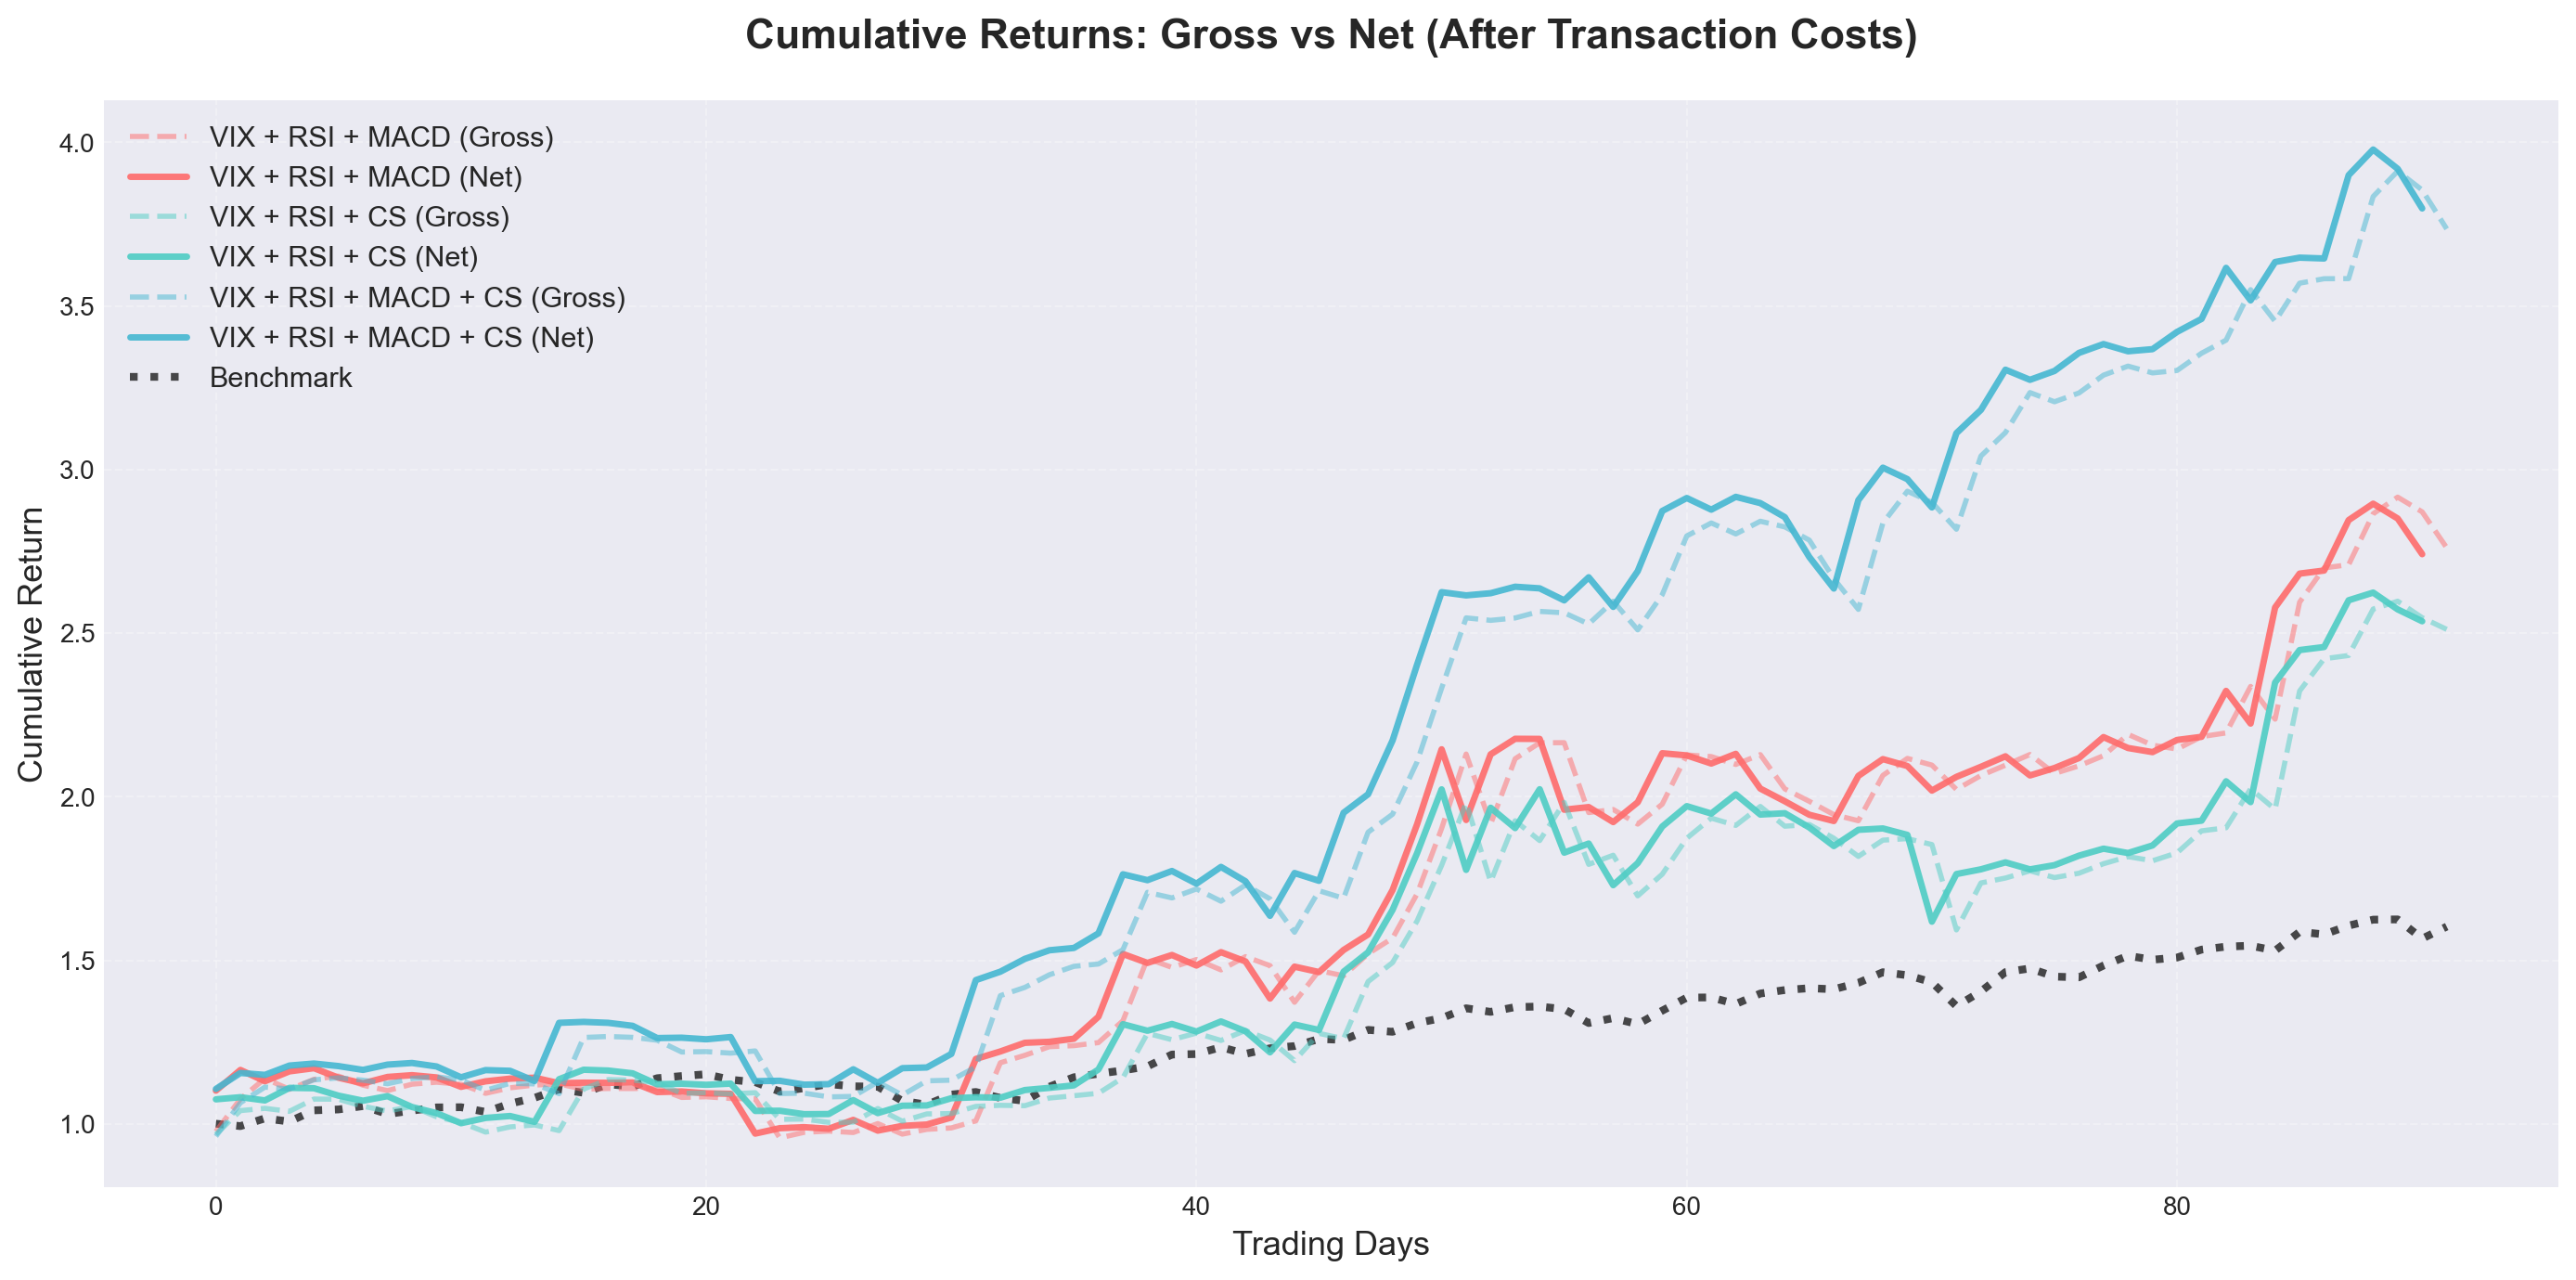

In [37]:
# Chart 1: Cumulative Returns - Gross vs Net (After Transaction Costs)

fig, ax = plt.subplots(figsize=(14, 7))

for model_file, result in results.items():
    config = result['config']
    # Gross returns
    ax.plot(result['cumulative'], 
            label=f"{config['name']} (Gross)", 
            linewidth=2, color=config['color'], alpha=0.5, linestyle='--')
    # Net returns
    ax.plot(turnover_results[model_file]['net_cumulative'],
            label=f"{config['name']} (Net)",
            linewidth=2.5, color=config['color'], alpha=0.9)

ax.plot(benchmark_cumulative, label='Benchmark', 
        linewidth=3, color='black', linestyle=':', alpha=0.7, zorder=1)

ax.set_title('Cumulative Returns: Gross vs Net (After Transaction Costs)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days', fontsize=13)
ax.set_ylabel('Cumulative Return', fontsize=13)
ax.legend(fontsize=11, loc='upper left', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

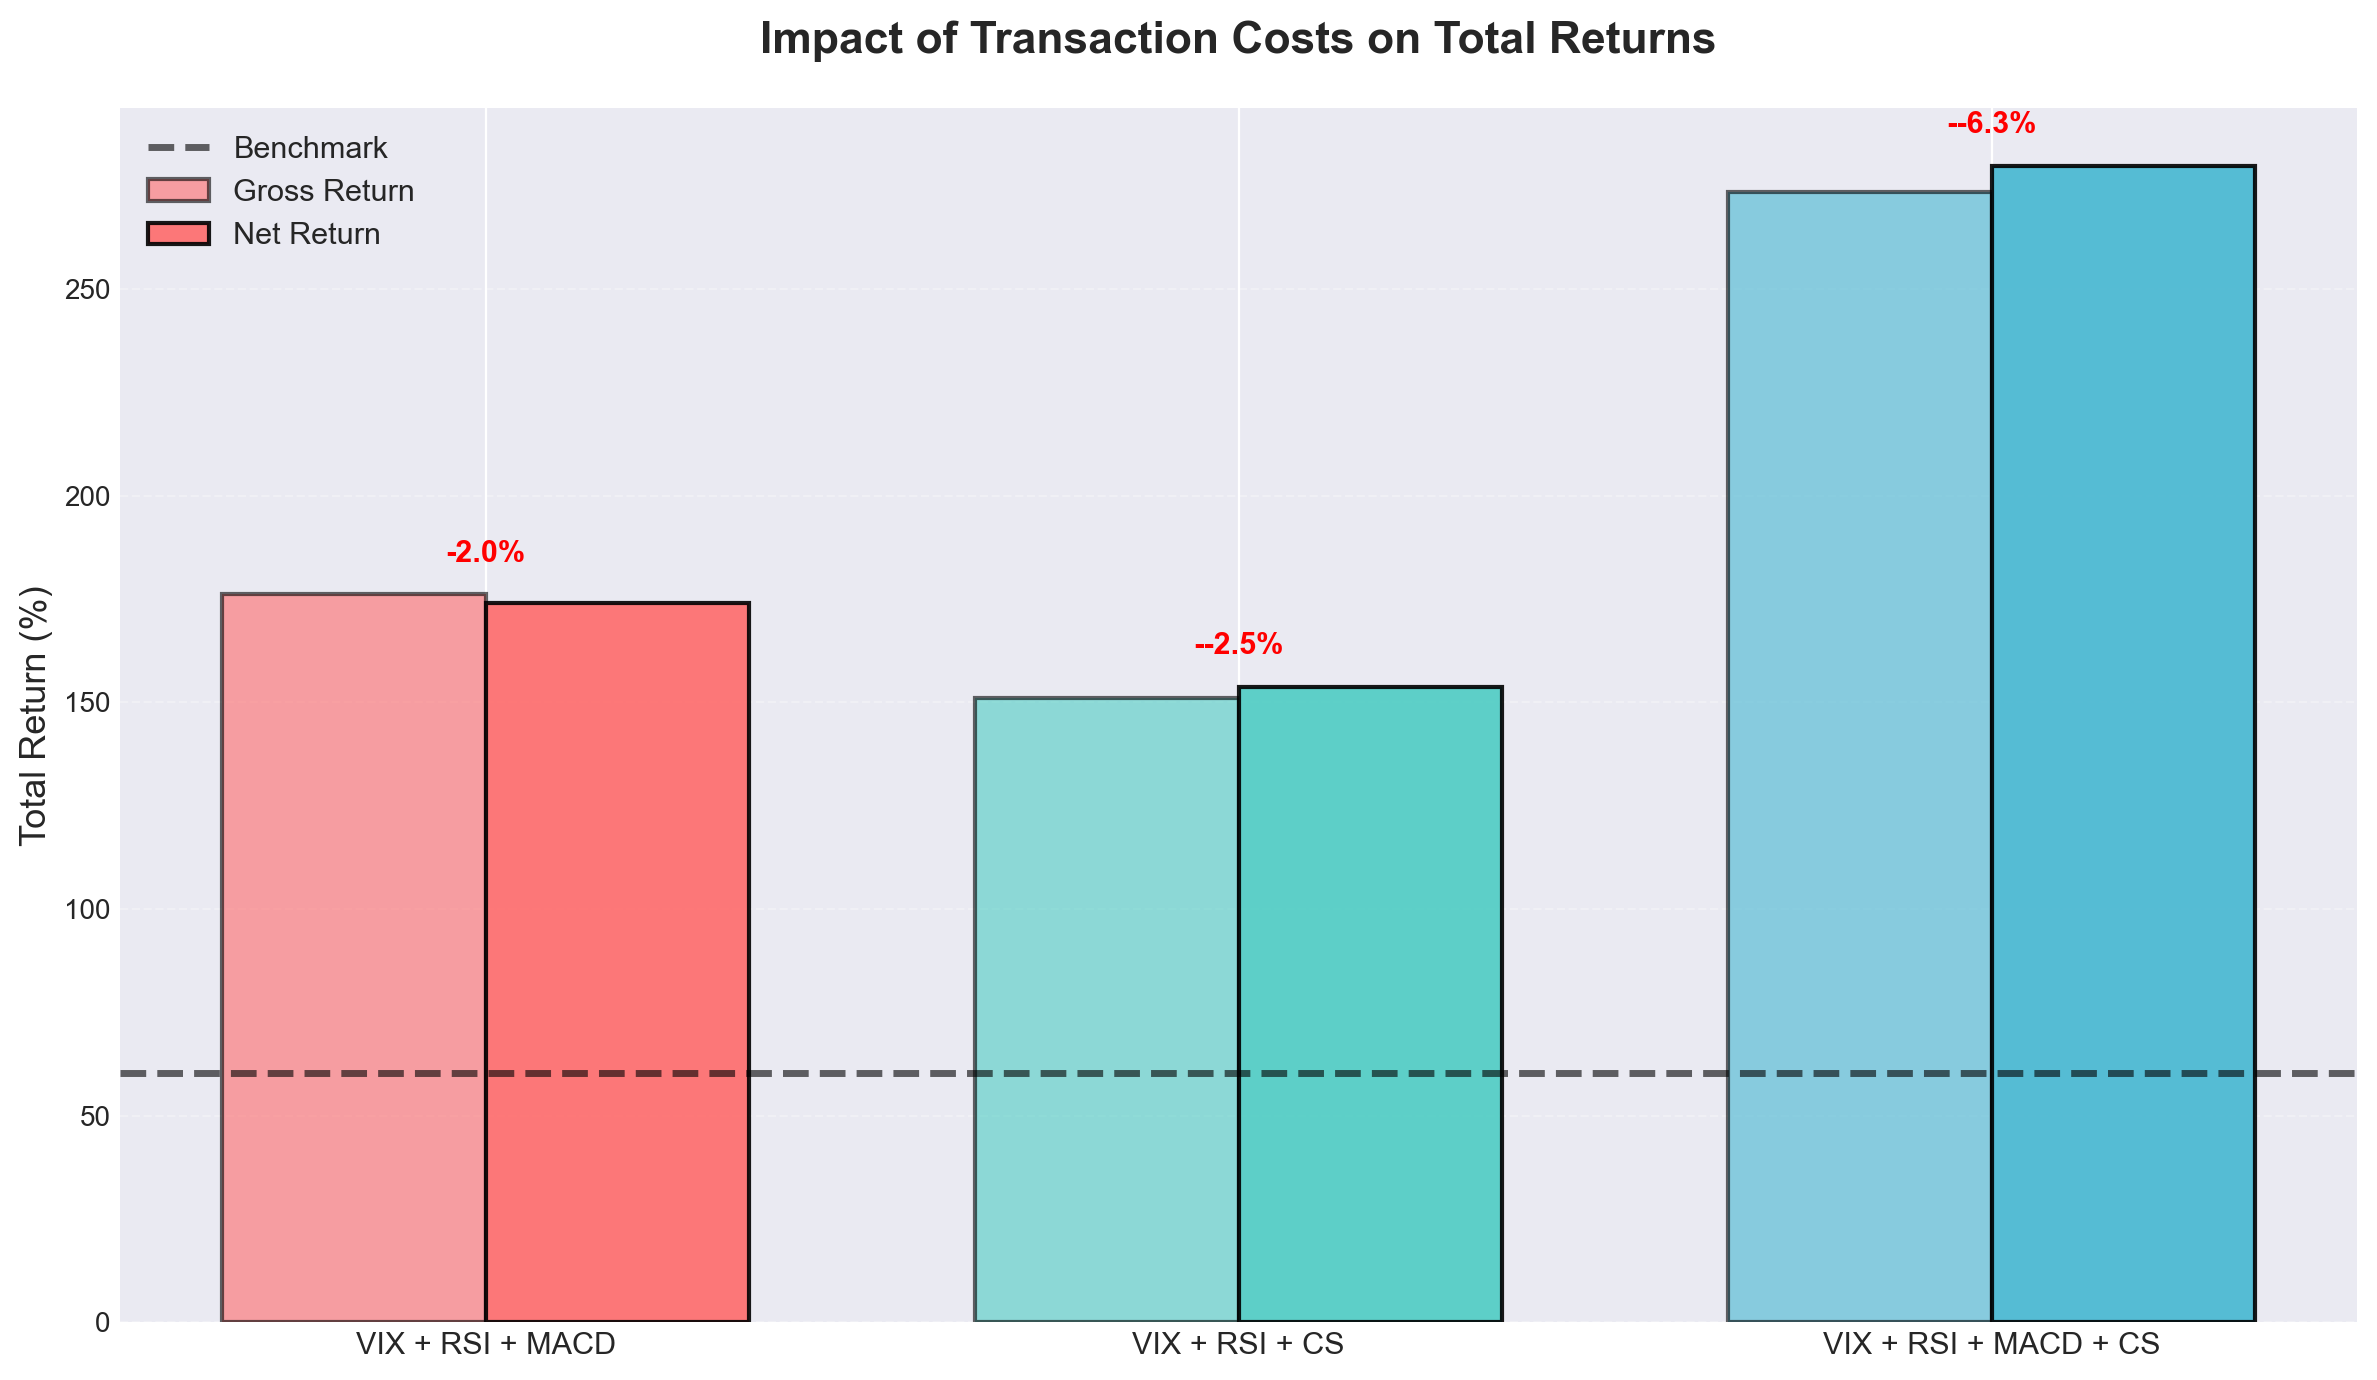

In [38]:
# Chart 2: Impact of Transaction Costs on Total Returns

fig, ax = plt.subplots(figsize=(12, 7))

model_names = [results[mf]['config']['name'] for mf in results.keys()]
gross_returns = [results[mf]['total_return']*100 for mf in results.keys()]
net_returns = [turnover_results[mf]['net_total_return']*100 for mf in results.keys()]
cost_impacts = [g - n for g, n in zip(gross_returns, net_returns)]
colors = [results[mf]['config']['color'] for mf in results.keys()]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, gross_returns, width, label='Gross Return', 
               color=colors, alpha=0.6, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, net_returns, width, label='Net Return',
               color=colors, alpha=0.9, edgecolor='black', linewidth=1.5)

# Add cost impact as text
for i, (g, n, c) in enumerate(zip(gross_returns, net_returns, cost_impacts)):
    ax.text(i, max(g, n) + 8, f'-{c:.1f}%', ha='center', fontsize=11, 
            color='red', fontweight='bold')

ax.axhline(y=benchmark_total_return*100, color='black', linestyle='--', 
           linewidth=2.5, alpha=0.6, label='Benchmark', zorder=1)

ax.set_title('Impact of Transaction Costs on Total Returns', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Total Return (%)', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=11)
ax.legend(fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

/var/folders/3v/2yw6c8qx0n55dsz1fdnrlrm80000gn/T/ipykernel_5587/3422966181.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, fontsize=11)


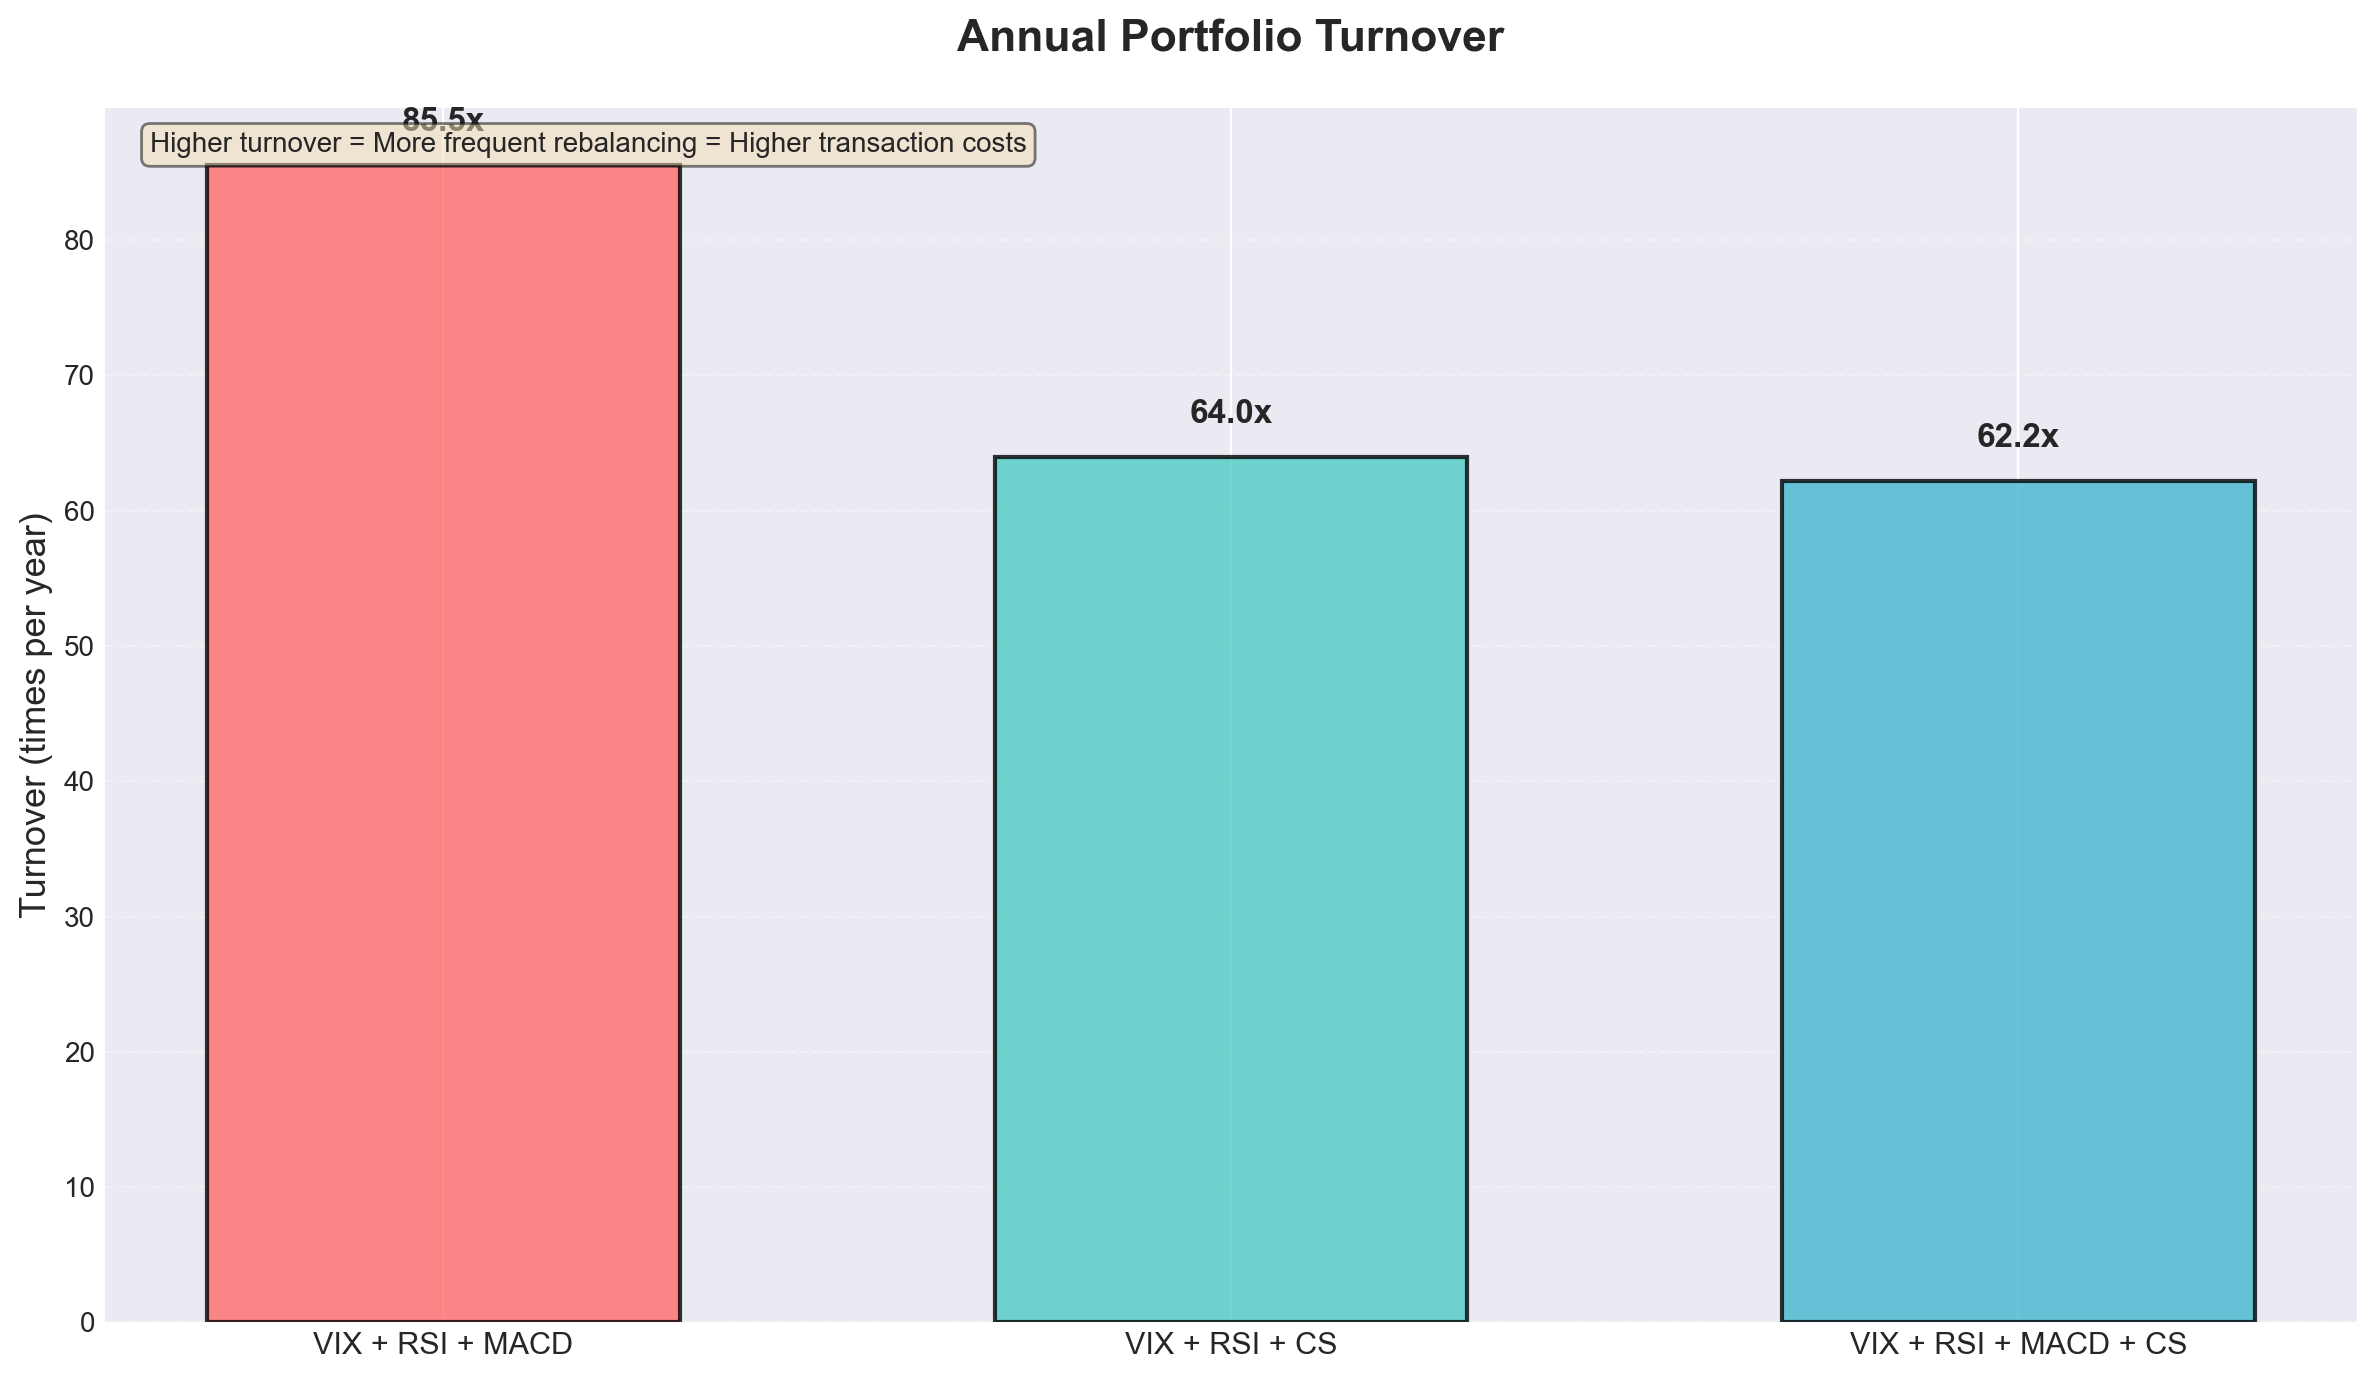

In [39]:
# Chart 3: Annual Portfolio Turnover

fig, ax = plt.subplots(figsize=(12, 7))

model_names = [results[mf]['config']['name'] for mf in results.keys()]
turnovers = [turnover_results[mf]['annualized_turnover'] for mf in results.keys()]
colors = [results[mf]['config']['color'] for mf in results.keys()]

bars = ax.bar(model_names, turnovers, color=colors, alpha=0.8, 
              edgecolor='black', linewidth=1.5, width=0.6)

ax.set_title('Annual Portfolio Turnover', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Turnover (times per year)', fontsize=13)
ax.set_xticklabels(model_names, fontsize=11)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add turnover values on bars
for bar, turnover in zip(bars, turnovers):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{turnover:.1f}x', ha='center', va='bottom', 
            fontsize=12, fontweight='bold')

# Add interpretation text
ax.text(0.02, 0.98, 
        'Higher turnover = More frequent rebalancing = Higher transaction costs',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

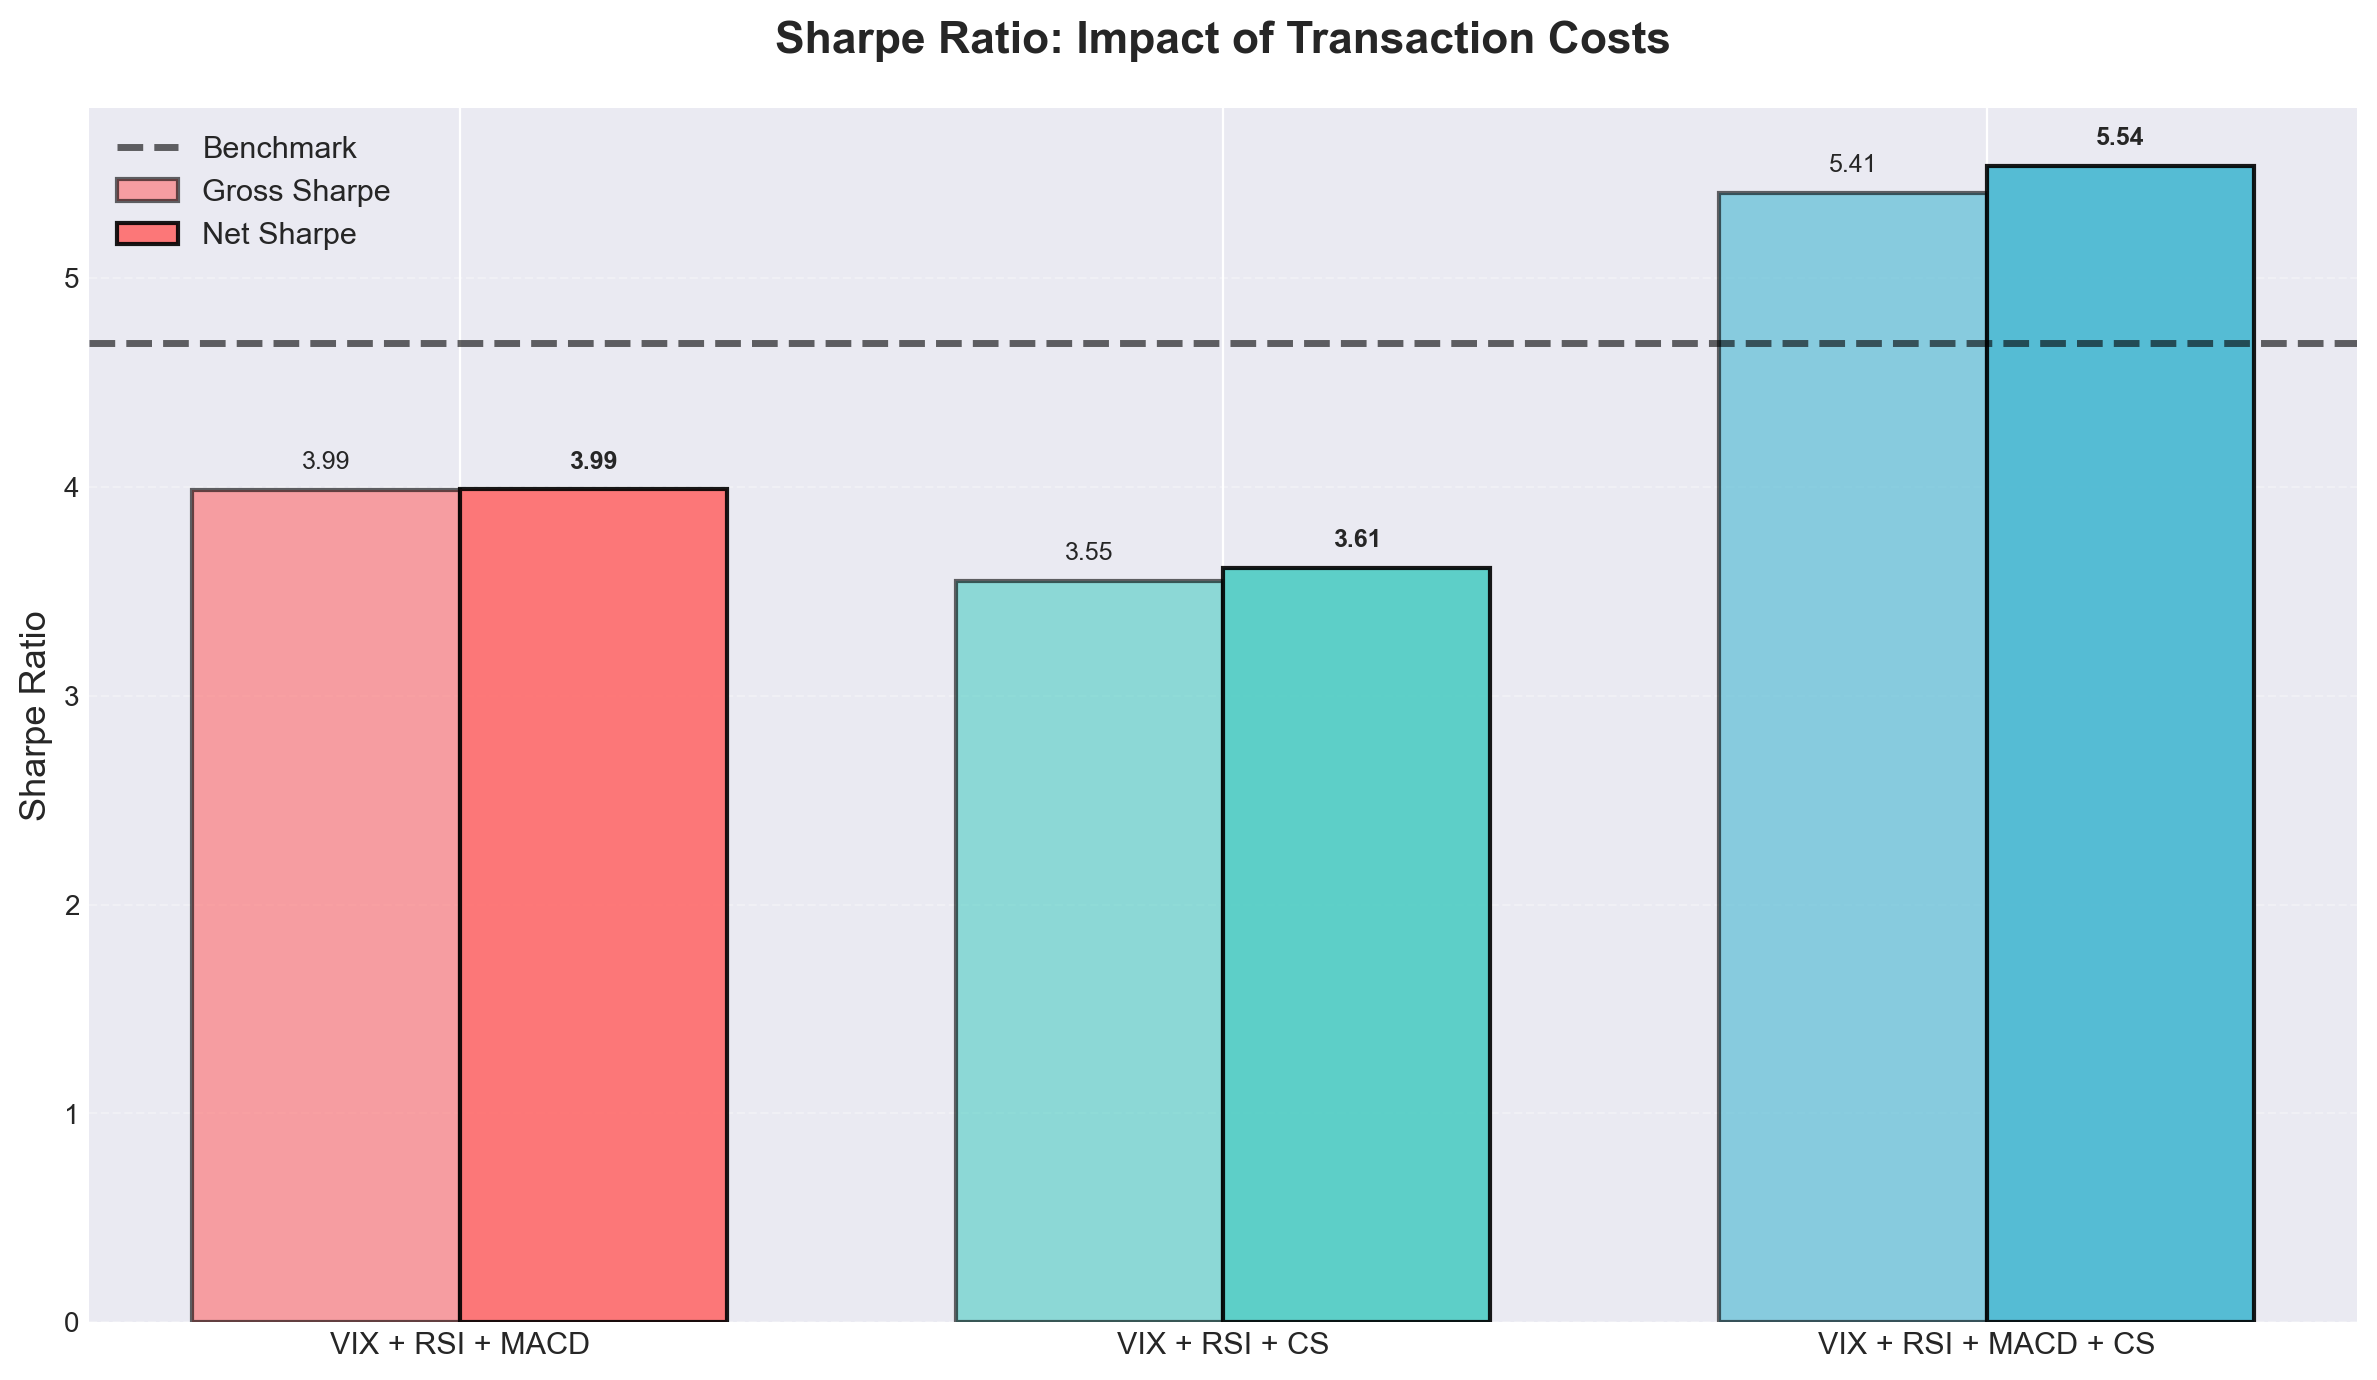

In [40]:
# Chart 4: Sharpe Ratio - Impact of Transaction Costs

fig, ax = plt.subplots(figsize=(12, 7))

model_names = [results[mf]['config']['name'] for mf in results.keys()]
gross_sharpes = [results[mf]['sharpe'] for mf in results.keys()]
net_sharpes = [turnover_results[mf]['net_sharpe'] for mf in results.keys()]
colors = [results[mf]['config']['color'] for mf in results.keys()]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, gross_sharpes, width, label='Gross Sharpe',
               color=colors, alpha=0.6, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, net_sharpes, width, label='Net Sharpe',
               color=colors, alpha=0.9, edgecolor='black', linewidth=1.5)

ax.axhline(y=benchmark_sharpe, color='black', linestyle='--',
           linewidth=2.5, alpha=0.6, label='Benchmark', zorder=1)

ax.set_title('Sharpe Ratio: Impact of Transaction Costs',
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Sharpe Ratio', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=11)
ax.legend(fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add value labels on bars
for i, (g, n) in enumerate(zip(gross_sharpes, net_sharpes)):
    ax.text(i - width/2, g + 0.1, f'{g:.2f}', ha='center', fontsize=9)
    ax.text(i + width/2, n + 0.1, f'{n:.2f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

### **Rolling Metrics**

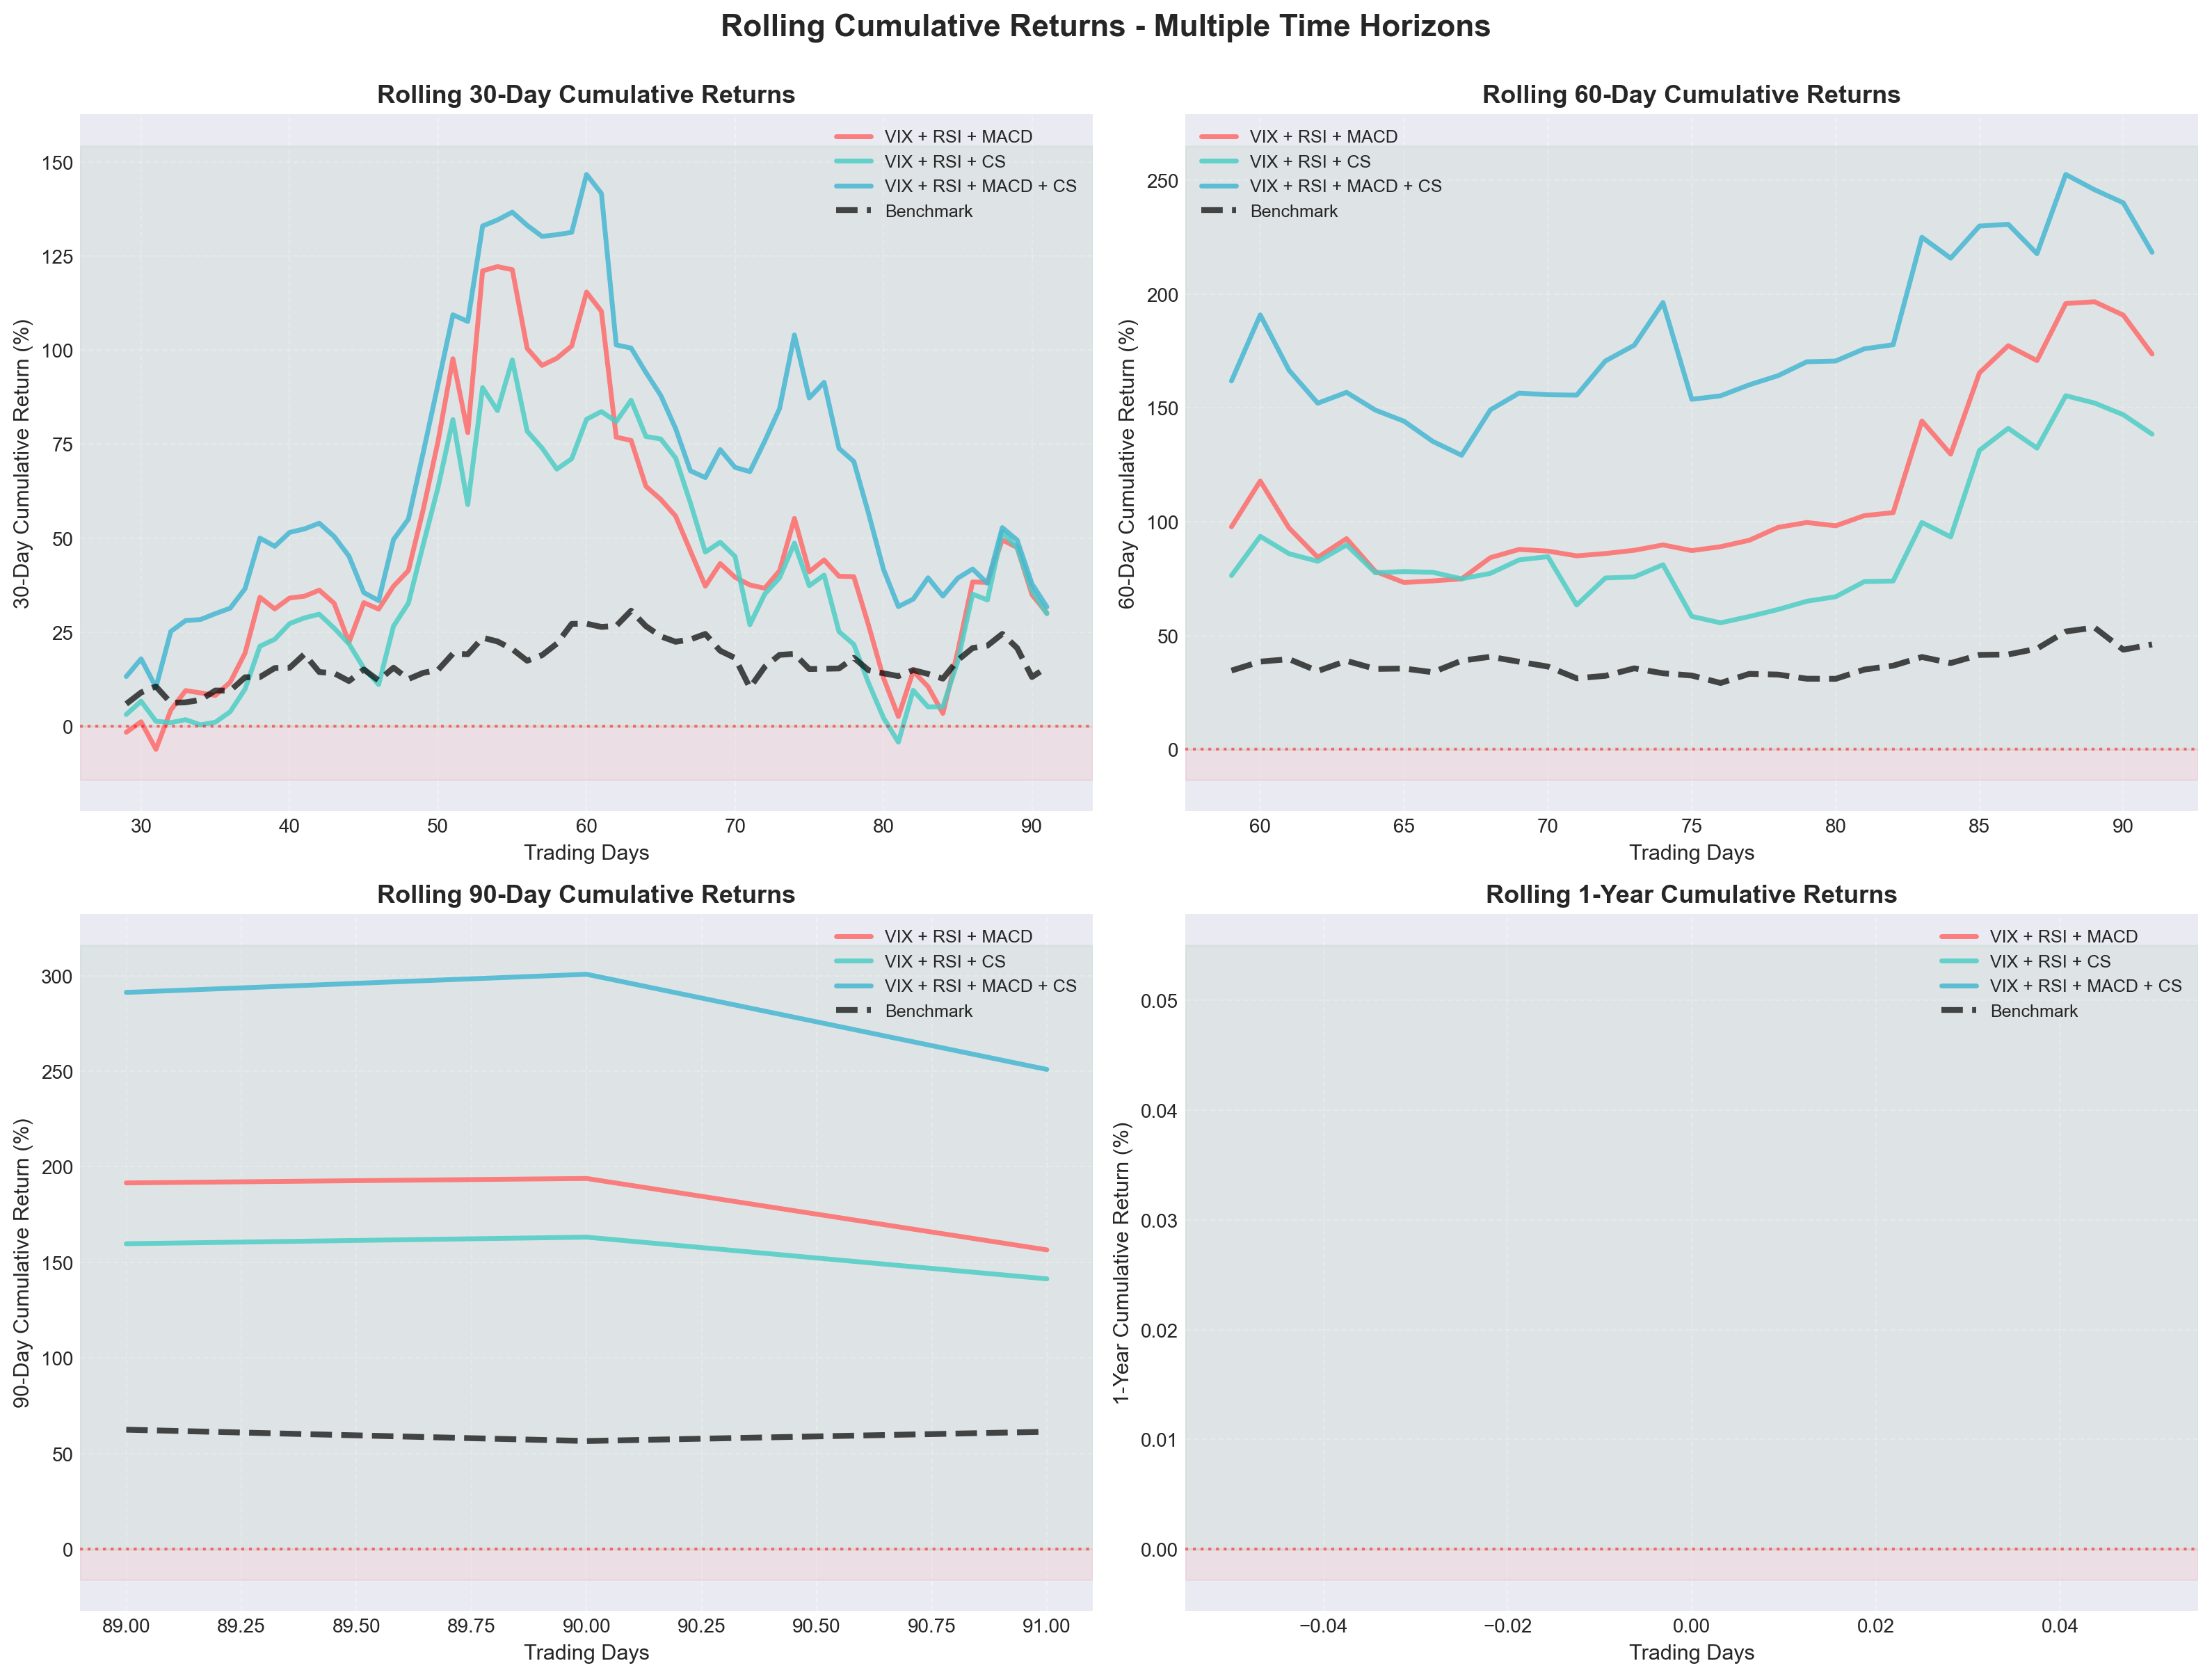

In [50]:
# Rolling Metrics Chart 6: Rolling Cumulative Returns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

windows = [30, 60, 90, 252]  # 30-day, 60-day, 90-day, 1-year
window_labels = ['30-Day', '60-Day', '90-Day', '1-Year']

for idx, (window, label) in enumerate(zip(windows, window_labels)):
    ax = axes[idx // 2, idx % 2]
    
    # Calculate and plot rolling cumulative returns for all models
    for model_file, result in results.items():
        config = result['config']
        # Rolling cumulative return
        rolling_cumulative = pd.Series(result['rewards']).rolling(window).apply(
            lambda x: (np.prod(1 + x) - 1) * 100, raw=True)
        ax.plot(rolling_cumulative, label=config['name'], 
                linewidth=2.5, color=config['color'], alpha=0.85)
    
    # Benchmark rolling cumulative returns
    benchmark_rolling_cumulative = pd.Series(benchmark_rewards).rolling(window).apply(
        lambda x: (np.prod(1 + x) - 1) * 100, raw=True)
    ax.plot(benchmark_rolling_cumulative, label='Benchmark', 
            linewidth=3, color='black', linestyle='--', alpha=0.7)
    
    ax.axhline(y=0, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
    ax.set_title(f'Rolling {label} Cumulative Returns', 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Trading Days', fontsize=11)
    ax.set_ylabel(f'{label} Cumulative Return (%)', fontsize=11)
    ax.legend(fontsize=9, loc='best', framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add shaded area for positive/negative zones
    ax.axhspan(0, ax.get_ylim()[1], alpha=0.05, color='green')
    ax.axhspan(ax.get_ylim()[0], 0, alpha=0.05, color='red')

plt.suptitle('Rolling Cumulative Returns - Multiple Time Horizons', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

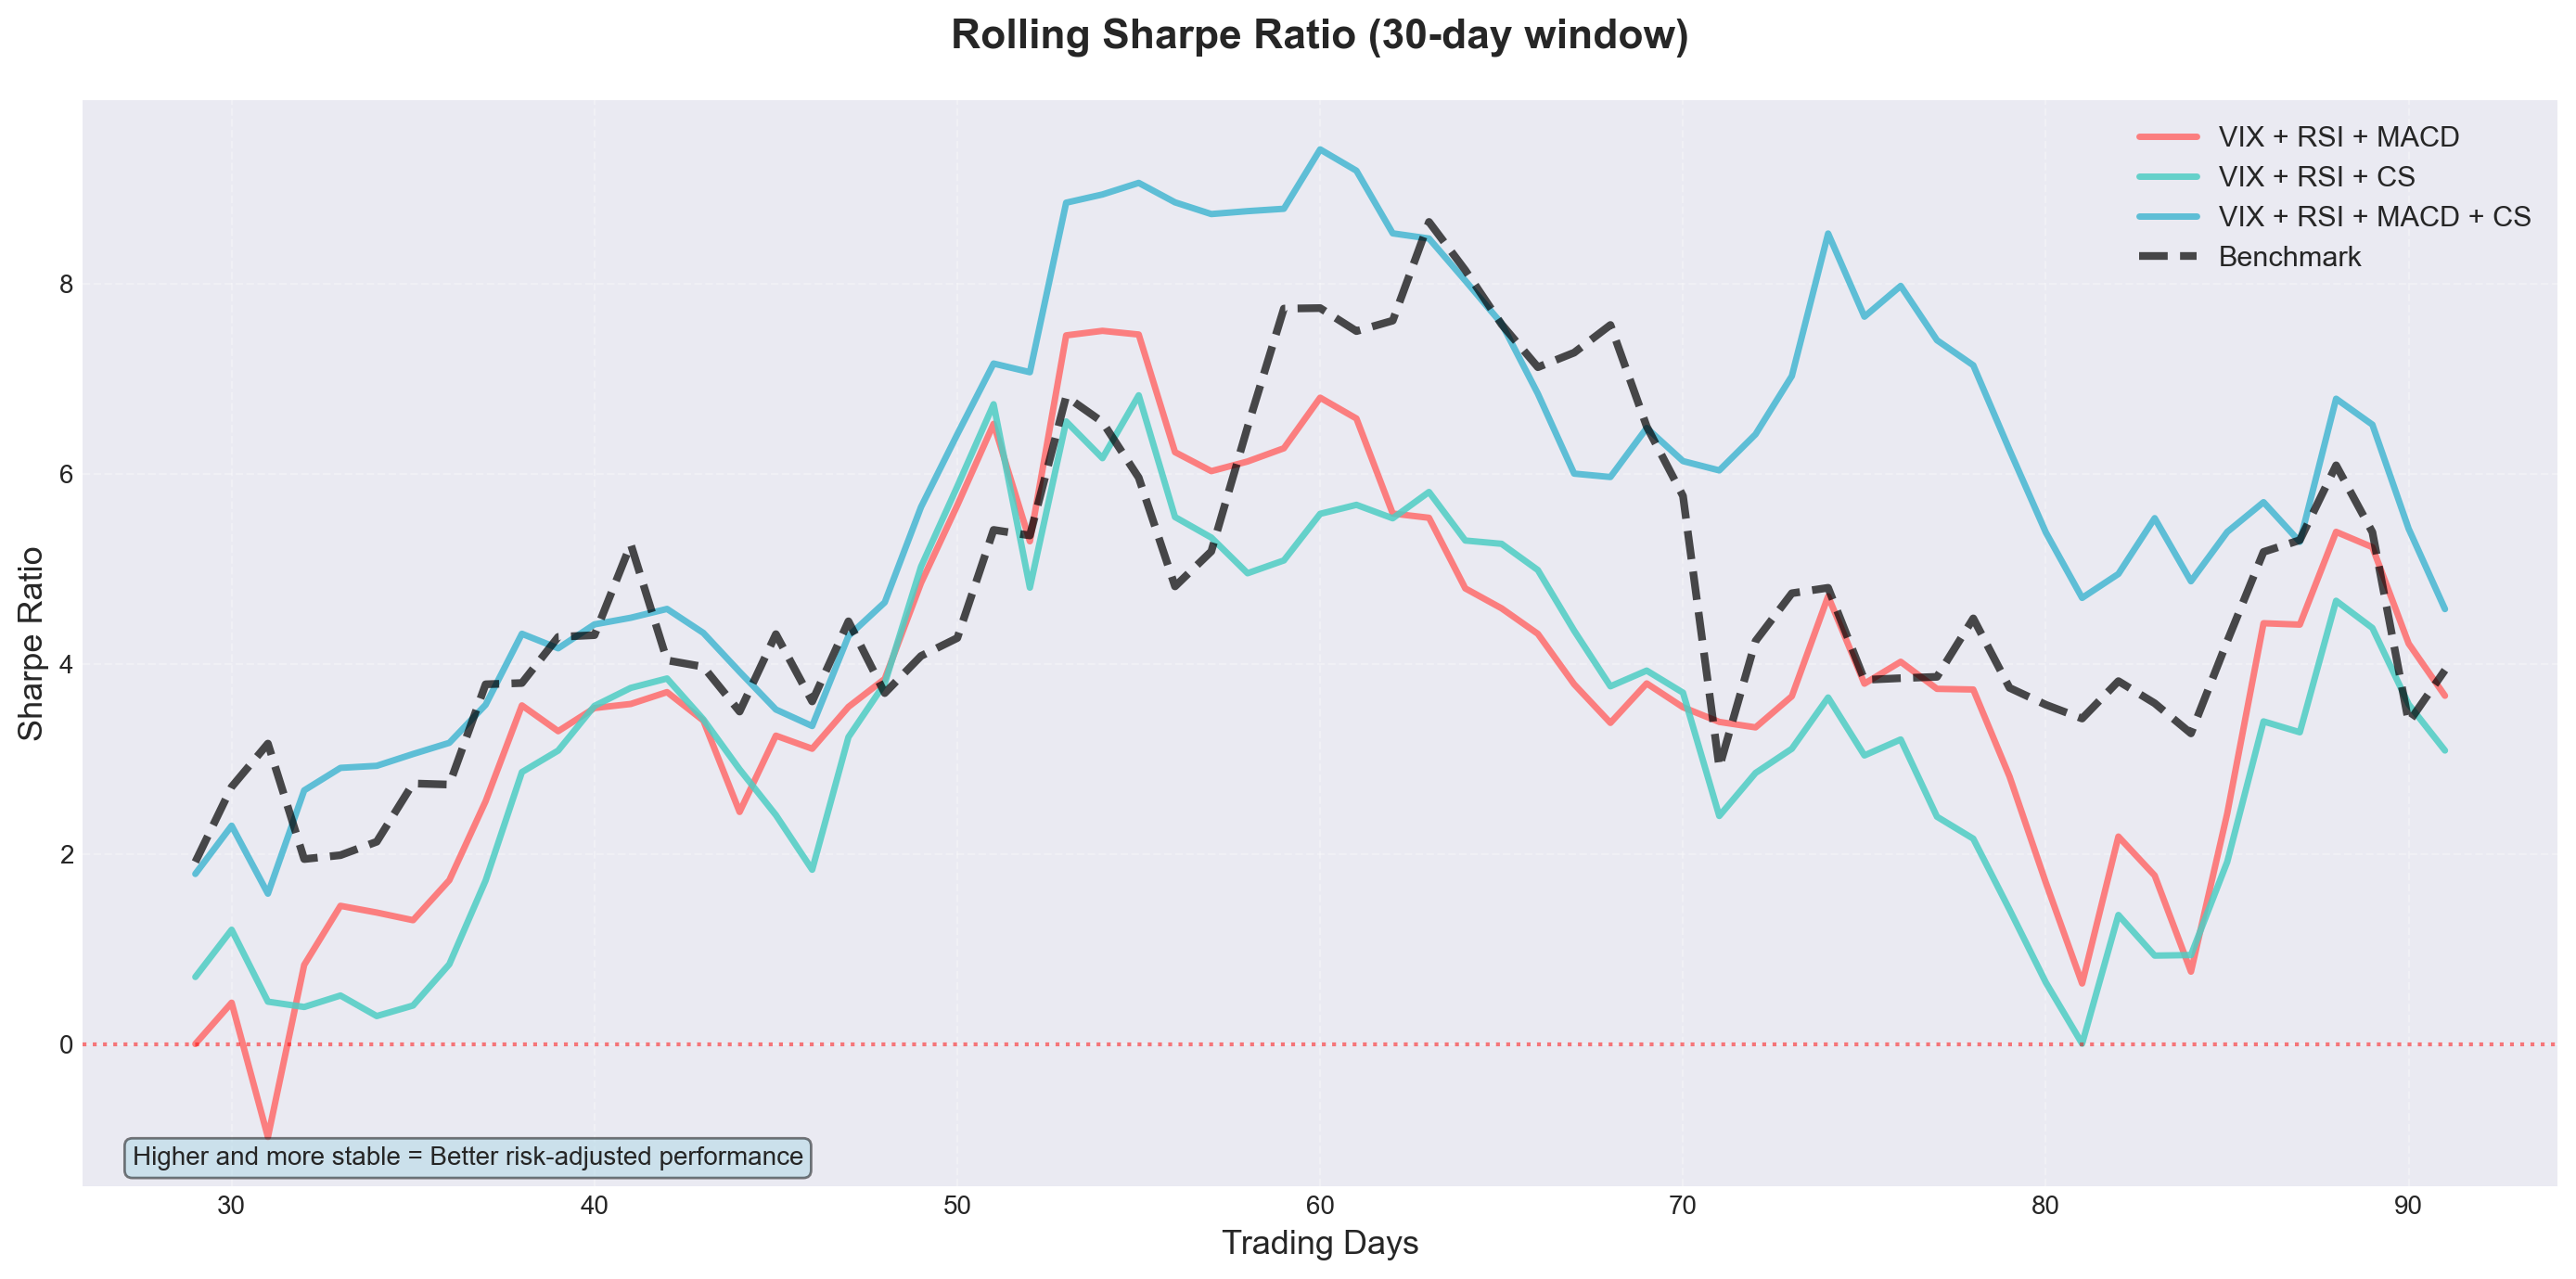


Average Rolling Sharpe Ratio (30-day):
--------------------------------------------------
VIX + RSI + MACD          Mean:   3.78  Std:   1.91
VIX + RSI + CS            Mean:   3.34  Std:   1.86
VIX + RSI + MACD + CS     Mean:   5.88  Std:   2.09
Benchmark                 Mean:   4.76  Std:   1.70


In [42]:
# Rolling Metrics Chart 1: Rolling Sharpe Ratio

fig, ax = plt.subplots(figsize=(14, 7))

window = 30  # 30-day rolling window

# Calculate and plot rolling Sharpe for all models
for model_file, result in results.items():
    config = result['config']
    rolling_sharpe = (pd.Series(result['rewards']).rolling(window).mean() / 
                     pd.Series(result['rewards']).rolling(window).std() * np.sqrt(252))
    ax.plot(rolling_sharpe, label=config['name'], 
            linewidth=2.5, color=config['color'], alpha=0.85)

# Benchmark rolling Sharpe
benchmark_rolling_sharpe = (pd.Series(benchmark_rewards).rolling(window).mean() / 
                           pd.Series(benchmark_rewards).rolling(window).std() * np.sqrt(252))
ax.plot(benchmark_rolling_sharpe, label='Benchmark', 
        linewidth=3, color='black', linestyle='--', alpha=0.7)

ax.axhline(y=0, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax.set_title(f'Rolling Sharpe Ratio ({window}-day window)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days', fontsize=13)
ax.set_ylabel('Sharpe Ratio', fontsize=13)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Add interpretation text
ax.text(0.02, 0.02, 
        'Higher and more stable = Better risk-adjusted performance',
        transform=ax.transAxes, fontsize=10,
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

# Print average rolling Sharpe
print("\nAverage Rolling Sharpe Ratio (30-day):")
print("-" * 50)
for model_file, result in results.items():
    config = result['config']
    rolling_sharpe = (pd.Series(result['rewards']).rolling(window).mean() / 
                     pd.Series(result['rewards']).rolling(window).std() * np.sqrt(252))
    avg_rolling = rolling_sharpe.dropna().mean()
    std_rolling = rolling_sharpe.dropna().std()
    print(f"{config['name']:<25} Mean: {avg_rolling:>6.2f}  Std: {std_rolling:>6.2f}")

avg_bench_rolling = benchmark_rolling_sharpe.dropna().mean()
std_bench_rolling = benchmark_rolling_sharpe.dropna().std()  # ← FIXED: was cut off
print(f"{'Benchmark':<25} Mean: {avg_bench_rolling:>6.2f}  Std: {std_bench_rolling:>6.2f}")

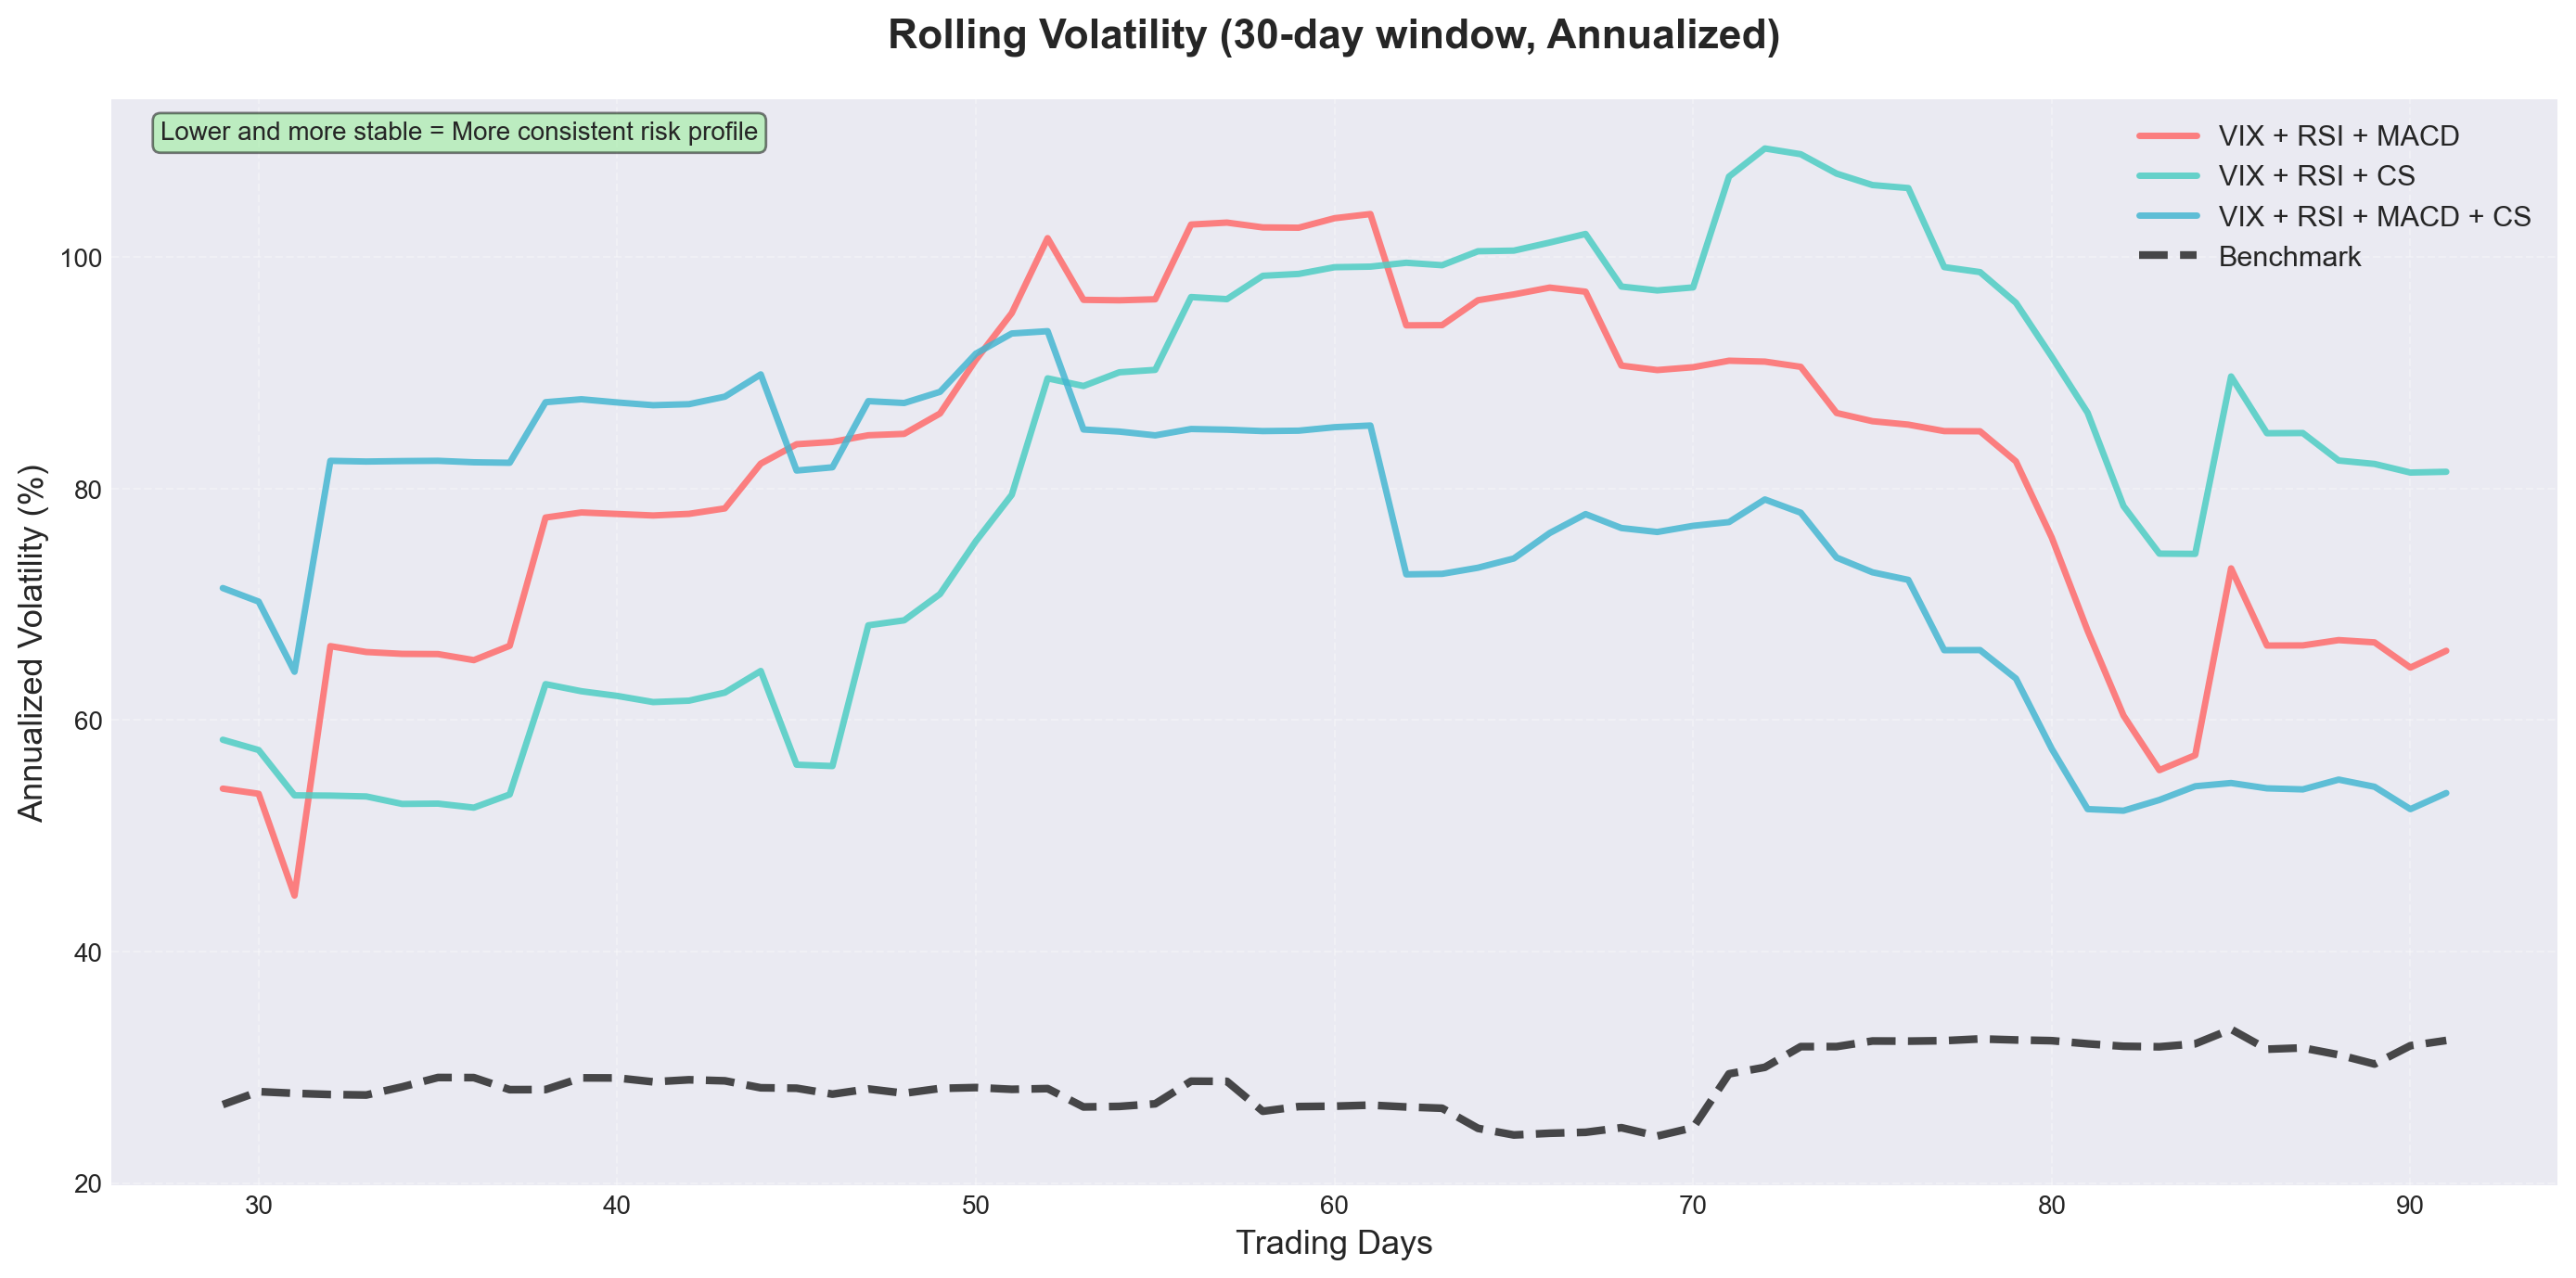


Rolling Volatility Statistics (30-day, Annualized %):
----------------------------------------------------------------------
Model                         Mean      Min      Max      Std
----------------------------------------------------------------------
VIX + RSI + MACD            81.46%   44.84%  103.72%   14.95%
VIX + RSI + CS              82.10%   52.44%  109.39%   18.44%
VIX + RSI + MACD + CS       75.52%   52.17%   93.60%   12.57%
Benchmark                   28.77%   24.07%   33.29%    2.51%


In [43]:
# Rolling Metrics Chart 2: Rolling Volatility

fig, ax = plt.subplots(figsize=(14, 7))

window = 30  # 30-day rolling window

# Calculate and plot rolling volatility for all models
for model_file, result in results.items():
    config = result['config']
    rolling_vol = pd.Series(result['rewards']).rolling(window).std() * np.sqrt(252) * 100
    ax.plot(rolling_vol, label=config['name'], 
            linewidth=2.5, color=config['color'], alpha=0.85)

# Benchmark rolling volatility
benchmark_rolling_vol = pd.Series(benchmark_rewards).rolling(window).std() * np.sqrt(252) * 100
ax.plot(benchmark_rolling_vol, label='Benchmark', 
        linewidth=3, color='black', linestyle='--', alpha=0.7)

ax.set_title(f'Rolling Volatility ({window}-day window, Annualized)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days', fontsize=13)
ax.set_ylabel('Annualized Volatility (%)', fontsize=13)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Add interpretation text
ax.text(0.02, 0.98, 
        'Lower and more stable = More consistent risk profile',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

# Print volatility statistics
print("\nRolling Volatility Statistics (30-day, Annualized %):")
print("-" * 70)
print(f"{'Model':<25} {'Mean':>8} {'Min':>8} {'Max':>8} {'Std':>8}")
print("-" * 70)
for model_file, result in results.items():
    config = result['config']
    rolling_vol = pd.Series(result['rewards']).rolling(window).std() * np.sqrt(252) * 100
    stats = rolling_vol.dropna()
    print(f"{config['name']:<25} {stats.mean():>7.2f}% {stats.min():>7.2f}% {stats.max():>7.2f}% {stats.std():>7.2f}%")

benchmark_stats = benchmark_rolling_vol.dropna()
print(f"{'Benchmark':<25} {benchmark_stats.mean():>7.2f}% {benchmark_stats.min():>7.2f}% {benchmark_stats.max():>7.2f}% {benchmark_stats.std():>7.2f}%")

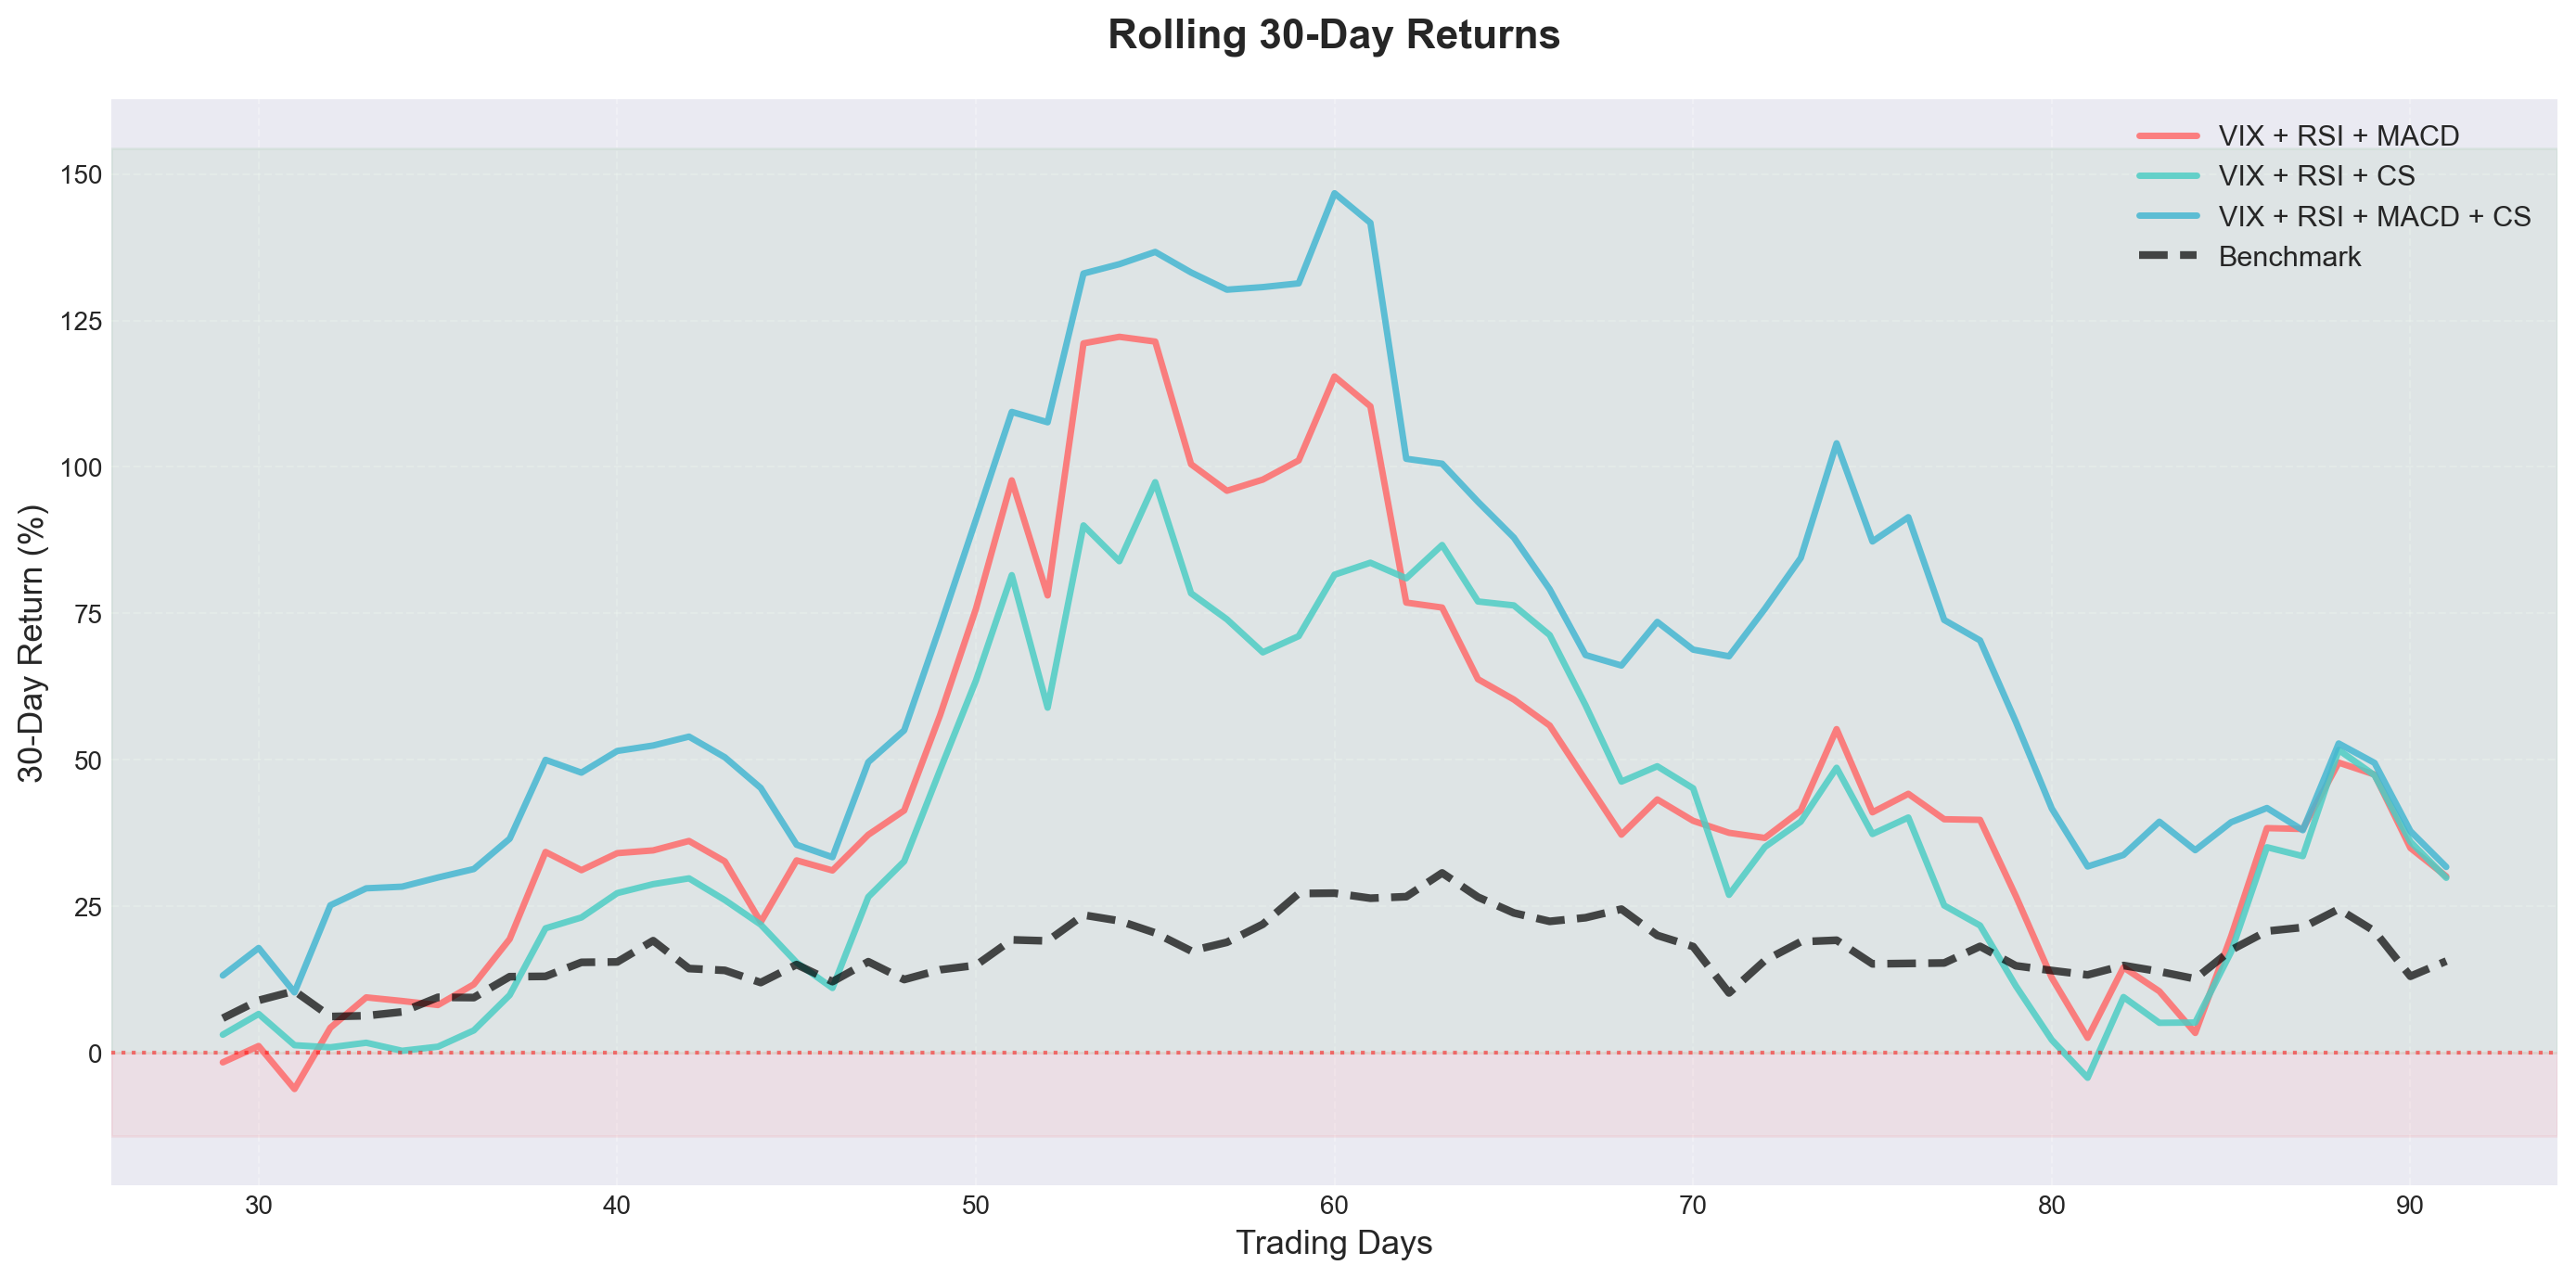


Rolling 30-Day Return Statistics:
----------------------------------------------------------------------
Model                         Mean   Median      Min      Max   % Positive
----------------------------------------------------------------------
VIX + RSI + MACD            45.72%   38.17%   -6.24%  122.22%        96.8%
VIX + RSI + CS              38.38%   33.53%   -4.32%   97.39%        98.4%
VIX + RSI + MACD + CS       67.72%   55.01%   10.26%  146.74%       100.0%
Benchmark                   16.94%   15.50%    5.86%   30.66%       100.0%


In [44]:
# Rolling Metrics Chart 3: Rolling 30-Day Returns

fig, ax = plt.subplots(figsize=(14, 7))

window = 30  # 30-day rolling window

# Calculate and plot rolling returns for all models
for model_file, result in results.items():
    config = result['config']
    # Rolling 30-day cumulative return
    rolling_return = pd.Series(result['rewards']).rolling(window).apply(
        lambda x: (np.prod(1 + x) - 1) * 100, raw=True)
    ax.plot(rolling_return, label=config['name'], 
            linewidth=2.5, color=config['color'], alpha=0.85)

# Benchmark rolling returns
benchmark_rolling_return = pd.Series(benchmark_rewards).rolling(window).apply(
    lambda x: (np.prod(1 + x) - 1) * 100, raw=True)
ax.plot(benchmark_rolling_return, label='Benchmark', 
        linewidth=3, color='black', linestyle='--', alpha=0.7)

ax.axhline(y=0, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax.set_title(f'Rolling {window}-Day Returns', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days', fontsize=13)
ax.set_ylabel(f'{window}-Day Return (%)', fontsize=13)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Add shaded area for positive/negative zones
ax.axhspan(0, ax.get_ylim()[1], alpha=0.05, color='green')
ax.axhspan(ax.get_ylim()[0], 0, alpha=0.05, color='red')

plt.tight_layout()
plt.show()

# Print rolling return statistics
print(f"\nRolling {window}-Day Return Statistics:")
print("-" * 70)
print(f"{'Model':<25} {'Mean':>8} {'Median':>8} {'Min':>8} {'Max':>8} {'% Positive':>12}")
print("-" * 70)
for model_file, result in results.items():
    config = result['config']
    rolling_return = pd.Series(result['rewards']).rolling(window).apply(
        lambda x: (np.prod(1 + x) - 1) * 100, raw=True)
    stats = rolling_return.dropna()
    pct_positive = (stats > 0).sum() / len(stats) * 100
    print(f"{config['name']:<25} {stats.mean():>7.2f}% {stats.median():>7.2f}% "
          f"{stats.min():>7.2f}% {stats.max():>7.2f}% {pct_positive:>11.1f}%")

benchmark_stats = benchmark_rolling_return.dropna()
benchmark_pct_positive = (benchmark_stats > 0).sum() / len(benchmark_stats) * 100
print(f"{'Benchmark':<25} {benchmark_stats.mean():>7.2f}% {benchmark_stats.median():>7.2f}% "
      f"{benchmark_stats.min():>7.2f}% {benchmark_stats.max():>7.2f}% {benchmark_pct_positive:>11.1f}%")

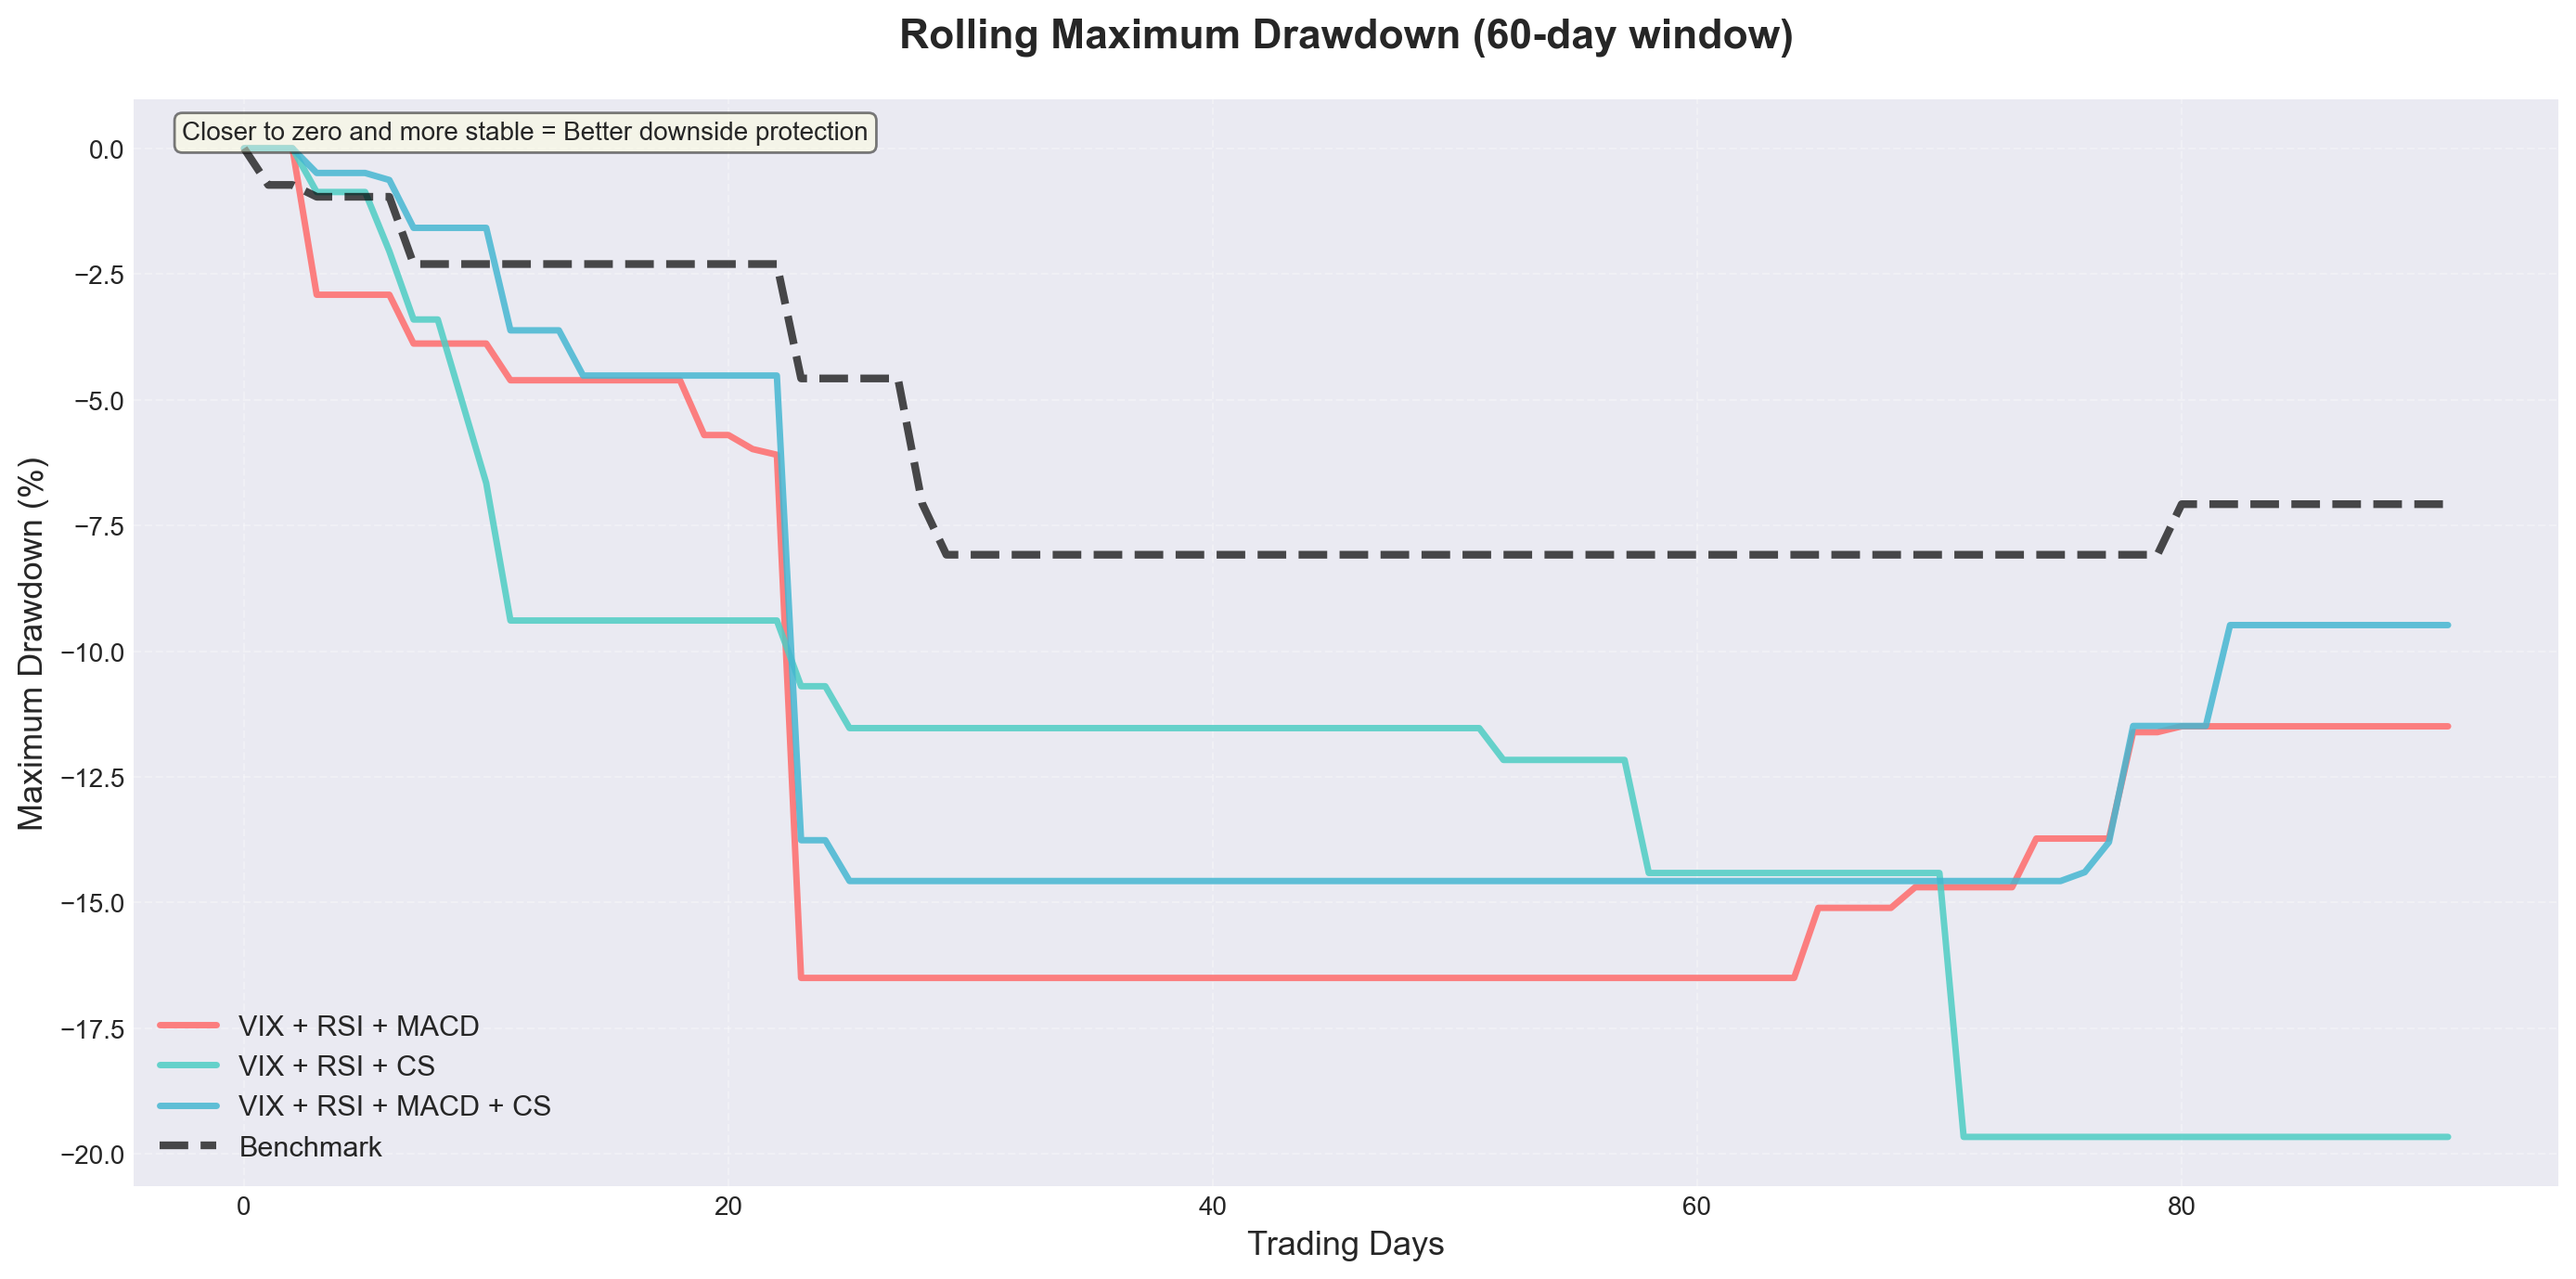


Rolling Maximum Drawdown Statistics (60-day window):
----------------------------------------------------------------------
Model                         Mean   Median     Best    Worst
----------------------------------------------------------------------
VIX + RSI + MACD           -12.29%  -14.90%    0.00%  -16.50%
VIX + RSI + CS             -12.41%  -11.53%    0.00%  -19.66%
VIX + RSI + MACD + CS      -10.86%  -14.57%    0.00%  -14.57%
Benchmark                   -6.19%   -8.08%    0.00%   -8.08%


In [45]:
# Rolling Metrics Chart 4: Rolling Maximum Drawdown

fig, ax = plt.subplots(figsize=(14, 7))

window = 60  # 60-day rolling window for drawdown

def rolling_max_drawdown(returns, window):
    """Calculate rolling maximum drawdown"""
    rolling_dd = []
    for i in range(len(returns)):
        if i < window:
            window_returns = returns[:i+1]
        else:
            window_returns = returns[i-window+1:i+1]
        
        cumulative = np.cumprod(1 + window_returns)
        running_max = np.maximum.accumulate(cumulative)
        drawdown = (cumulative - running_max) / running_max
        rolling_dd.append(np.min(drawdown) * 100)
    
    return np.array(rolling_dd)

# Calculate and plot rolling max drawdown for all models
for model_file, result in results.items():
    config = result['config']
    rolling_dd = rolling_max_drawdown(result['rewards'], window)
    ax.plot(rolling_dd, label=config['name'], 
            linewidth=2.5, color=config['color'], alpha=0.85)

# Benchmark rolling max drawdown
benchmark_rolling_dd = rolling_max_drawdown(benchmark_rewards, window)
ax.plot(benchmark_rolling_dd, label='Benchmark', 
        linewidth=3, color='black', linestyle='--', alpha=0.7)

ax.set_title(f'Rolling Maximum Drawdown ({window}-day window)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days', fontsize=13)
ax.set_ylabel('Maximum Drawdown (%)', fontsize=13)
ax.legend(fontsize=11, loc='lower left', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Add interpretation text
ax.text(0.02, 0.98, 
        'Closer to zero and more stable = Better downside protection',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

plt.tight_layout()
plt.show()

# Print rolling drawdown statistics
print(f"\nRolling Maximum Drawdown Statistics ({window}-day window):")
print("-" * 70)
print(f"{'Model':<25} {'Mean':>8} {'Median':>8} {'Best':>8} {'Worst':>8}")
print("-" * 70)
for model_file, result in results.items():
    config = result['config']
    rolling_dd = rolling_max_drawdown(result['rewards'], window)
    print(f"{config['name']:<25} {np.mean(rolling_dd):>7.2f}% {np.median(rolling_dd):>7.2f}% "
          f"{np.max(rolling_dd):>7.2f}% {np.min(rolling_dd):>7.2f}%")

print(f"{'Benchmark':<25} {np.mean(benchmark_rolling_dd):>7.2f}% {np.median(benchmark_rolling_dd):>7.2f}% "
      f"{np.max(benchmark_rolling_dd):>7.2f}% {np.min(benchmark_rolling_dd):>7.2f}%")

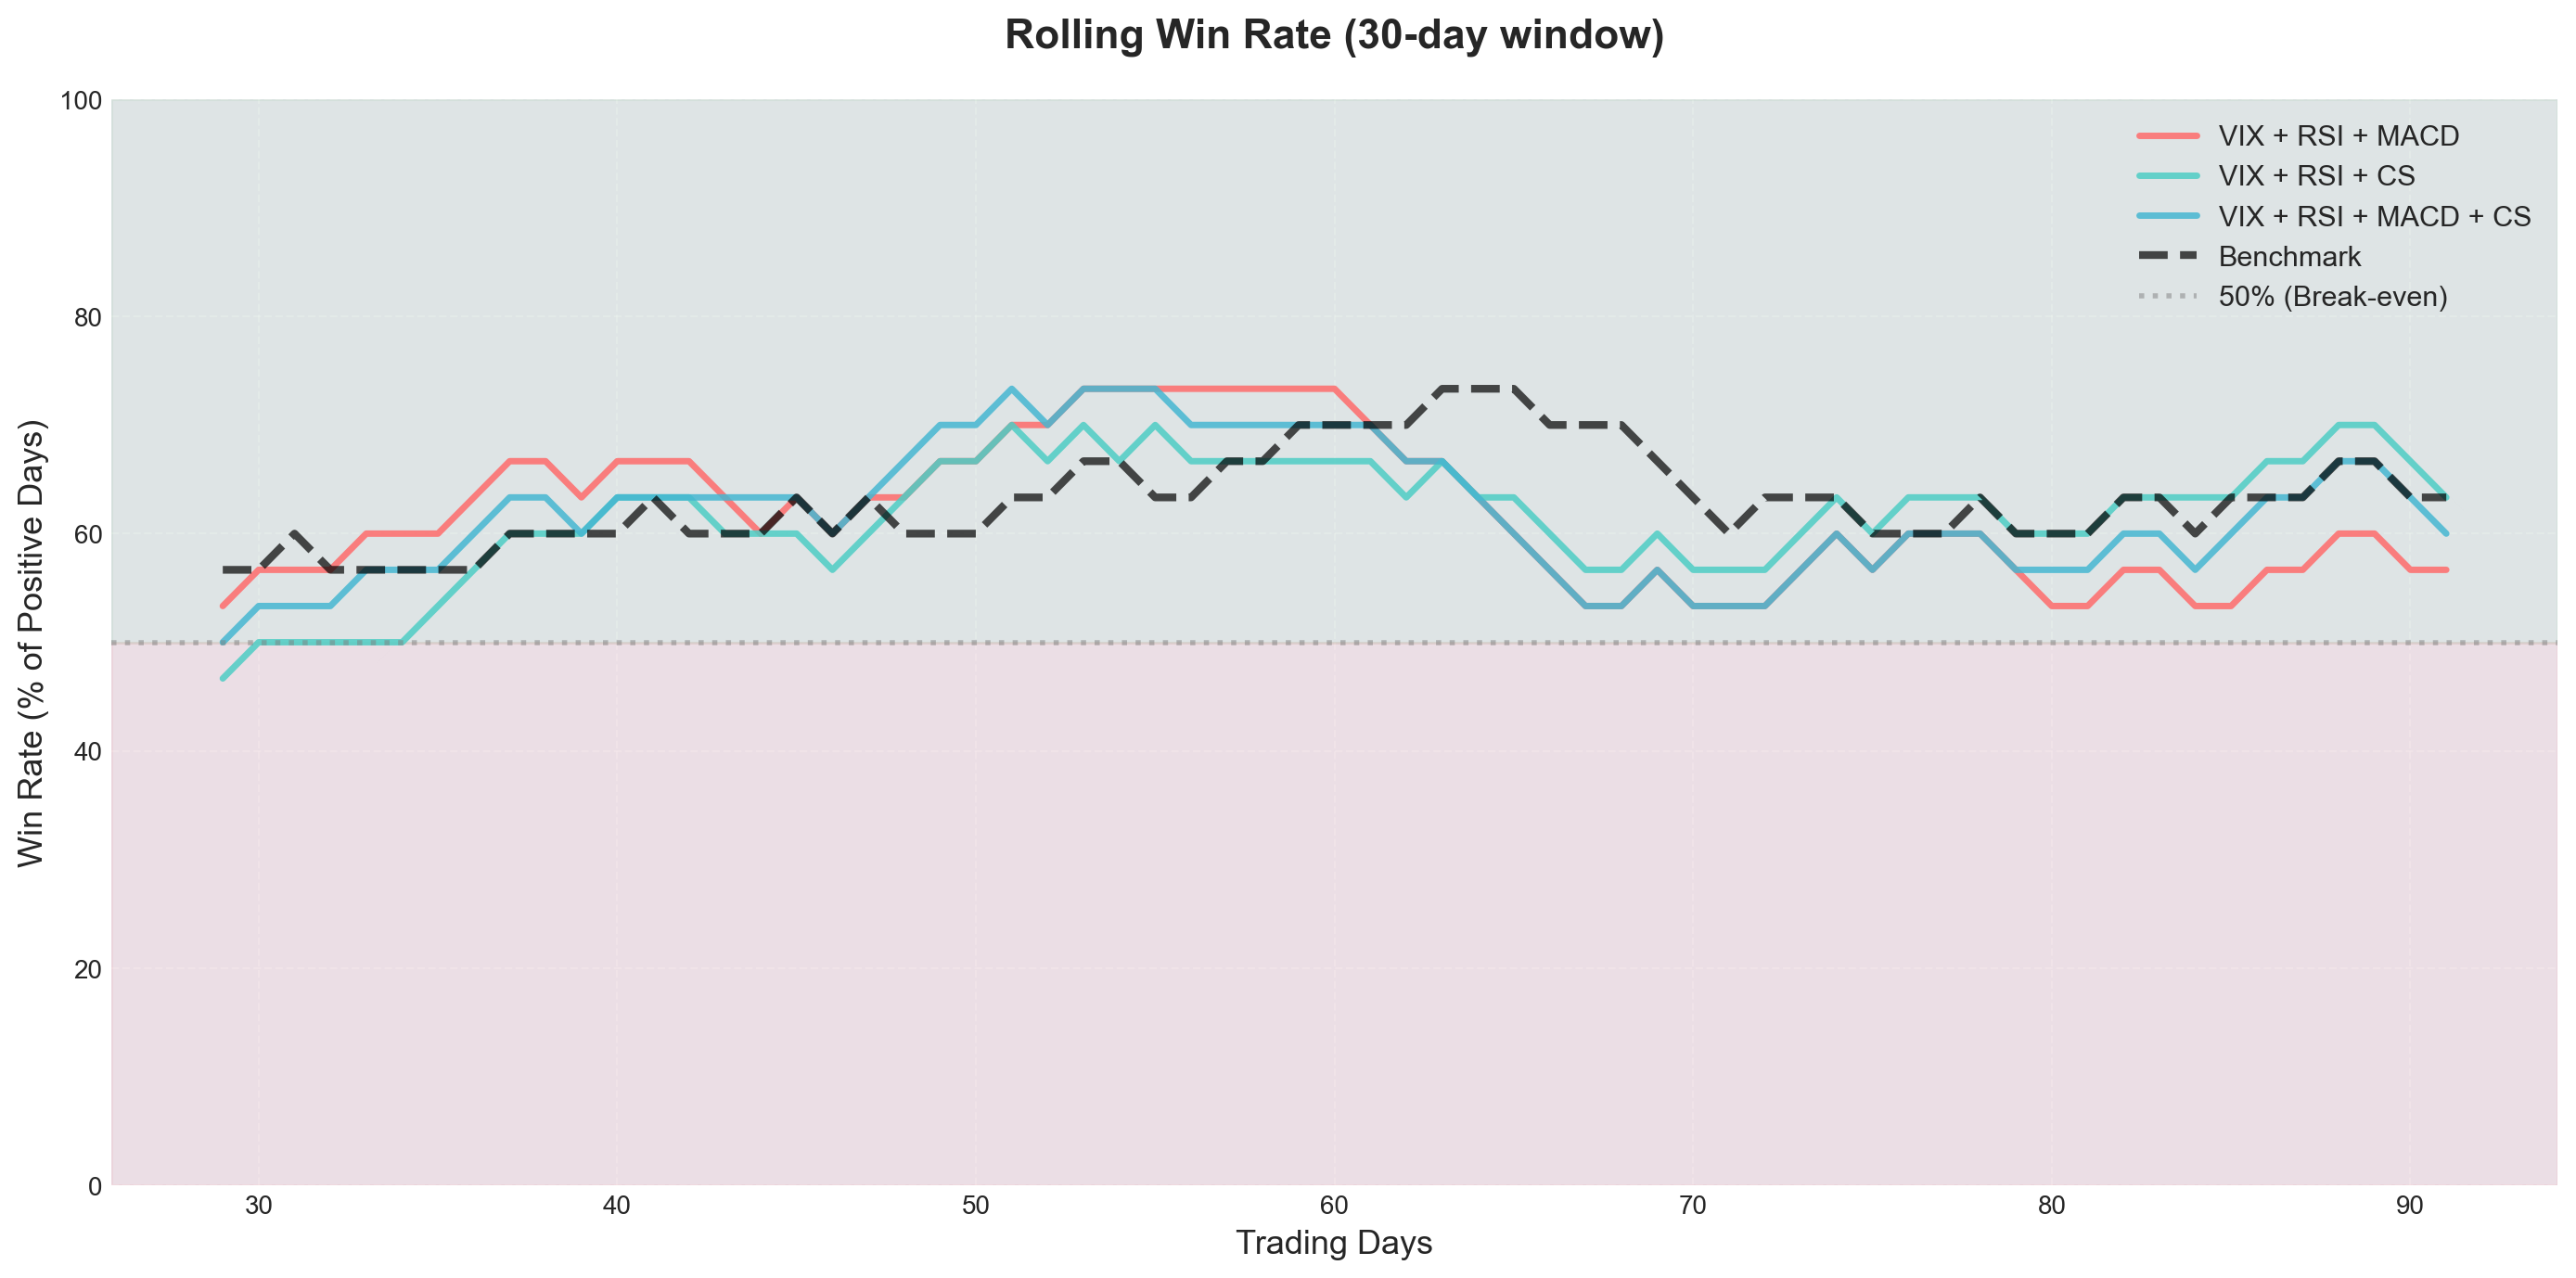


Rolling Win Rate Statistics (30-day window):
------------------------------------------------------------
Model                         Mean      Min      Max
------------------------------------------------------------
VIX + RSI + MACD             61.7%    53.3%    73.3%
VIX + RSI + CS               61.6%    46.7%    70.0%
VIX + RSI + MACD + CS        61.9%    50.0%    73.3%
Benchmark                    63.1%    56.7%    73.3%


In [46]:
# Rolling Metrics Chart 5: Rolling Win Rate

fig, ax = plt.subplots(figsize=(14, 7))

window = 30  # 30-day rolling window

# Calculate and plot rolling win rate for all models
for model_file, result in results.items():
    config = result['config']
    rolling_win_rate = pd.Series(result['rewards']).rolling(window).apply(
        lambda x: (x > 0).sum() / len(x) * 100, raw=True)
    ax.plot(rolling_win_rate, label=config['name'], 
            linewidth=2.5, color=config['color'], alpha=0.85)

# Benchmark rolling win rate
benchmark_rolling_win_rate = pd.Series(benchmark_rewards).rolling(window).apply(
    lambda x: (x > 0).sum() / len(x) * 100, raw=True)
ax.plot(benchmark_rolling_win_rate, label='Benchmark', 
        linewidth=3, color='black', linestyle='--', alpha=0.7)

ax.axhline(y=50, color='gray', linestyle=':', linewidth=2, alpha=0.5, label='50% (Break-even)')
ax.set_title(f'Rolling Win Rate ({window}-day window)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Trading Days', fontsize=13)
ax.set_ylabel('Win Rate (% of Positive Days)', fontsize=13)
ax.set_ylim([0, 100])
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Add shaded zones
ax.axhspan(50, 100, alpha=0.05, color='green')
ax.axhspan(0, 50, alpha=0.05, color='red')

plt.tight_layout()
plt.show()

# Print win rate statistics
print(f"\nRolling Win Rate Statistics ({window}-day window):")
print("-" * 60)
print(f"{'Model':<25} {'Mean':>8} {'Min':>8} {'Max':>8}")
print("-" * 60)
for model_file, result in results.items():
    config = result['config']
    rolling_win_rate = pd.Series(result['rewards']).rolling(window).apply(
        lambda x: (x > 0).sum() / len(x) * 100, raw=True)
    stats = rolling_win_rate.dropna()
    print(f"{config['name']:<25} {stats.mean():>7.1f}% {stats.min():>7.1f}% {stats.max():>7.1f}%")

benchmark_stats = benchmark_rolling_win_rate.dropna()
print(f"{'Benchmark':<25} {benchmark_stats.mean():>7.1f}% {benchmark_stats.min():>7.1f}% {benchmark_stats.max():>7.1f}%")